In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import sklearn

In [2]:
def load_images(path, labels):
  image_files = []
  labels_return = []
  for label in labels:
    for file in os.listdir(os.path.join(path, label)):
      image_files.append(os.path.join(path) + "/" + label + "/" + file)
      labels_return.append(label)
  return image_files, labels_return

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [3]:
path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train, label_train = load_images(path + "/Training", list_labels)
images_test, label_test = load_images(path + "/Testing", list_labels)


In [4]:
label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train = [label_to_index[label] for label in label_train]
label_test = [label_to_index[label] for label in label_test]

In [5]:
list_labels = [0, 1, 2, 3]
label_counts_train = [label_train.count(label) for label in list_labels]
# print(label_counts_train)

label_counts_test = [label_test.count(label) for label in list_labels]
print(label_counts_test)

[105, 74, 115, 100]


In [7]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transforms.Resize(size=(256, 256)),
        gaussian_blur,
        autocontrast,
        sharpeness,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        rotate,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
from monai import transforms
from monai.transforms import Activations
from monai.transforms import AsDiscrete

y_pred_trans = transforms.Compose([Activations(softmax=True)])
y_trans = transforms.Compose([AsDiscrete(to_onehot=4)])

In [7]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, 4, kernel_size=4, stride=2, padding=1, dilation=1)
        self.relu1 = nn.ReLU()
        self.avg = nn.MaxPool2d(kernel_size=4, stride=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1, dilation=1)
        self.drop = nn.Dropout(p=0.3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3528, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def name(self):
        return "LeNet"

In [8]:
use_cuda = torch.cuda.is_available()
Device = "cuda"
model = LeNet(1, 4).to(Device)

In [ ]:
test_dataset = Dataset(images_test, label_test, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

TASK 1

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.3993, train_recall: 0.4220, train_f1: 0.4013, train_accuracy: 0.4220
saved new best metric model
current epoch: 1 current AUC: 0.8457 current accuracy: 0.3397 best AUC: 0.8457 at epoch: 1
Epoch 1 fold 1 val_precision: 0.3435, val_recall: 0.3397, val_f1: 0.2160, val_accuracy: 0.3397
Epoch: 2


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 fold 1 train_precision: 0.5657, train_recall: 0.5518, train_f1: 0.5234, train_accuracy: 0.5518
saved new best metric model
current epoch: 2 current AUC: 0.8802 current accuracy: 0.6220 best AUC: 0.8802 at epoch: 2
Epoch 2 fold 1 val_precision: 0.6950, val_recall: 0.6220, val_f1: 0.6030, val_accuracy: 0.6220
Epoch: 3
Epoch 3 fold 1 train_precision: 0.6309, train_recall: 0.6254, train_f1: 0.6126, train_accuracy: 0.6254
saved new best metric model
current epoch: 3 current AUC: 0.8953 current accuracy: 0.6359 best AUC: 0.8953 at epoch: 3
Epoch 3 fold 1 val_precision: 0.6507, val_recall: 0.6359, val_f1: 0.5887, val_accuracy: 0.6359
Epoch: 4
Epoch 4 fold 1 train_precision: 0.6780, train_recall: 0.6816, train_f1: 0.6741, train_accuracy: 0.6816
saved new best metric model
current epoch: 4 current AUC: 0.9204 current accuracy: 0.7091 best AUC: 0.9204 at epoch: 4
Epoch 4 fold 1 val_precision: 0.7460, val_recall: 0.7091, val_f1: 0.7037, val_accuracy: 0.7091
Epoch: 5
Epoch 5 fold 1 train_p

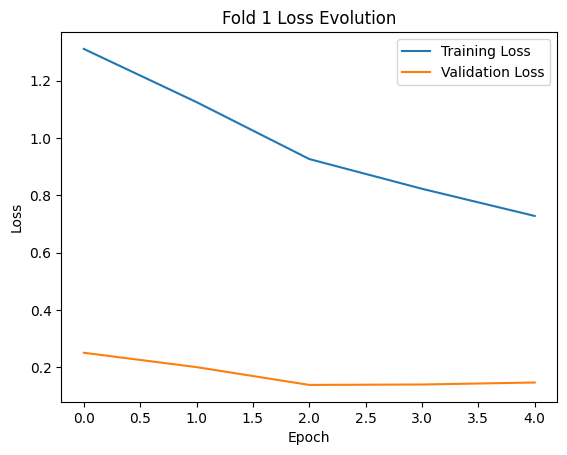

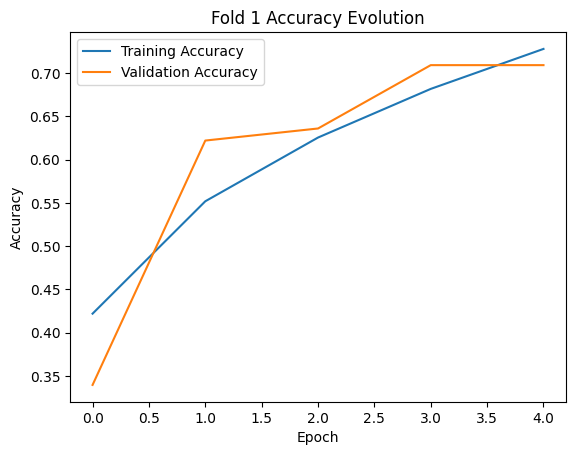

/tmp/ipykernel_7701/1830212690.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.2976    0.2381    0.2646       105
        no_tumor     0.3866    0.6216    0.4767        74
    glioma_tumor     0.3000    0.2870    0.2933       115
 pituitary_tumor     0.3457    0.2800    0.3094       100

        accuracy                         0.3350       394
       macro avg     0.3325    0.3567    0.3360       394
    weighted avg     0.3272    0.3350    0.3242       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.7402, train_recall: 0.7439, train_f1: 0.7383, train_accuracy: 0.7439
saved new best metric model
current epoch: 1 current AUC: 0.9451 current accuracy: 0.7875 best AUC: 0.9451 at epoch: 1
Epoch 1 fold 2 val_precision: 0.7932, val_recall: 0.7875, val_f1: 0.7791, val_accuracy: 0.7875
Epoch: 2
Epoch 2 fold 2 train_precision: 0.7720, train_recall: 0.7753, train_f1: 0.7723, train_accuracy: 0.7753
saved new best metric model
current epoch: 2 current AUC: 0.9469 curr

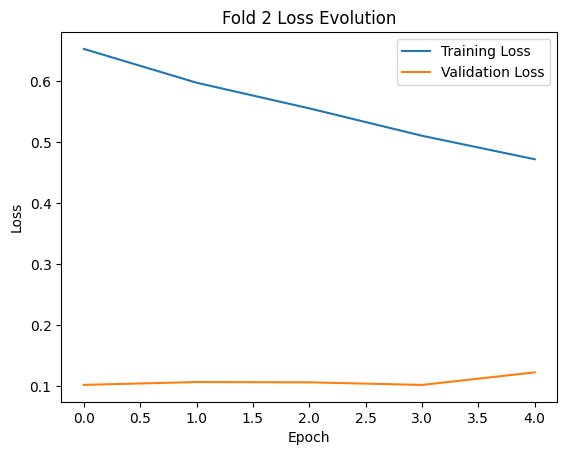

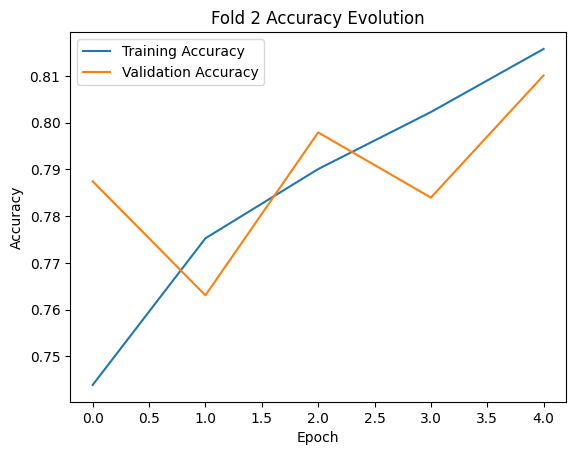

/tmp/ipykernel_7701/1830212690.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.3421    0.2476    0.2873       105
        no_tumor     0.5309    0.5811    0.5548        74
    glioma_tumor     0.3088    0.5478    0.3950       115
 pituitary_tumor     0.5152    0.1700    0.2556       100

        accuracy                         0.3782       394
       macro avg     0.4242    0.3866    0.3732       394
    weighted avg     0.4118    0.3782    0.3609       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8195, train_recall: 0.8210, train_f1: 0.8197, train_accuracy: 0.8210
saved new best metric model
current epoch: 1 current AUC: 0.9727 current accuracy: 0.8554 best AUC: 0.9727 at epoch: 1
Epoch 1 fold 3 val_precision: 0.8605, val_recall: 0.8554, val_f1: 0.8535, val_accuracy: 0.8554
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8417, train_recall: 0.8428, train_f1: 0.8419, train_accuracy: 0.8428
current epoch: 2 current AUC: 0.9706 current accuracy: 0.8519 best AU

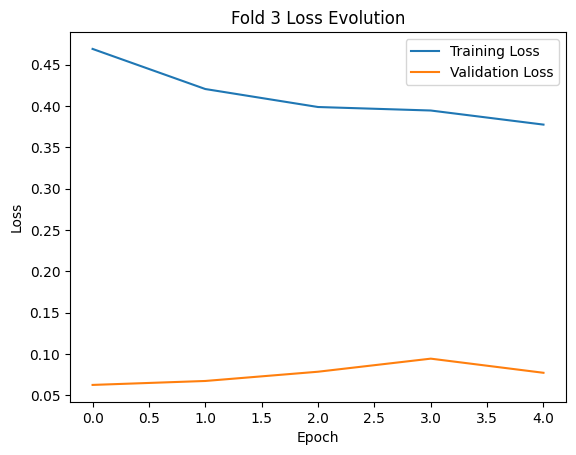

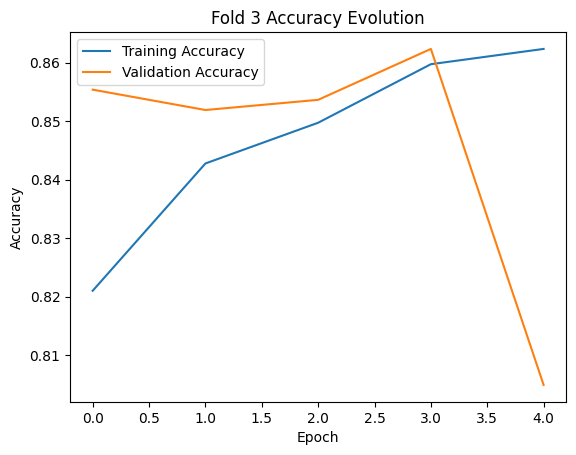

/tmp/ipykernel_7701/1830212690.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.3784    0.4000    0.3889       105
        no_tumor     0.4833    0.3919    0.4328        74
    glioma_tumor     0.3439    0.5652    0.4276       115
 pituitary_tumor     0.4706    0.1600    0.2388       100

        accuracy                         0.3858       394
       macro avg     0.4191    0.3793    0.3720       394
    weighted avg     0.4114    0.3858    0.3704       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8330, train_recall: 0.8341, train_f1: 0.8327, train_accuracy: 0.8341
saved new best metric model
current epoch: 1 current AUC: 0.9861 current accuracy: 0.9024 best AUC: 0.9861 at epoch: 1
Epoch 1 fold 4 val_precision: 0.9036, val_recall: 0.9024, val_f1: 0.9013, val_accuracy: 0.9024
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8606, train_recall: 0.8615, train_f1: 0.8609, train_accuracy: 0.8615
current epoch: 2 current AUC: 0.9846 current accuracy: 0.8937 best AU

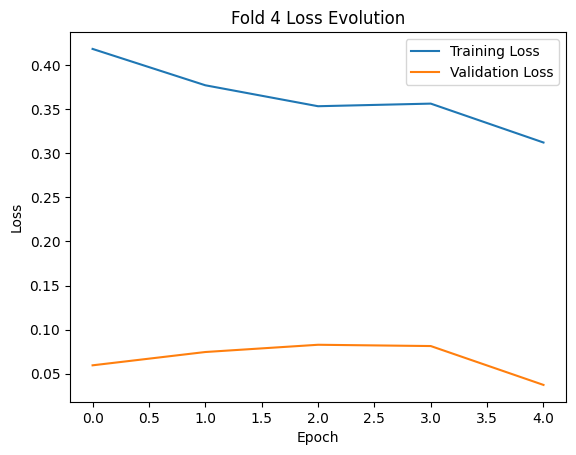

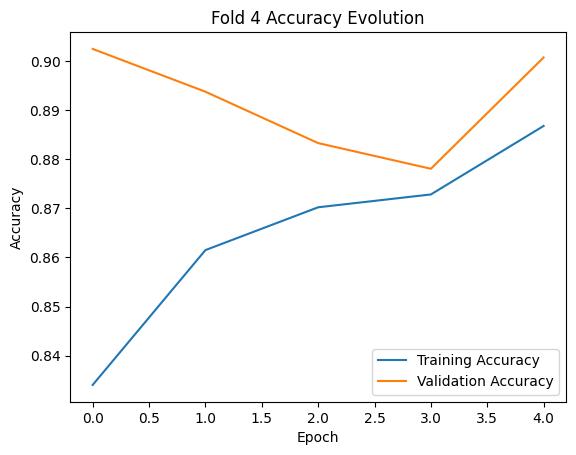

/tmp/ipykernel_7701/1830212690.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.4062    0.2476    0.3077       105
        no_tumor     0.5493    0.5270    0.5379        74
    glioma_tumor     0.3442    0.6435    0.4485       115
 pituitary_tumor     0.4545    0.2000    0.2778       100

        accuracy                         0.4036       394
       macro avg     0.4386    0.4045    0.3930       394
    weighted avg     0.4273    0.4036    0.3844       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8590, train_recall: 0.8602, train_f1: 0.8591, train_accuracy: 0.8602
current epoch: 1 current AUC: 0.9829 current accuracy: 0.8990 best AUC: 0.9861 at epoch: 1
Epoch 1 fold 5 val_precision: 0.9000, val_recall: 0.8990, val_f1: 0.8992, val_accuracy: 0.8990
Epoch: 2
Epoch 2 fold 5 train_precision: 0.8618, train_recall: 0.8624, train_f1: 0.8617, train_accuracy: 0.8624
current epoch: 2 current AUC: 0.9808 current accuracy: 0.8763 best AUC: 0.9861 at epoch: 1
Epoch 

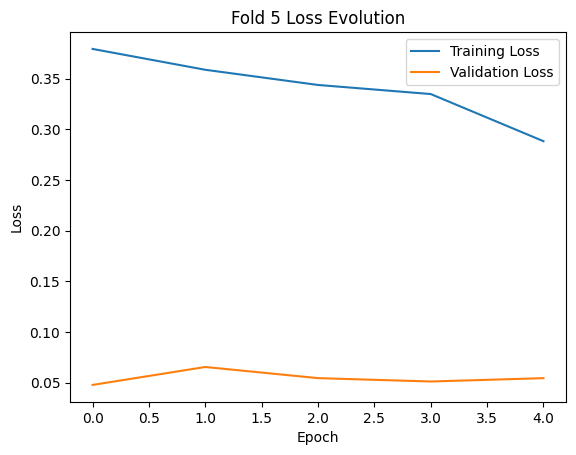

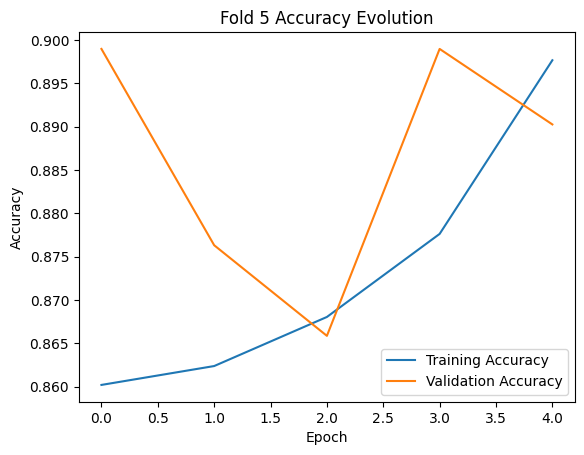

/tmp/ipykernel_7701/1830212690.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.4062    0.2476    0.3077       105
        no_tumor     0.5493    0.5270    0.5379        74
    glioma_tumor     0.3442    0.6435    0.4485       115
 pituitary_tumor     0.4545    0.2000    0.2778       100

        accuracy                         0.4036       394
       macro avg     0.4386    0.4045    0.3930       394
    weighted avg     0.4273    0.4036    0.3844       394

Fold 5 completed.
train_precision: Mean = 0.7931, Std = 0.1148
train_recall: Mean = 0.7945, Std = 0.1132
train_f1: Mean = 0.7904, Std = 0.1194
train_accuracy: Mean = 0.7945, Std = 0.1132
val_precision: Mean = 0.8135, Std = 0.1182
val_recall: Mean = 0.8030, Std = 0.1235
val_f1: Mean = 0.7915, Std = 0.1473
val_accuracy: Mean = 0.8030, Std = 0.1235


In [11]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train, label_train, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [12]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_7701/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.4062    0.2476    0.3077       105
        no_tumor     0.5493    0.5270    0.5379        74
    glioma_tumor     0.3442    0.6435    0.4485       115
 pituitary_tumor     0.4545    0.2000    0.2778       100

        accuracy                         0.4036       394
       macro avg     0.4386    0.4045    0.3930       394
    weighted avg     0.4273    0.4036    0.3844       394



TASK 2

In [11]:
from torch.nn.functional import one_hot

def class_weights(labels, num_classes):
    total_samples = len(labels)
    
    if num_classes is None:
        num_classes = labels.max().item() + 1
    
    counts = torch.zeros(num_classes)
    for label in labels:
        counts[label] += 1
    
    return total_samples / (num_classes * counts)

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.5341, train_recall: 0.5335, train_f1: 0.5236, train_accuracy: 0.5335
saved new best metric model
current epoch: 1 current AUC: 0.8543 current accuracy: 0.6411 best AUC: 0.8543 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6441, val_recall: 0.6411, val_f1: 0.6304, val_accuracy: 0.6411
Epoch: 2
Epoch 2 fold 1 train_precision: 0.6621, train_recall: 0.6720, train_f1: 0.6625, train_accuracy: 0.6720
saved new best metric model
current epoch: 2 current AUC: 0.8995 current accuracy: 0.6725 best AUC: 0.8995 at epoch: 2
Epoch 2 fold 1 val_precision: 0.6642, val_recall: 0.6725, val_f1: 0.6628, val_accuracy: 0.6725
Epoch: 3
Epoch 3 fold 1 train_precision: 0.7128, train_recall: 0.7204, train_f1: 0.7138, train_accuracy: 0.7204
saved new best metric model
current epoch: 3 current AUC: 0.9072 current accuracy: 0.7125 best AUC: 0.9072 at epoch: 3
Epoch 3 fold 1 val_precision: 0.7081, val_recall: 0.7125, val_f1: 0.6972, val_accuracy: 0.7125
Epoch: 4
Epoch

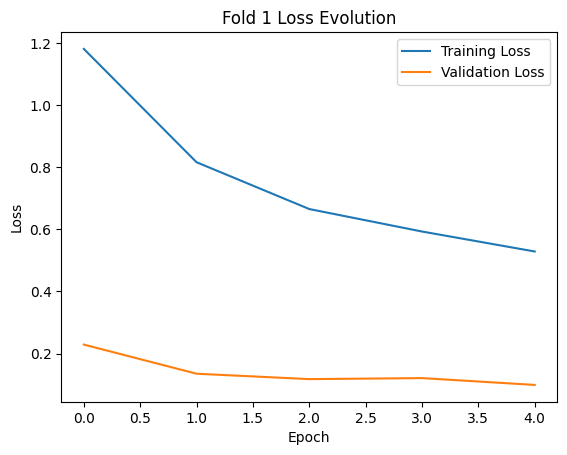

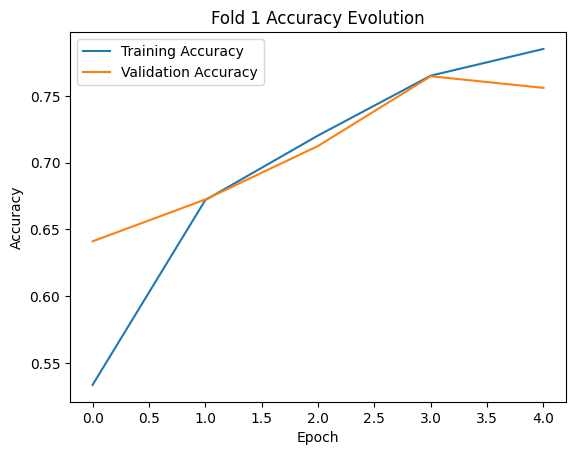

/tmp/ipykernel_10453/2525533155.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.3018    0.4857    0.3723       105
 pituitary_tumor     0.7097    0.2973    0.4190        74
    glioma_tumor     0.4276    0.5391    0.4769       115
        no_tumor     0.2857    0.1400    0.1879       100

        accuracy                         0.3782       394
       macro avg     0.4312    0.3655    0.3640       394
    weighted avg     0.4110    0.3782    0.3648       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.7994, train_recall: 0.8027, train_f1: 0.7999, train_accuracy: 0.8027
saved new best metric model
current epoch: 1 current AUC: 0.9608 current accuracy: 0.8136 best AUC: 0.9608 at epoch: 1
Epoch 1 fold 2 val_precision: 0.8335, val_recall: 0.8136, val_f1: 0.8012, val_accuracy: 0.8136
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8045, train_recall: 0.8057, train_f1: 0.8025, train_accuracy: 0.8057
current epoch: 2 current AUC: 0.9602 current accuracy: 0.8449 best AU

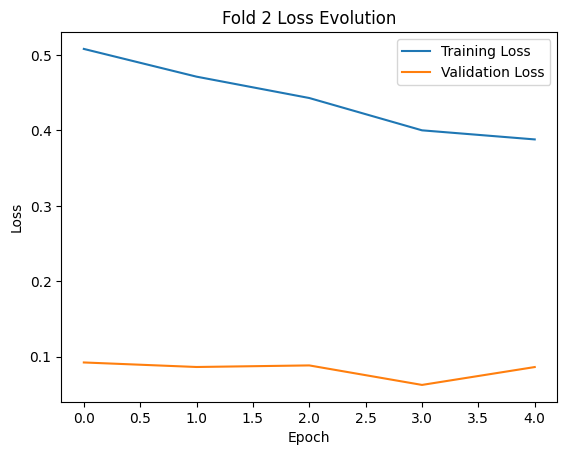

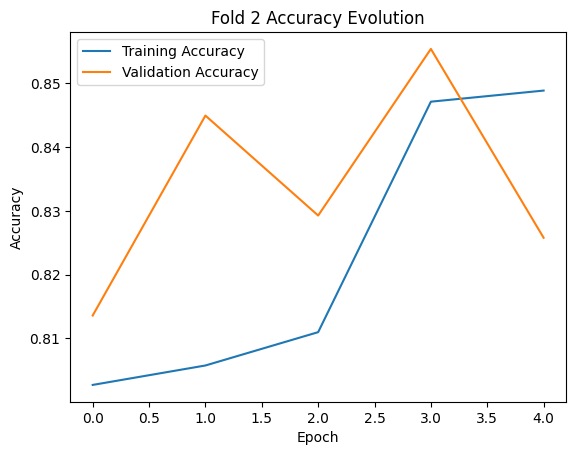

/tmp/ipykernel_10453/2525533155.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.3043    0.4667    0.3684       105
 pituitary_tumor     0.6053    0.3108    0.4107        74
    glioma_tumor     0.4848    0.5565    0.5182       115
        no_tumor     0.2857    0.1800    0.2209       100

        accuracy                         0.3909       394
       macro avg     0.4200    0.3785    0.3796       394
    weighted avg     0.4088    0.3909    0.3826       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8438, train_recall: 0.8458, train_f1: 0.8434, train_accuracy: 0.8458
saved new best metric model
current epoch: 1 current AUC: 0.9822 current accuracy: 0.8659 best AUC: 0.9822 at epoch: 1
Epoch 1 fold 3 val_precision: 0.8823, val_recall: 0.8659, val_f1: 0.8660, val_accuracy: 0.8659
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8406, train_recall: 0.8428, train_f1: 0.8413, train_accuracy: 0.8428
current epoch: 2 current AUC: 0.9784 current accuracy: 0.8362 best AU

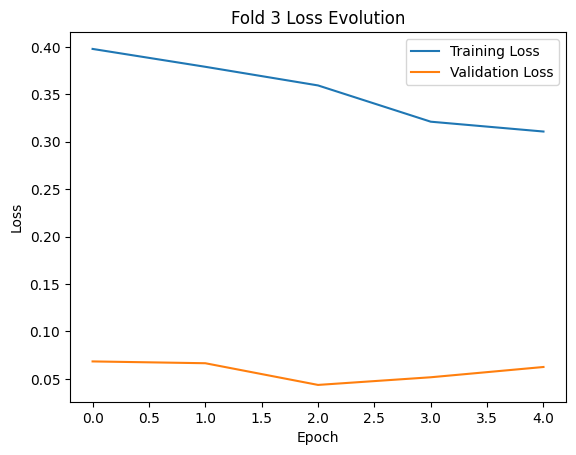

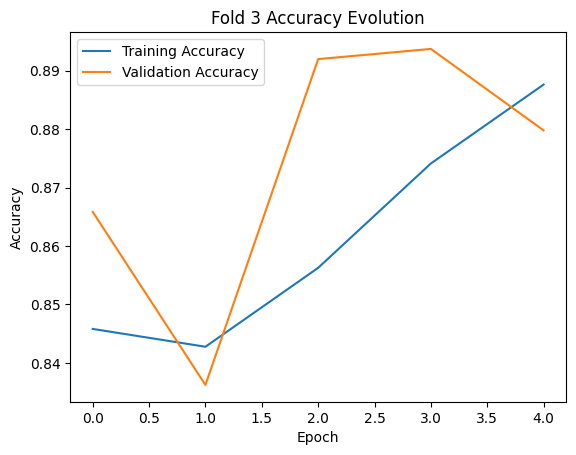

/tmp/ipykernel_10453/2525533155.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.2805    0.2190    0.2460       105
 pituitary_tumor     0.7222    0.1757    0.2826        74
    glioma_tumor     0.3470    0.8087    0.4856       115
        no_tumor     0.3462    0.0900    0.1429       100

        accuracy                         0.3503       394
       macro avg     0.4240    0.3234    0.2893       394
    weighted avg     0.3995    0.3503    0.2966       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8424, train_recall: 0.8436, train_f1: 0.8423, train_accuracy: 0.8436
saved new best metric model
current epoch: 1 current AUC: 0.9872 current accuracy: 0.8902 best AUC: 0.9872 at epoch: 1
Epoch 1 fold 4 val_precision: 0.8963, val_recall: 0.8902, val_f1: 0.8867, val_accuracy: 0.8902
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8569, train_recall: 0.8576, train_f1: 0.8560, train_accuracy: 0.8576
current epoch: 2 current AUC: 0.9848 current accuracy: 0.9077 best AU

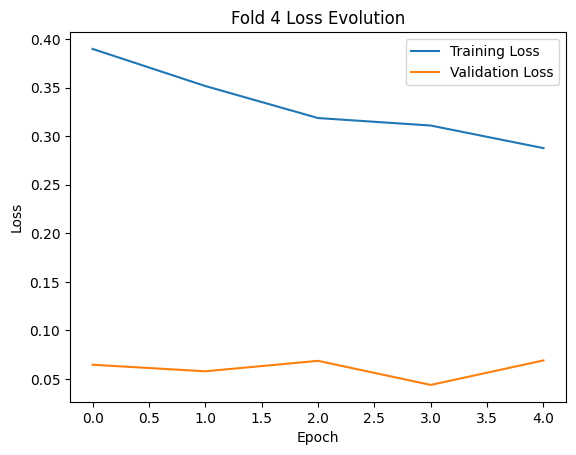

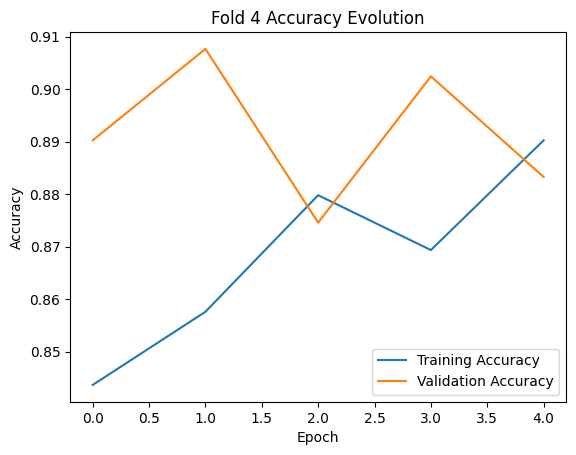

/tmp/ipykernel_10453/2525533155.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.3026    0.6571    0.4144       105
 pituitary_tumor     0.6667    0.1081    0.1860        74
    glioma_tumor     0.5000    0.4522    0.4749       115
        no_tumor     0.3000    0.1500    0.2000       100

        accuracy                         0.3655       394
       macro avg     0.4423    0.3419    0.3188       394
    weighted avg     0.4279    0.3655    0.3348       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8671, train_recall: 0.8680, train_f1: 0.8666, train_accuracy: 0.8680
current epoch: 1 current AUC: 0.9852 current accuracy: 0.8833 best AUC: 0.9872 at epoch: 1
Epoch 1 fold 5 val_precision: 0.8841, val_recall: 0.8833, val_f1: 0.8820, val_accuracy: 0.8833
Epoch: 2
Epoch 2 fold 5 train_precision: 0.8794, train_recall: 0.8807, train_f1: 0.8796, train_accuracy: 0.8807
saved new best metric model
current epoch: 2 current AUC: 0.9878 current accuracy: 0.9024 best AU

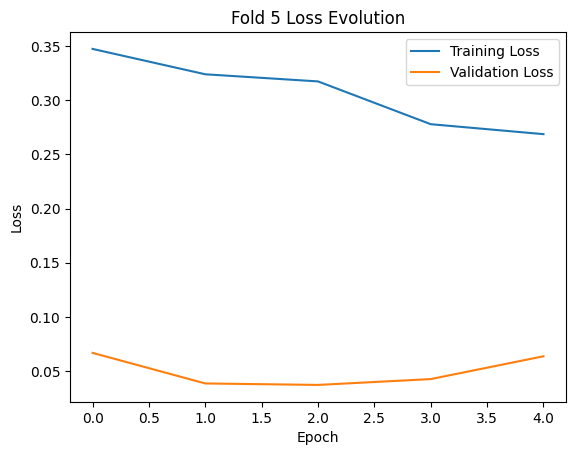

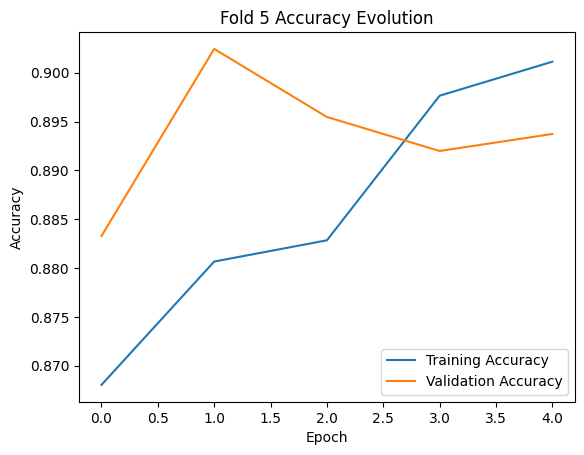

/tmp/ipykernel_10453/2525533155.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.2739    0.4095    0.3282       105
 pituitary_tumor     0.5000    0.0405    0.0750        74
    glioma_tumor     0.4382    0.6783    0.5324       115
        no_tumor     0.2642    0.1400    0.1830       100

        accuracy                         0.3503       394
       macro avg     0.3691    0.3171    0.2797       394
    weighted avg     0.3618    0.3503    0.3034       394

Fold 5 completed.
train_precision: Mean = 0.8248, Std = 0.0822
train_recall: Mean = 0.8268, Std = 0.0811
train_f1: Mean = 0.8241, Std = 0.0836
train_accuracy: Mean = 0.8268, Std = 0.0811
val_precision: Mean = 0.8451, Std = 0.0740
val_recall: Mean = 0.8403, Std = 0.0733
val_f1: Mean = 0.8363, Std = 0.0765
val_accuracy: Mean = 0.8403, Std = 0.0733


In [12]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train, label_train, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            class_w = class_weights(label, 4)
            loss_function = torch.nn.CrossEntropyLoss(weight=class_w.to(Device))
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    class_w = class_weights(val_label, 4)
                    loss_function = torch.nn.CrossEntropyLoss(weight=class_w.to(Device))
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [13]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_10453/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.2739    0.4095    0.3282       105
 pituitary_tumor     0.5000    0.0405    0.0750        74
    glioma_tumor     0.4382    0.6783    0.5324       115
        no_tumor     0.2642    0.1400    0.1830       100

        accuracy                         0.3503       394
       macro avg     0.3691    0.3171    0.2797       394
    weighted avg     0.3618    0.3503    0.3034       394



In [12]:
path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

In [13]:
label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

In [19]:
import random

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [20]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transforms.Resize(size=(256, 256)),
        gaussian_blur,
        autocontrast,
        sharpeness,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        rotate,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.5309, train_recall: 0.5364, train_f1: 0.5315, train_accuracy: 0.5364
saved new best metric model
current epoch: 1 current AUC: 0.8572 current accuracy: 0.6187 best AUC: 0.8572 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6151, val_recall: 0.6187, val_f1: 0.5978, val_accuracy: 0.6187
Epoch: 2
Epoch 2 fold 1 train_precision: 0.6893, train_recall: 0.6914, train_f1: 0.6868, train_accuracy: 0.6914
saved new best metric model
current epoch: 2 current AUC: 0.8995 current accuracy: 0.7075 best AUC: 0.8995 at epoch: 2
Epoch 2 fold 1 val_precision: 0.7001, val_recall: 0.7075, val_f1: 0.6918, val_accuracy: 0.7075
Epoch: 3
Epoch 3 fold 1 train_precision: 0.7410, train_recall: 0.7450, train_f1: 0.7412, train_accuracy: 0.7450
saved new best metric model
current epoch: 3 current AUC: 0.9175 current accuracy: 0.7458 best AUC: 0.9175 at epoch: 3
Epoch 3 fold 1 val_precision: 0.7379, val_recall: 0.7458, val_f1: 0.7347, val_accuracy: 0.7458
Epoch: 4
Epoch

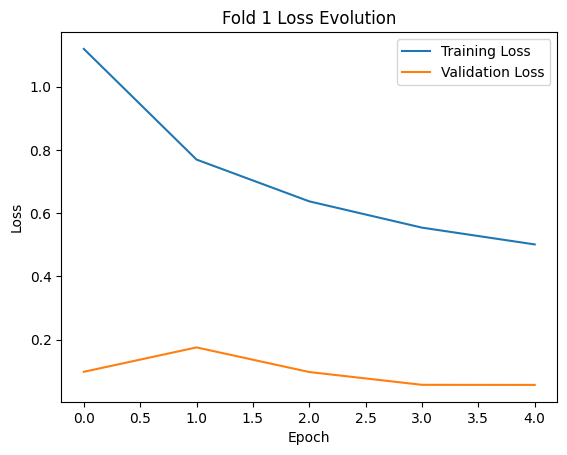

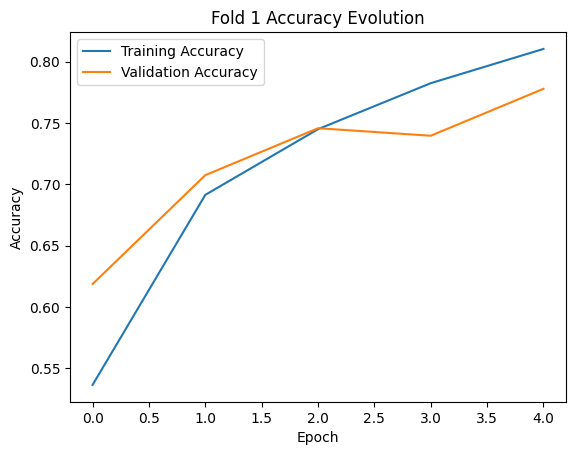

/tmp/ipykernel_13965/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.3047    0.3714    0.3348       105
meningioma_tumor     0.5000    0.1081    0.1778        74
        no_tumor     0.4250    0.7391    0.5397       115
 pituitary_tumor     0.3000    0.1500    0.2000       100

        accuracy                         0.3731       394
       macro avg     0.3824    0.3422    0.3131       394
    weighted avg     0.3753    0.3731    0.3309       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.7934, train_recall: 0.7975, train_f1: 0.7938, train_accuracy: 0.7975
saved new best metric model
current epoch: 1 current AUC: 0.9687 current accuracy: 0.8361 best AUC: 0.9687 at epoch: 1
Epoch 1 fold 2 val_precision: 0.8450, val_recall: 0.8361, val_f1: 0.8298, val_accuracy: 0.8361
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8355, train_recall: 0.8373, train_f1: 0.8347, train_accuracy: 0.8373
saved new best metric model
current epoch: 2 current AUC: 0.9729 curr

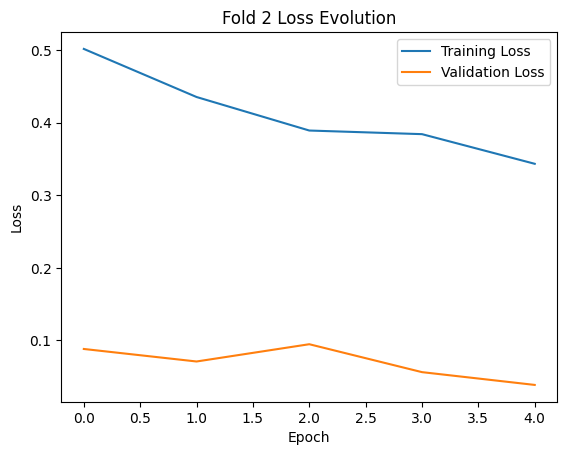

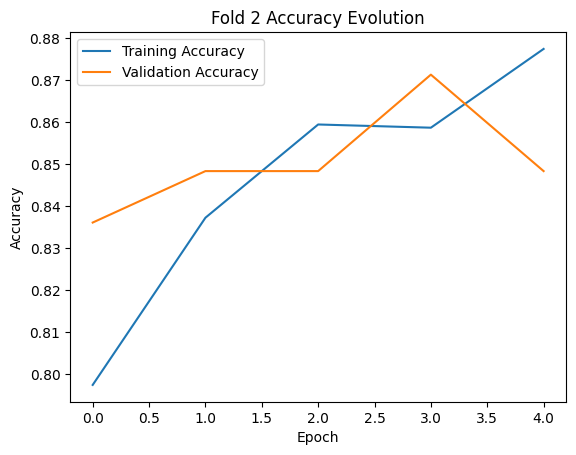

/tmp/ipykernel_13965/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.3000    0.3714    0.3319       105
meningioma_tumor     0.4062    0.1757    0.2453        74
        no_tumor     0.4368    0.7217    0.5443       115
 pituitary_tumor     0.3095    0.1300    0.1831       100

        accuracy                         0.3756       394
       macro avg     0.3632    0.3497    0.3261       394
    weighted avg     0.3623    0.3756    0.3399       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8666, train_recall: 0.8675, train_f1: 0.8668, train_accuracy: 0.8675
saved new best metric model
current epoch: 1 current AUC: 0.9863 current accuracy: 0.9158 best AUC: 0.9863 at epoch: 1
Epoch 1 fold 3 val_precision: 0.9165, val_recall: 0.9158, val_f1: 0.9156, val_accuracy: 0.9158
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8747, train_recall: 0.8756, train_f1: 0.8751, train_accuracy: 0.8756
saved new best metric model
current epoch: 2 current AUC: 0.9883 curr

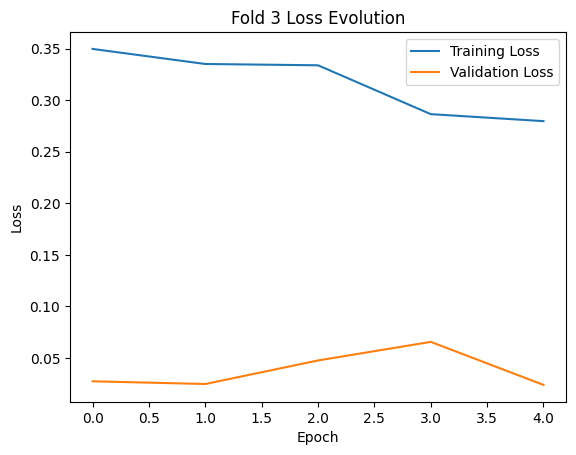

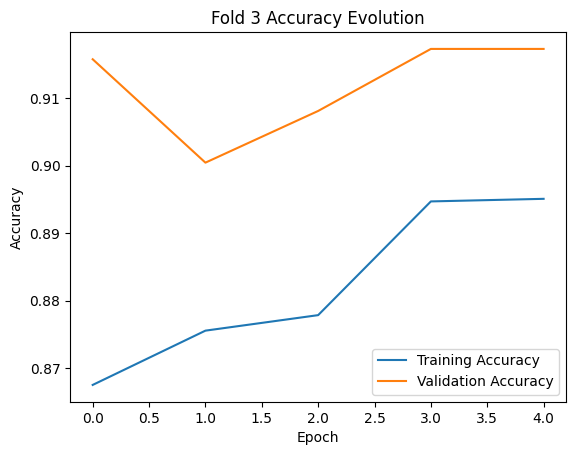

/tmp/ipykernel_13965/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.3350    0.6286    0.4371       105
meningioma_tumor     0.4286    0.0811    0.1364        74
        no_tumor     0.5447    0.5826    0.5630       115
 pituitary_tumor     0.2833    0.1700    0.2125       100

        accuracy                         0.3959       394
       macro avg     0.3979    0.3656    0.3372       394
    weighted avg     0.4007    0.3959    0.3604       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8631, train_recall: 0.8641, train_f1: 0.8632, train_accuracy: 0.8641
saved new best metric model
current epoch: 1 current AUC: 0.9910 current accuracy: 0.9342 best AUC: 0.9910 at epoch: 1
Epoch 1 fold 4 val_precision: 0.9357, val_recall: 0.9342, val_f1: 0.9342, val_accuracy: 0.9342
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8813, train_recall: 0.8817, train_f1: 0.8815, train_accuracy: 0.8817
current epoch: 2 current AUC: 0.9903 current accuracy: 0.9280 best AU

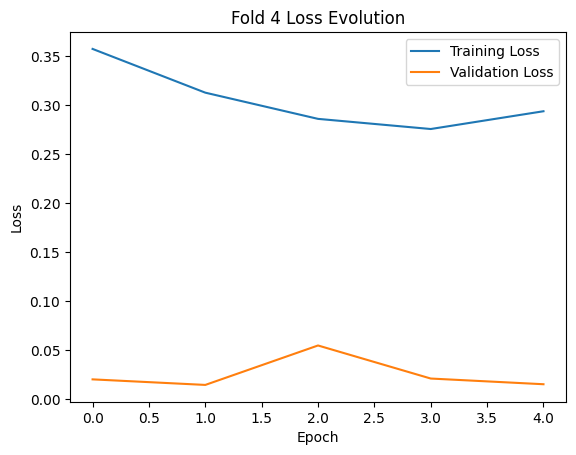

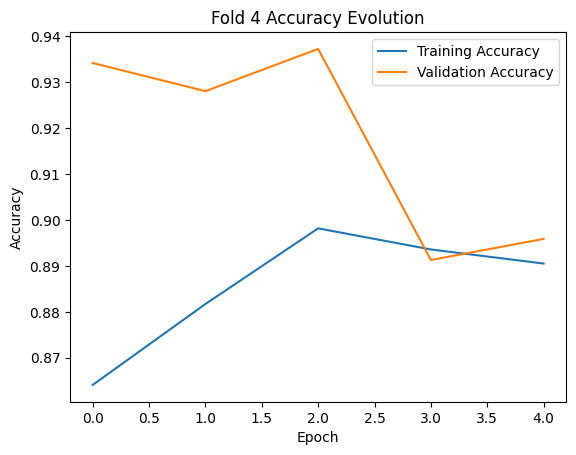

/tmp/ipykernel_13965/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.3370    0.5810    0.4266       105
meningioma_tumor     0.5294    0.1216    0.1978        74
        no_tumor     0.4529    0.6696    0.5404       115
 pituitary_tumor     0.4231    0.1100    0.1746       100

        accuracy                         0.4010       394
       macro avg     0.4356    0.3705    0.3348       394
    weighted avg     0.4288    0.4010    0.3529       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8815, train_recall: 0.8821, train_f1: 0.8799, train_accuracy: 0.8821
current epoch: 1 current AUC: 0.9897 current accuracy: 0.9142 best AUC: 0.9910 at epoch: 1
Epoch 1 fold 5 val_precision: 0.9157, val_recall: 0.9142, val_f1: 0.9147, val_accuracy: 0.9142
Epoch: 2
Epoch 2 fold 5 train_precision: 0.9101, train_recall: 0.9108, train_f1: 0.9101, train_accuracy: 0.9108
current epoch: 2 current AUC: 0.9904 current accuracy: 0.9112 best AUC: 0.9910 at epoch: 1
Epoch 

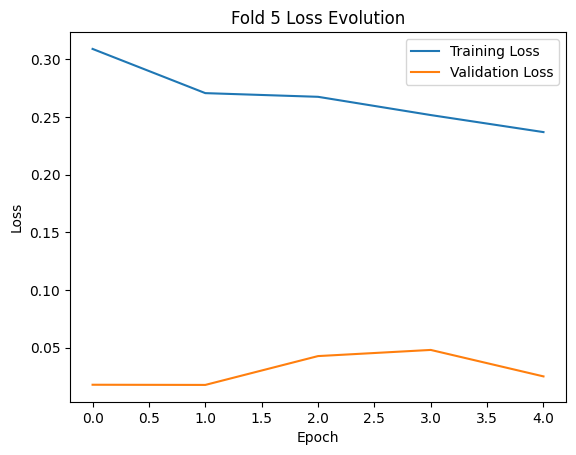

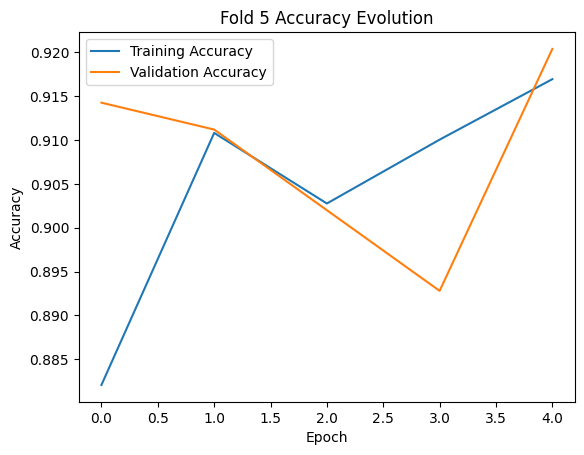

/tmp/ipykernel_13965/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.3370    0.5810    0.4266       105
meningioma_tumor     0.5294    0.1216    0.1978        74
        no_tumor     0.4529    0.6696    0.5404       115
 pituitary_tumor     0.4231    0.1100    0.1746       100

        accuracy                         0.4010       394
       macro avg     0.4356    0.3705    0.3348       394
    weighted avg     0.4288    0.4010    0.3529       394

Fold 5 completed.
train_precision: Mean = 0.8448, Std = 0.0843
train_recall: Mean = 0.8463, Std = 0.0831
train_f1: Mean = 0.8447, Std = 0.0844
train_accuracy: Mean = 0.8463, Std = 0.0831
val_precision: Mean = 0.8638, Std = 0.0812
val_recall: Mean = 0.8611, Std = 0.0802
val_f1: Mean = 0.8581, Std = 0.0845
val_accuracy: Mean = 0.8611, Std = 0.0802


In [21]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [22]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_13965/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.3370    0.5810    0.4266       105
meningioma_tumor     0.5294    0.1216    0.1978        74
        no_tumor     0.4529    0.6696    0.5404       115
 pituitary_tumor     0.4231    0.1100    0.1746       100

        accuracy                         0.4010       394
       macro avg     0.4356    0.3705    0.3348       394
    weighted avg     0.4288    0.4010    0.3529       394



In [6]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [8]:
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.6387, train_recall: 0.6367, train_f1: 0.6330, train_accuracy: 0.6367
saved new best metric model
current epoch: 1 current AUC: 0.8693 current accuracy: 0.6753 best AUC: 0.8693 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6726, val_recall: 0.6753, val_f1: 0.6683, val_accuracy: 0.6753
Epoch: 2
Epoch 2 fold 1 train_precision: 0.6990, train_recall: 0.7010, train_f1: 0.6952, train_accuracy: 0.7010
saved new best metric model
current epoch: 2 current AUC: 0.8908 current accuracy: 0.6907 best AUC: 0.8908 at epoch: 2
Epoch 2 fold 1 val_precision: 0.7078, val_recall: 0.6907, val_f1: 0.6887, val_accuracy: 0.6907
Epoch: 3
Epoch 3 fold 1 train_precision: 0.7323, train_recall: 0.7366, train_f1: 0.7321, train_accuracy: 0.7366
saved new best metric model
current epoch: 3 current AUC: 0.9054 current accuracy: 0.7182 best AUC: 0.9054 at epoch: 3
Epoch 3 fold 1 val_precision: 0.7087, val_recall: 0.7182, val_f1: 0.7074, val_accuracy: 0.7182
Epoch: 4
Epoch

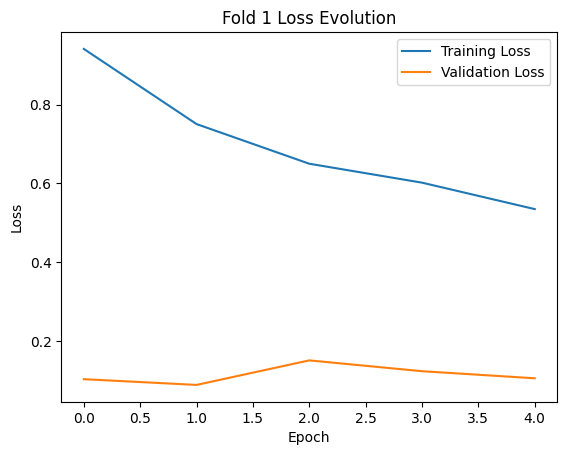

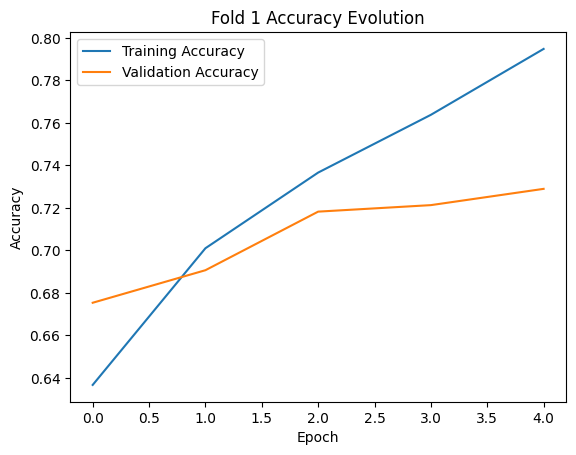

/tmp/ipykernel_6120/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.4309    0.7429    0.5455       105
 pituitary_tumor     0.7200    0.4865    0.5806        74
    glioma_tumor     0.4759    0.6000    0.5308       115
        no_tumor     0.4444    0.0800    0.1356       100

        accuracy                         0.4848       394
       macro avg     0.5178    0.4773    0.4481       394
    weighted avg     0.5018    0.4848    0.4438       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.7852, train_recall: 0.7887, train_f1: 0.7861, train_accuracy: 0.7887
saved new best metric model
current epoch: 1 current AUC: 0.9587 current accuracy: 0.7979 best AUC: 0.9587 at epoch: 1
Epoch 1 fold 2 val_precision: 0.8324, val_recall: 0.7979, val_f1: 0.7781, val_accuracy: 0.7979
Epoch: 2
Epoch 2 fold 2 train_precision: 0.7896, train_recall: 0.7925, train_f1: 0.7892, train_accuracy: 0.7925
saved new best metric model
current epoch: 2 current AUC: 0.9617 curr

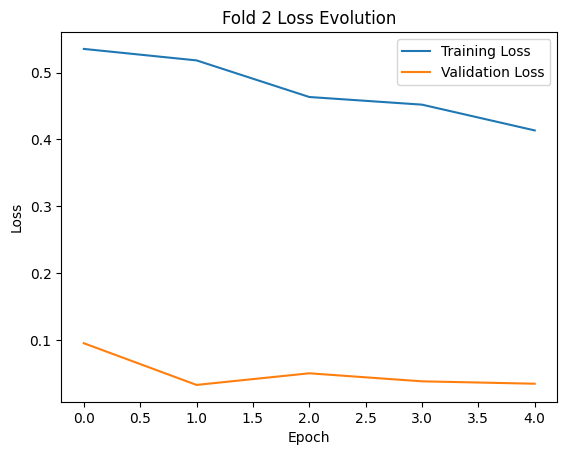

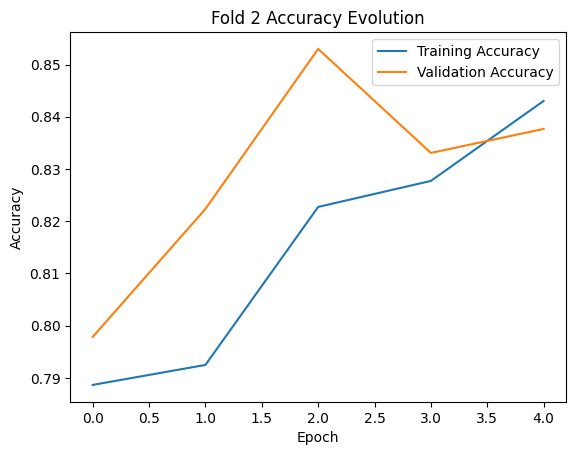

/tmp/ipykernel_6120/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.3755    0.9905    0.5445       105
 pituitary_tumor     0.7895    0.4054    0.5357        74
    glioma_tumor     0.6034    0.3043    0.4046       115
        no_tumor     0.7143    0.1500    0.2479       100

        accuracy                         0.4670       394
       macro avg     0.6207    0.4626    0.4332       394
    weighted avg     0.6058    0.4670    0.4268       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8399, train_recall: 0.8423, train_f1: 0.8405, train_accuracy: 0.8423
saved new best metric model
current epoch: 1 current AUC: 0.9786 current accuracy: 0.8851 best AUC: 0.9786 at epoch: 1
Epoch 1 fold 3 val_precision: 0.8841, val_recall: 0.8851, val_f1: 0.8838, val_accuracy: 0.8851
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8429, train_recall: 0.8438, train_f1: 0.8420, train_accuracy: 0.8438
current epoch: 2 current AUC: 0.9764 current accuracy: 0.8806 best AU

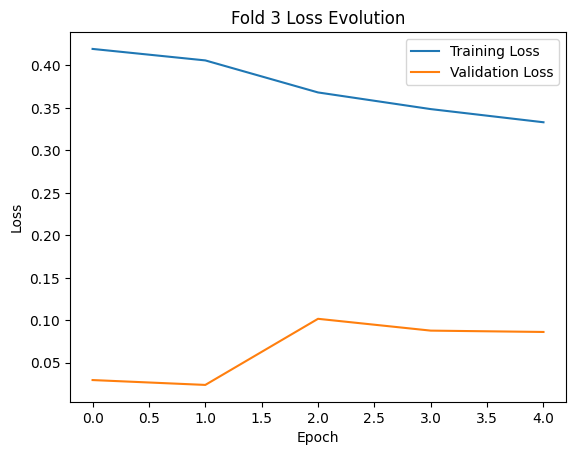

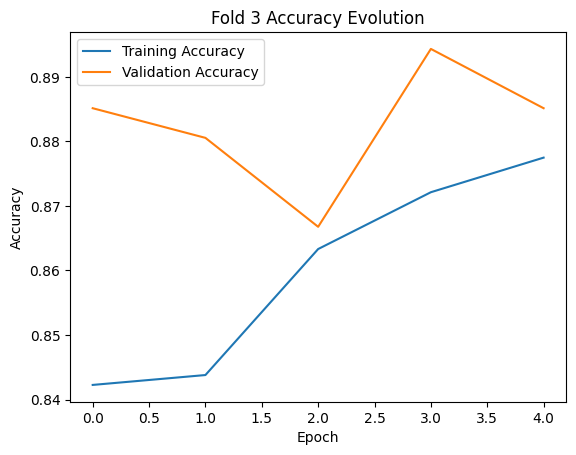

/tmp/ipykernel_6120/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5178    0.9714    0.6755       105
 pituitary_tumor     0.8444    0.5135    0.6387        74
    glioma_tumor     0.5746    0.6696    0.6185       115
        no_tumor     0.7778    0.1400    0.2373       100

        accuracy                         0.5863       394
       macro avg     0.6787    0.5736    0.5425       394
    weighted avg     0.6617    0.5863    0.5407       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8520, train_recall: 0.8530, train_f1: 0.8521, train_accuracy: 0.8530
saved new best metric model
current epoch: 1 current AUC: 0.9867 current accuracy: 0.9096 best AUC: 0.9867 at epoch: 1
Epoch 1 fold 4 val_precision: 0.9085, val_recall: 0.9096, val_f1: 0.9086, val_accuracy: 0.9096
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8751, train_recall: 0.8760, train_f1: 0.8749, train_accuracy: 0.8760
current epoch: 2 current AUC: 0.9841 current accuracy: 0.8989 best AU

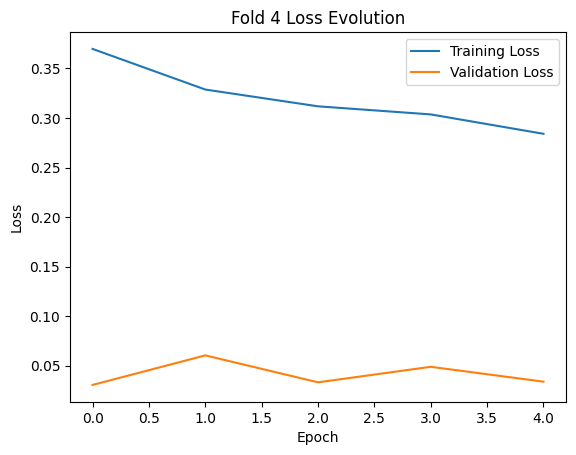

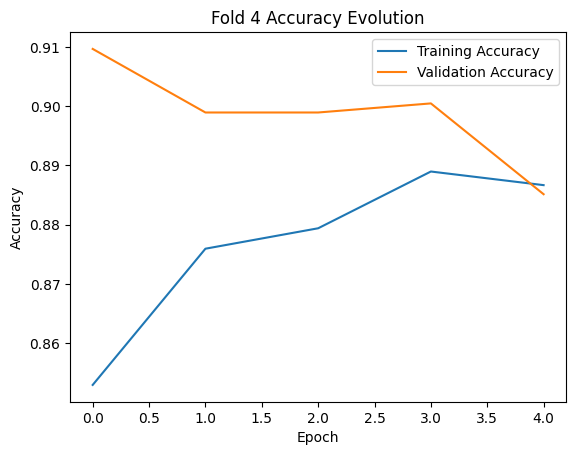

/tmp/ipykernel_6120/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5049    0.9810    0.6667       105
 pituitary_tumor     0.8704    0.6351    0.7344        74
    glioma_tumor     0.6379    0.6435    0.6407       115
        no_tumor     0.7500    0.1500    0.2500       100

        accuracy                         0.6066       394
       macro avg     0.6908    0.6024    0.5729       394
    weighted avg     0.6746    0.6066    0.5660       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8799, train_recall: 0.8813, train_f1: 0.8799, train_accuracy: 0.8813
saved new best metric model
current epoch: 1 current AUC: 0.9892 current accuracy: 0.8882 best AUC: 0.9892 at epoch: 1
Epoch 1 fold 5 val_precision: 0.8960, val_recall: 0.8882, val_f1: 0.8860, val_accuracy: 0.8882
Epoch: 2
Epoch 2 fold 5 train_precision: 0.8785, train_recall: 0.8802, train_f1: 0.8789, train_accuracy: 0.8802
current epoch: 2 current AUC: 0.9875 current accuracy: 0.9112 best AU

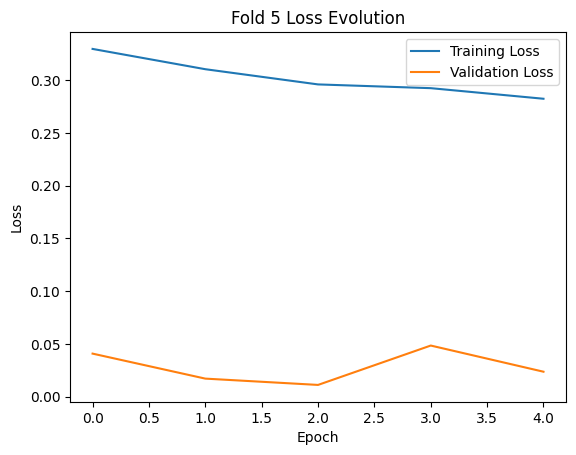

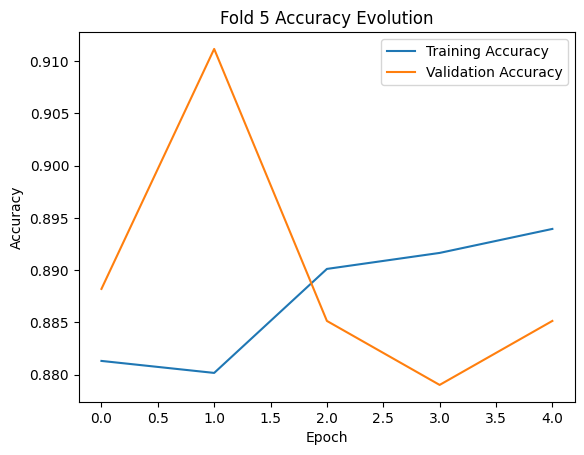

/tmp/ipykernel_6120/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5228    0.9810    0.6821       105
 pituitary_tumor     0.8545    0.6351    0.7287        74
    glioma_tumor     0.6610    0.6783    0.6695       115
        no_tumor     0.6667    0.1600    0.2581       100

        accuracy                         0.6193       394
       macro avg     0.6763    0.6136    0.5846       394
    weighted avg     0.6620    0.6193    0.5796       394

Fold 5 completed.
train_precision: Mean = 0.8314, Std = 0.0651
train_recall: Mean = 0.8331, Std = 0.0649
train_f1: Mean = 0.8311, Std = 0.0661
train_accuracy: Mean = 0.8331, Std = 0.0649
val_precision: Mean = 0.8455, Std = 0.0720
val_recall: Mean = 0.8413, Std = 0.0729
val_f1: Mean = 0.8379, Std = 0.0748
val_accuracy: Mean = 0.8413, Std = 0.0729


In [11]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [12]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_6120/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5228    0.9810    0.6821       105
 pituitary_tumor     0.8545    0.6351    0.7287        74
    glioma_tumor     0.6610    0.6783    0.6695       115
        no_tumor     0.6667    0.1600    0.2581       100

        accuracy                         0.6193       394
       macro avg     0.6763    0.6136    0.5846       394
    weighted avg     0.6620    0.6193    0.5796       394



TASK 3

In [3]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [5]:
import torch
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

/home/melidia/curse/is/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.5225, train_recall: 0.5115, train_f1: 0.4960, train_accuracy: 0.5115
saved new best metric model
current epoch: 1 current AUC: 0.8499 current accuracy: 0.6126 best AUC: 0.8499 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6341, val_recall: 0.6126, val_f1: 0.6084, val_accuracy: 0.6126
Epoch: 2
Epoch 2 fold 1 train_precision: 0.6495, train_recall: 0.6482, train_f1: 0.6423, train_accuracy: 0.6482
saved new best metric model
current epoch: 2 current AUC: 0.8771 current accuracy: 0.6585 best AUC: 0.8771 at epoch: 2
Epoch 2 fold 1 val_precision: 0.6551, val_recall: 0.6585, val_f1: 0.6515, val_accuracy: 0.6585
Epoch: 3
Epoch 3 fold 1 train_precision: 0.6901, train_recall: 0.6933, train_f1: 0.6844, train_accuracy: 0.6933
saved new best metric model
current epoch: 3 current AUC: 0.8913 current accuracy: 0.6876 best AUC: 0.8913 at epoch: 3
Epoch 3 fold 1 val_precision: 0.6968, val_recall: 0.6876, val_f1: 0.6868, val_accuracy: 0.6876
Epoch: 4
Epoch

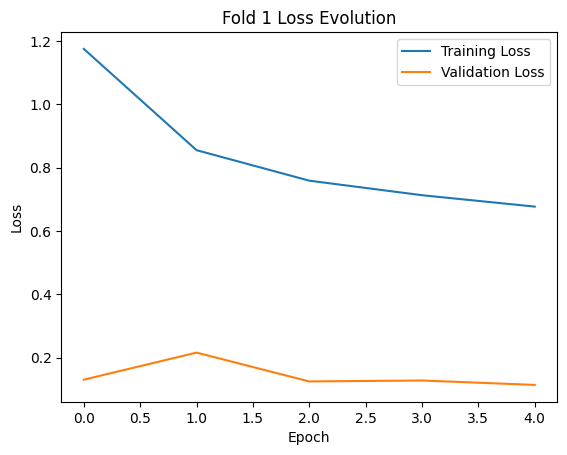

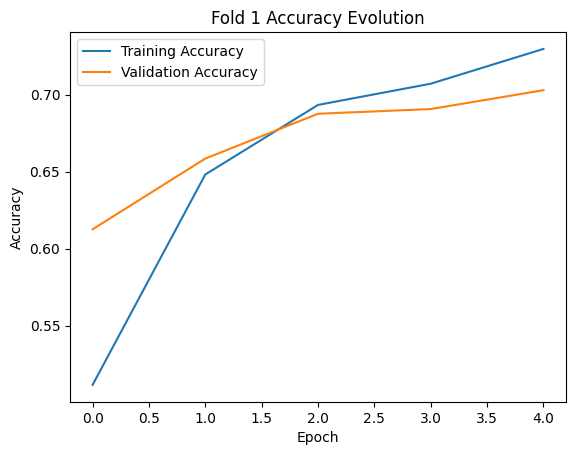

/tmp/ipykernel_30822/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.3361    0.7810    0.4699       105
meningioma_tumor     0.5636    0.4189    0.4806        74
 pituitary_tumor     0.5139    0.3217    0.3957       115
    glioma_tumor     0.4348    0.1000    0.1626       100

        accuracy                         0.4061       394
       macro avg     0.4621    0.4054    0.3772       394
    weighted avg     0.4558    0.4061    0.3723       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.7297, train_recall: 0.7328, train_f1: 0.7268, train_accuracy: 0.7328
saved new best metric model
current epoch: 1 current AUC: 0.9252 current accuracy: 0.7121 best AUC: 0.9252 at epoch: 1
Epoch 1 fold 2 val_precision: 0.7458, val_recall: 0.7121, val_f1: 0.6870, val_accuracy: 0.7121
Epoch: 2
Epoch 2 fold 2 train_precision: 0.7264, train_recall: 0.7312, train_f1: 0.7252, train_accuracy: 0.7312
saved new best metric model
current epoch: 2 current AUC: 0.9282 curr

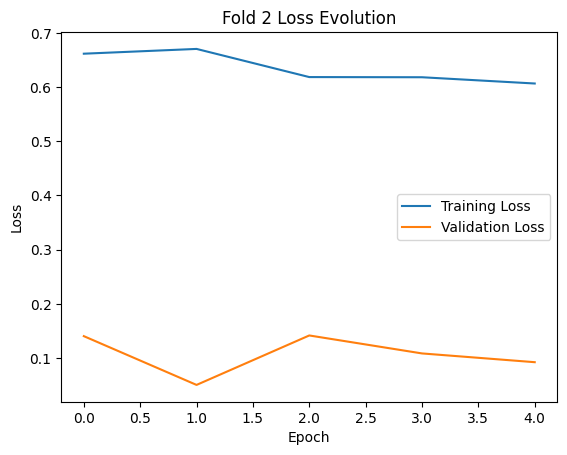

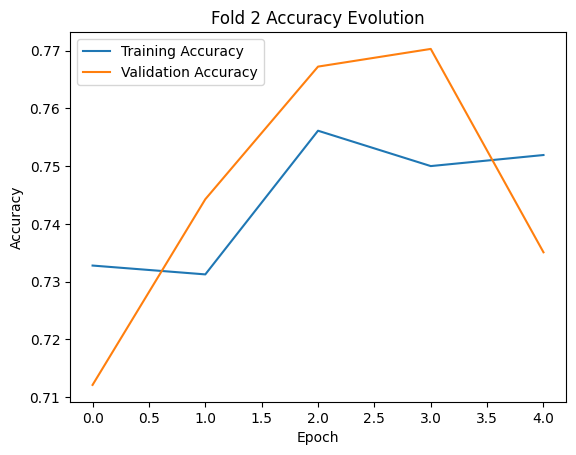

/tmp/ipykernel_30822/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.3646    0.6667    0.4714       105
meningioma_tumor     0.6562    0.2838    0.3962        74
 pituitary_tumor     0.5036    0.6087    0.5512       115
    glioma_tumor     0.3226    0.1000    0.1527       100

        accuracy                         0.4340       394
       macro avg     0.4618    0.4148    0.3929       394
    weighted avg     0.4493    0.4340    0.3997       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.7360, train_recall: 0.7393, train_f1: 0.7348, train_accuracy: 0.7393
saved new best metric model
current epoch: 1 current AUC: 0.9393 current accuracy: 0.7871 best AUC: 0.9393 at epoch: 1
Epoch 1 fold 3 val_precision: 0.7814, val_recall: 0.7871, val_f1: 0.7812, val_accuracy: 0.7871
Epoch: 2
Epoch 2 fold 3 train_precision: 0.7651, train_recall: 0.7695, train_f1: 0.7649, train_accuracy: 0.7695
saved new best metric model
current epoch: 2 current AUC: 0.9405 curr

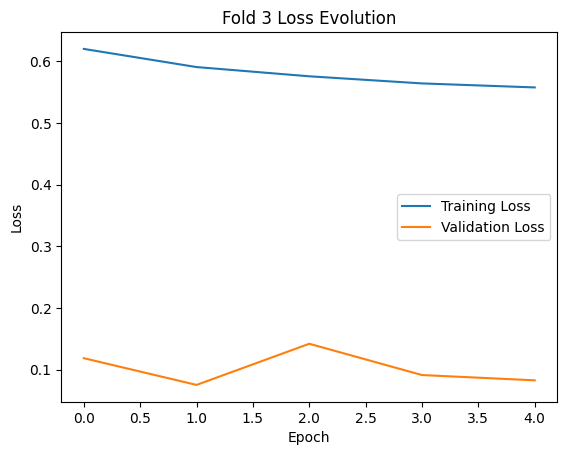

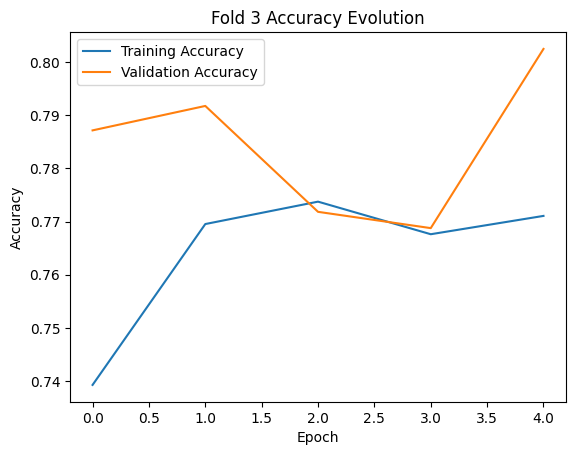

/tmp/ipykernel_30822/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4123    0.8286    0.5506       105
meningioma_tumor     0.6829    0.3784    0.4870        74
 pituitary_tumor     0.5714    0.5913    0.5812       115
    glioma_tumor     0.5217    0.1200    0.1951       100

        accuracy                         0.4949       394
       macro avg     0.5471    0.4796    0.4535       394
    weighted avg     0.5374    0.4949    0.4574       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.7675, train_recall: 0.7711, train_f1: 0.7681, train_accuracy: 0.7711
saved new best metric model
current epoch: 1 current AUC: 0.9553 current accuracy: 0.8315 best AUC: 0.9553 at epoch: 1
Epoch 1 fold 4 val_precision: 0.8329, val_recall: 0.8315, val_f1: 0.8312, val_accuracy: 0.8315
Epoch: 2
Epoch 2 fold 4 train_precision: 0.7803, train_recall: 0.7818, train_f1: 0.7802, train_accuracy: 0.7818
current epoch: 2 current AUC: 0.9512 current accuracy: 0.8116 best AU

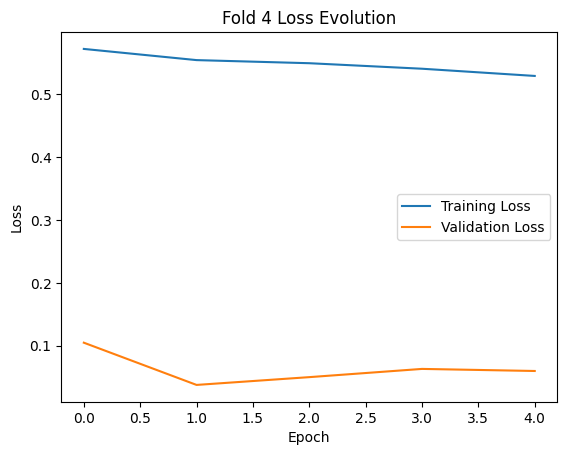

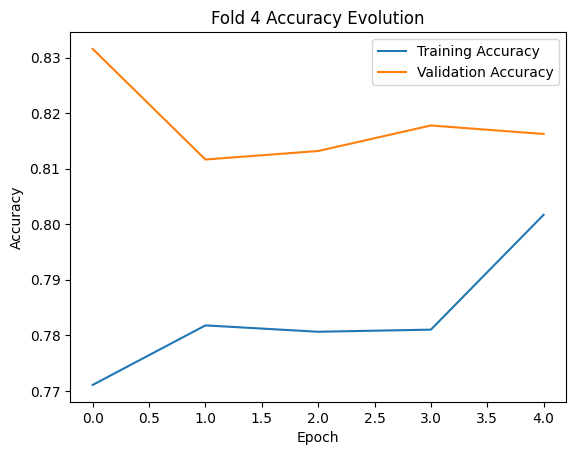

/tmp/ipykernel_30822/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4079    0.8857    0.5586       105
meningioma_tumor     0.6667    0.3514    0.4602        74
 pituitary_tumor     0.6000    0.5478    0.5727       115
    glioma_tumor     0.5909    0.1300    0.2131       100

        accuracy                         0.4949       394
       macro avg     0.5664    0.4787    0.4511       394
    weighted avg     0.5590    0.4949    0.4565       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8003, train_recall: 0.8032, train_f1: 0.8001, train_accuracy: 0.8032
current epoch: 1 current AUC: 0.9461 current accuracy: 0.7917 best AUC: 0.9588 at epoch: 3
Epoch 1 fold 5 val_precision: 0.7874, val_recall: 0.7917, val_f1: 0.7871, val_accuracy: 0.7917
Epoch: 2
Epoch 2 fold 5 train_precision: 0.7950, train_recall: 0.7979, train_f1: 0.7957, train_accuracy: 0.7979
current epoch: 2 current AUC: 0.9417 current accuracy: 0.7626 best AUC: 0.9588 at epoch: 3
Epoch 

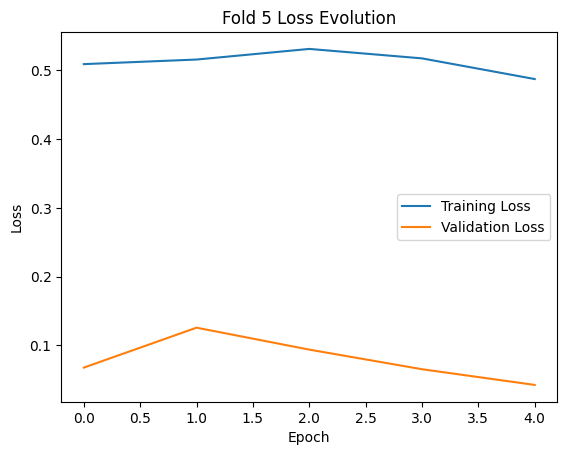

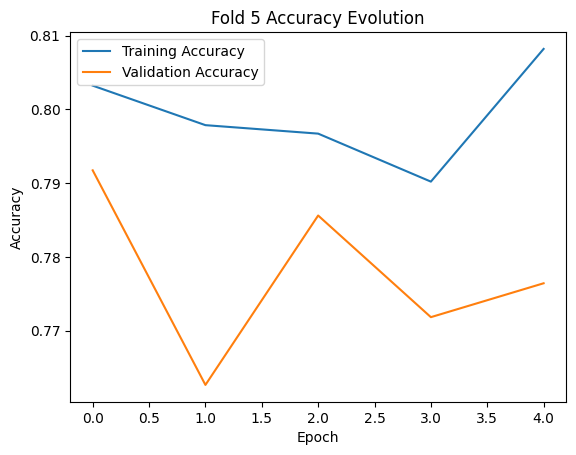

/tmp/ipykernel_30822/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4079    0.8857    0.5586       105
meningioma_tumor     0.6667    0.3514    0.4602        74
 pituitary_tumor     0.6000    0.5478    0.5727       115
    glioma_tumor     0.5909    0.1300    0.2131       100

        accuracy                         0.4949       394
       macro avg     0.5664    0.4787    0.4511       394
    weighted avg     0.5590    0.4949    0.4565       394

Fold 5 completed.
train_precision: Mean = 0.7474, Std = 0.0588
train_recall: Mean = 0.7498, Std = 0.0612
train_f1: Mean = 0.7453, Std = 0.0637
train_accuracy: Mean = 0.7498, Std = 0.0612
val_precision: Mean = 0.7628, Std = 0.0492
val_recall: Mean = 0.7593, Std = 0.0535
val_f1: Mean = 0.7533, Std = 0.0551
val_accuracy: Mean = 0.7593, Std = 0.0535


In [9]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [10]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_30822/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4079    0.8857    0.5586       105
meningioma_tumor     0.6667    0.3514    0.4602        74
 pituitary_tumor     0.6000    0.5478    0.5727       115
    glioma_tumor     0.5909    0.1300    0.2131       100

        accuracy                         0.4949       394
       macro avg     0.5664    0.4787    0.4511       394
    weighted avg     0.5590    0.4949    0.4565       394



In [4]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.RandomVerticalFlip(),
        transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

/home/melidia/curse/is/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.3872, train_recall: 0.3806, train_f1: 0.3795, train_accuracy: 0.3806
saved new best metric model
current epoch: 1 current AUC: 0.7730 current accuracy: 0.3920 best AUC: 0.7730 at epoch: 1
Epoch 1 fold 1 val_precision: 0.5377, val_recall: 0.3920, val_f1: 0.3698, val_accuracy: 0.3920
Epoch: 2
Epoch 2 fold 1 train_precision: 0.5204, train_recall: 0.5123, train_f1: 0.5043, train_accuracy: 0.5123
saved new best metric model
current epoch: 2 current AUC: 0.8024 current accuracy: 0.6003 best AUC: 0.8024 at epoch: 2
Epoch 2 fold 1 val_precision: 0.6246, val_recall: 0.6003, val_f1: 0.5888, val_accuracy: 0.6003
Epoch: 3
Epoch 3 fold 1 train_precision: 0.5981, train_recall: 0.5984, train_f1: 0.5920, train_accuracy: 0.5984
saved new best metric model
current epoch: 3 current AUC: 0.8414 current accuracy: 0.6187 best AUC: 0.8414 at epoch: 3
Epoch 3 fold 1 val_precision: 0.6541, val_recall: 0.6187, val_f1: 0.6080, val_accuracy: 0.6187
Epoch: 4
Epoch

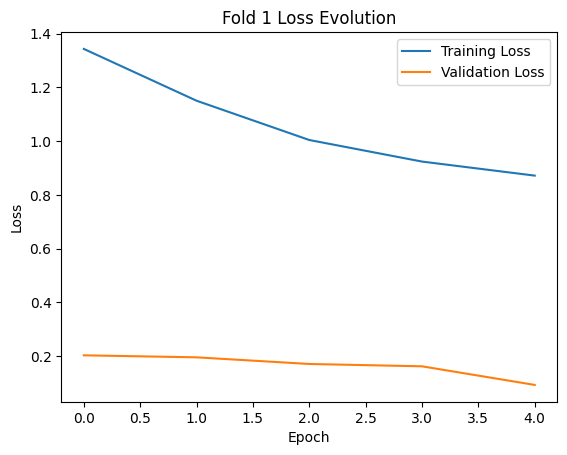

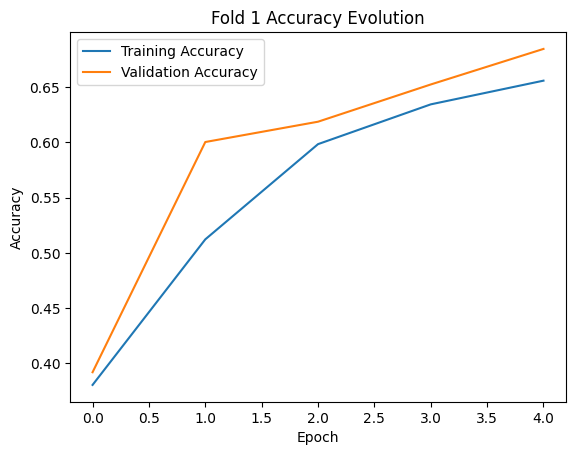

/tmp/ipykernel_10619/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.2822    0.6476    0.3931       105
    glioma_tumor     0.4400    0.2973    0.3548        74
meningioma_tumor     0.2742    0.1478    0.1921       115
 pituitary_tumor     0.3659    0.1500    0.2128       100

        accuracy                         0.3096       394
       macro avg     0.3406    0.3107    0.2882       394
    weighted avg     0.3307    0.3096    0.2815       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.6800, train_recall: 0.6849, train_f1: 0.6771, train_accuracy: 0.6849
saved new best metric model
current epoch: 1 current AUC: 0.9018 current accuracy: 0.6708 best AUC: 0.9018 at epoch: 1
Epoch 1 fold 2 val_precision: 0.6909, val_recall: 0.6708, val_f1: 0.6597, val_accuracy: 0.6708
Epoch: 2
Epoch 2 fold 2 train_precision: 0.6788, train_recall: 0.6842, train_f1: 0.6772, train_accuracy: 0.6842
saved new best metric model
current epoch: 2 current AUC: 0.9158 curr

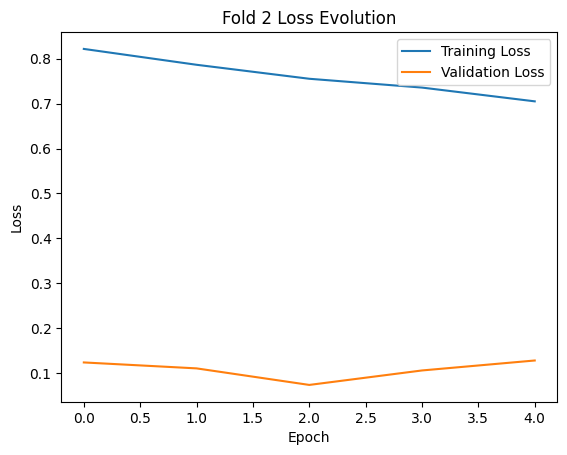

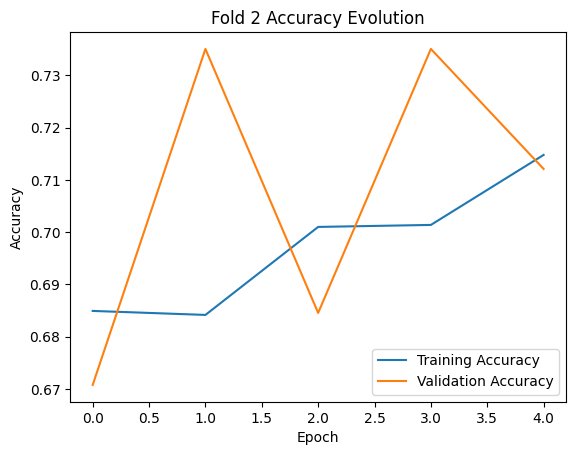

/tmp/ipykernel_10619/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.3285    0.8667    0.4764       105
    glioma_tumor     0.6667    0.2432    0.3564        74
meningioma_tumor     0.3649    0.2348    0.2857       115
 pituitary_tumor     0.6250    0.1000    0.1724       100

        accuracy                         0.3706       394
       macro avg     0.4963    0.3612    0.3228       394
    weighted avg     0.4779    0.3706    0.3211       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.7073, train_recall: 0.7102, train_f1: 0.7077, train_accuracy: 0.7102
saved new best metric model
current epoch: 1 current AUC: 0.9340 current accuracy: 0.7427 best AUC: 0.9340 at epoch: 1
Epoch 1 fold 3 val_precision: 0.7568, val_recall: 0.7427, val_f1: 0.7297, val_accuracy: 0.7427
Epoch: 2
Epoch 2 fold 3 train_precision: 0.7086, train_recall: 0.7129, train_f1: 0.7068, train_accuracy: 0.7129
current epoch: 2 current AUC: 0.9336 current accuracy: 0.7672 best AU

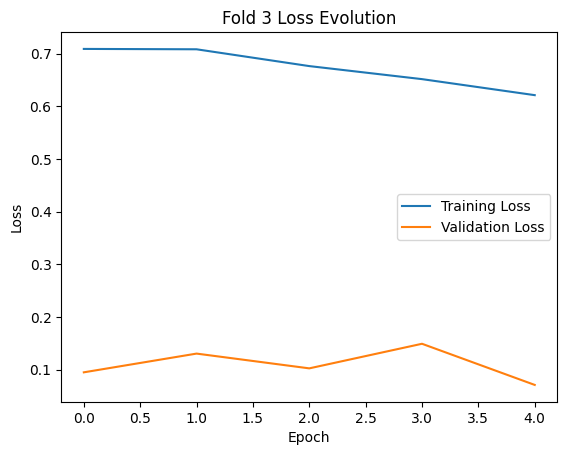

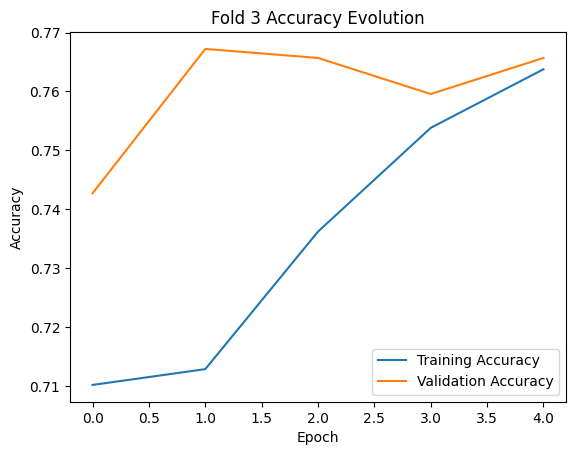

/tmp/ipykernel_10619/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.3708    0.8476    0.5159       105
    glioma_tumor     0.7000    0.2838    0.4038        74
meningioma_tumor     0.5217    0.4174    0.4638       115
 pituitary_tumor     0.5000    0.1600    0.2424       100

        accuracy                         0.4416       394
       macro avg     0.5231    0.4272    0.4065       394
    weighted avg     0.5095    0.4416    0.4102       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.7460, train_recall: 0.7485, train_f1: 0.7463, train_accuracy: 0.7485
saved new best metric model
current epoch: 1 current AUC: 0.9431 current accuracy: 0.7672 best AUC: 0.9431 at epoch: 1
Epoch 1 fold 4 val_precision: 0.8019, val_recall: 0.7672, val_f1: 0.7705, val_accuracy: 0.7672
Epoch: 2
Epoch 2 fold 4 train_precision: 0.7445, train_recall: 0.7477, train_f1: 0.7454, train_accuracy: 0.7477
saved new best metric model
current epoch: 2 current AUC: 0.9436 curr

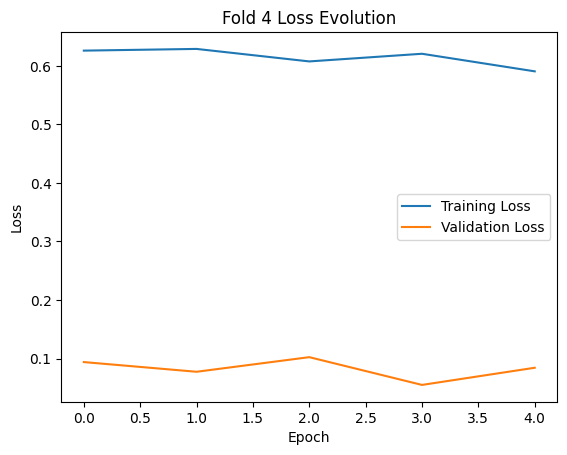

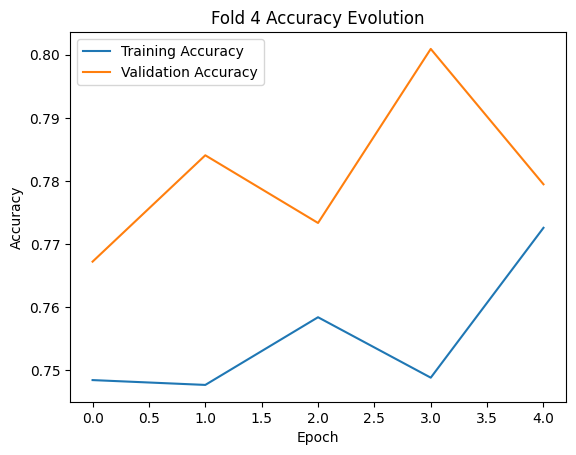

/tmp/ipykernel_10619/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.3571    0.8571    0.5042       105
    glioma_tumor     0.6667    0.3243    0.4364        74
meningioma_tumor     0.5676    0.3652    0.4444       115
 pituitary_tumor     0.5625    0.1800    0.2727       100

        accuracy                         0.4416       394
       macro avg     0.5385    0.4317    0.4144       394
    weighted avg     0.5288    0.4416    0.4153       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.7674, train_recall: 0.7711, train_f1: 0.7678, train_accuracy: 0.7711
saved new best metric model
current epoch: 1 current AUC: 0.9529 current accuracy: 0.8270 best AUC: 0.9529 at epoch: 1
Epoch 1 fold 5 val_precision: 0.8251, val_recall: 0.8270, val_f1: 0.8243, val_accuracy: 0.8270
Epoch: 2
Epoch 2 fold 5 train_precision: 0.7569, train_recall: 0.7607, train_f1: 0.7578, train_accuracy: 0.7607
current epoch: 2 current AUC: 0.9484 current accuracy: 0.7933 best AU

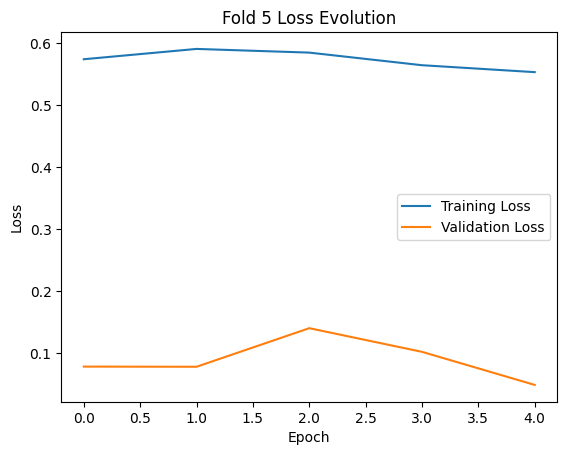

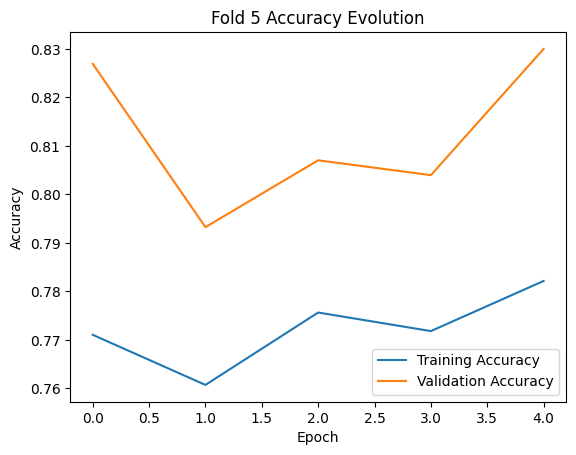

/tmp/ipykernel_10619/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.3525    0.8190    0.4928       105
    glioma_tumor     0.6098    0.3378    0.4348        74
meningioma_tumor     0.5357    0.3913    0.4523       115
 pituitary_tumor     0.5600    0.1400    0.2240       100

        accuracy                         0.4315       394
       macro avg     0.5145    0.4220    0.4010       394
    weighted avg     0.5069    0.4315    0.4019       394

Fold 5 completed.
train_precision: Mean = 0.7007, Std = 0.0883
train_recall: Mean = 0.7033, Std = 0.0905
train_f1: Mean = 0.6992, Std = 0.0913
train_accuracy: Mean = 0.7033, Std = 0.0905
val_precision: Mean = 0.7444, Std = 0.0685
val_recall: Mean = 0.7301, Std = 0.0919
val_f1: Mean = 0.7224, Std = 0.0960
val_accuracy: Mean = 0.7301, Std = 0.0919


In [9]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [10]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_10619/157420012.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.3525    0.8190    0.4928       105
    glioma_tumor     0.6098    0.3378    0.4348        74
meningioma_tumor     0.5357    0.3913    0.4523       115
 pituitary_tumor     0.5600    0.1400    0.2240       100

        accuracy                         0.4315       394
       macro avg     0.5145    0.4220    0.4010       394
    weighted avg     0.5069    0.4315    0.4019       394



In [7]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.RandomRotation(degrees=30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

/home/melidia/curse/is/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.3779, train_recall: 0.3740, train_f1: 0.3652, train_accuracy: 0.3740
saved new best metric model
current epoch: 1 current AUC: 0.7633 current accuracy: 0.5314 best AUC: 0.7633 at epoch: 1
Epoch 1 fold 1 val_precision: 0.5322, val_recall: 0.5314, val_f1: 0.5236, val_accuracy: 0.5314
Epoch: 2
Epoch 2 fold 1 train_precision: 0.5345, train_recall: 0.5341, train_f1: 0.5245, train_accuracy: 0.5341
saved new best metric model
current epoch: 2 current AUC: 0.8271 current accuracy: 0.5789 best AUC: 0.8271 at epoch: 2
Epoch 2 fold 1 val_precision: 0.6406, val_recall: 0.5789, val_f1: 0.5750, val_accuracy: 0.5789
Epoch: 3
Epoch 3 fold 1 train_precision: 0.5860, train_recall: 0.5892, train_f1: 0.5846, train_accuracy: 0.5892
saved new best metric model
current epoch: 3 current AUC: 0.8519 current accuracy: 0.6447 best AUC: 0.8519 at epoch: 3
Epoch 3 fold 1 val_precision: 0.6506, val_recall: 0.6447, val_f1: 0.6372, val_accuracy: 0.6447
Epoch: 4
Epoch

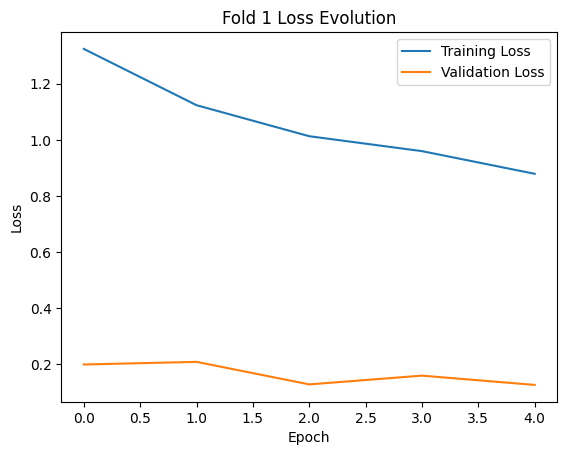

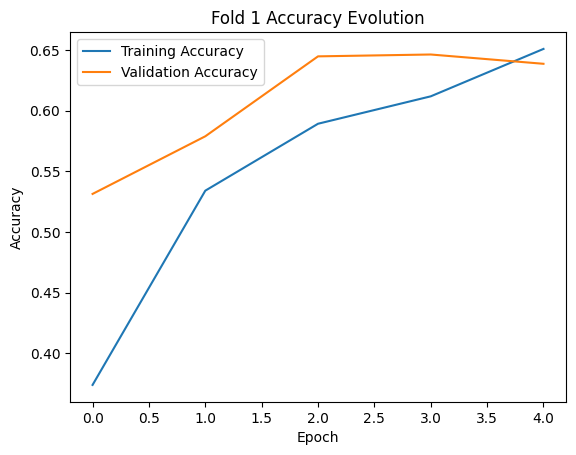

/tmp/ipykernel_12748/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.3206    0.6381    0.4268       105
    glioma_tumor     0.4615    0.4865    0.4737        74
        no_tumor     0.3293    0.2348    0.2741       115
meningioma_tumor     0.4800    0.1200    0.1920       100

        accuracy                         0.3604       394
       macro avg     0.3978    0.3698    0.3416       394
    weighted avg     0.3901    0.3604    0.3314       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.6593, train_recall: 0.6635, train_f1: 0.6587, train_accuracy: 0.6635
saved new best metric model
current epoch: 1 current AUC: 0.8874 current accuracy: 0.6508 best AUC: 0.8874 at epoch: 1
Epoch 1 fold 2 val_precision: 0.6842, val_recall: 0.6508, val_f1: 0.6323, val_accuracy: 0.6508
Epoch: 2
Epoch 2 fold 2 train_precision: 0.6675, train_recall: 0.6704, train_f1: 0.6653, train_accuracy: 0.6704
saved new best metric model
current epoch: 2 current AUC: 0.8923 curr

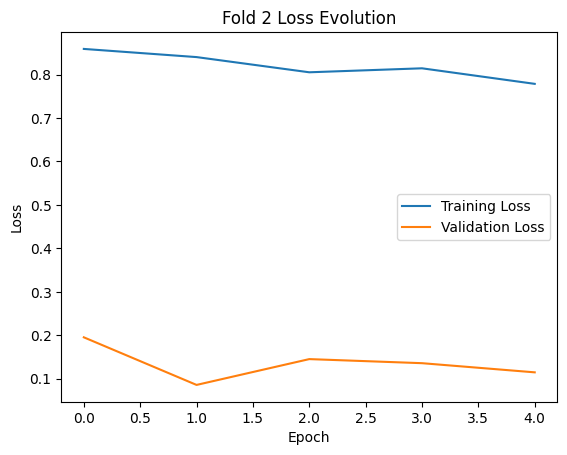

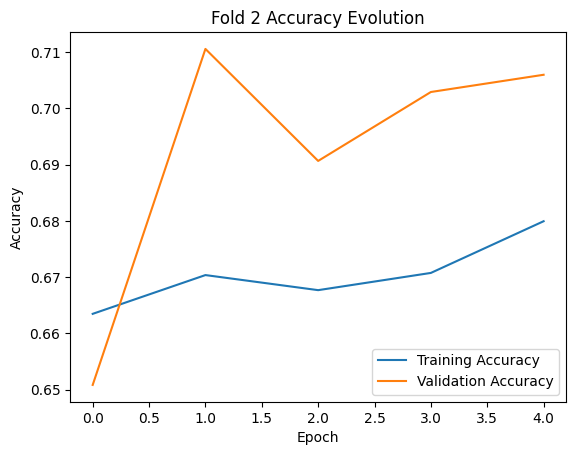

/tmp/ipykernel_12748/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.3222    0.7333    0.4477       105
    glioma_tumor     0.4906    0.3514    0.4094        74
        no_tumor     0.3333    0.1913    0.2431       115
meningioma_tumor     0.3889    0.1400    0.2059       100

        accuracy                         0.3528       394
       macro avg     0.3837    0.3540    0.3265       394
    weighted avg     0.3740    0.3528    0.3194       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.6856, train_recall: 0.6891, train_f1: 0.6851, train_accuracy: 0.6891
saved new best metric model
current epoch: 1 current AUC: 0.9003 current accuracy: 0.7320 best AUC: 0.9003 at epoch: 1
Epoch 1 fold 3 val_precision: 0.7213, val_recall: 0.7320, val_f1: 0.7188, val_accuracy: 0.7320
Epoch: 2
Epoch 2 fold 3 train_precision: 0.6912, train_recall: 0.6960, train_f1: 0.6912, train_accuracy: 0.6960
current epoch: 2 current AUC: 0.8931 current accuracy: 0.6815 best AU

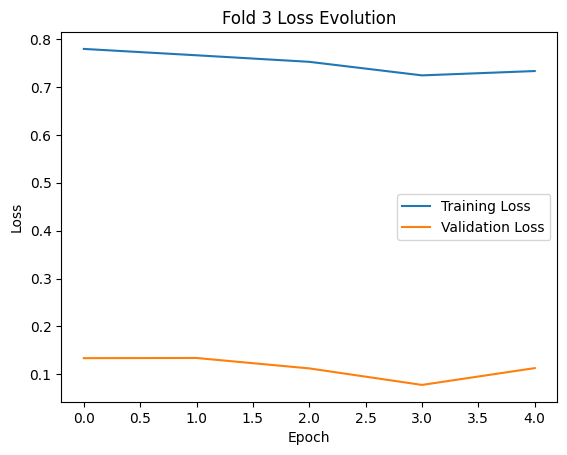

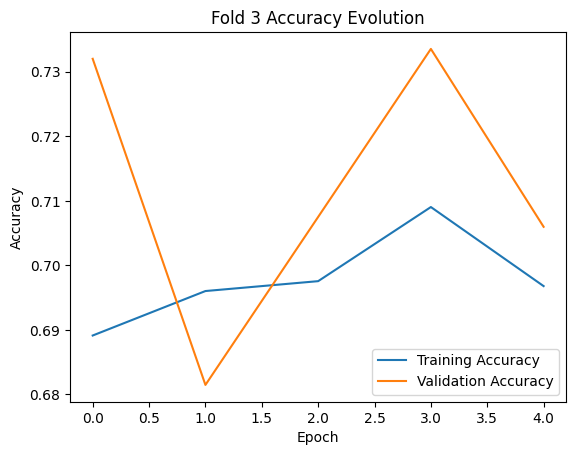

/tmp/ipykernel_12748/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.3243    0.9143    0.4788       105
    glioma_tumor     0.4565    0.2838    0.3500        74
        no_tumor     0.3846    0.0870    0.1418       115
meningioma_tumor     0.4615    0.1200    0.1905       100

        accuracy                         0.3528       394
       macro avg     0.4067    0.3513    0.2903       394
    weighted avg     0.4016    0.3528    0.2831       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.6804, train_recall: 0.6876, train_f1: 0.6801, train_accuracy: 0.6876
saved new best metric model
current epoch: 1 current AUC: 0.9081 current accuracy: 0.7121 best AUC: 0.9081 at epoch: 1
Epoch 1 fold 4 val_precision: 0.7257, val_recall: 0.7121, val_f1: 0.7175, val_accuracy: 0.7121
Epoch: 2
Epoch 2 fold 4 train_precision: 0.6949, train_recall: 0.7018, train_f1: 0.6953, train_accuracy: 0.7018
saved new best metric model
current epoch: 2 current AUC: 0.9106 curr

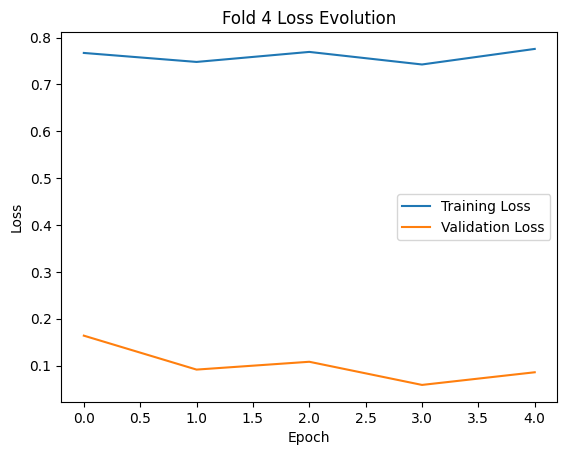

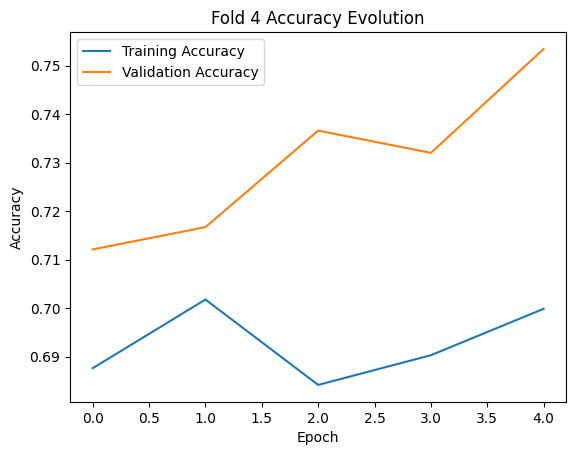

/tmp/ipykernel_12748/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.3248    0.8476    0.4697       105
    glioma_tumor     0.5345    0.4189    0.4697        74
        no_tumor     0.3333    0.1043    0.1589       115
meningioma_tumor     0.4615    0.1200    0.1905       100

        accuracy                         0.3655       394
       macro avg     0.4135    0.3727    0.3222       394
    weighted avg     0.4014    0.3655    0.3081       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.7153, train_recall: 0.7209, train_f1: 0.7147, train_accuracy: 0.7209
current epoch: 1 current AUC: 0.9070 current accuracy: 0.6876 best AUC: 0.9146 at epoch: 5
Epoch 1 fold 5 val_precision: 0.6966, val_recall: 0.6876, val_f1: 0.6839, val_accuracy: 0.6876
Epoch: 2
Epoch 2 fold 5 train_precision: 0.7054, train_recall: 0.7106, train_f1: 0.7059, train_accuracy: 0.7106
current epoch: 2 current AUC: 0.9106 current accuracy: 0.7305 best AUC: 0.9146 at epoch: 5
Epoch 

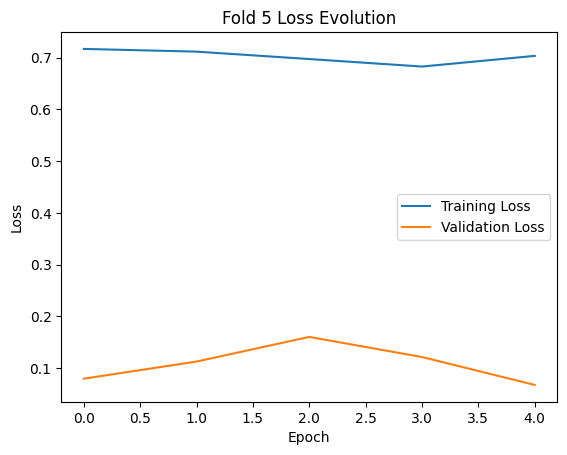

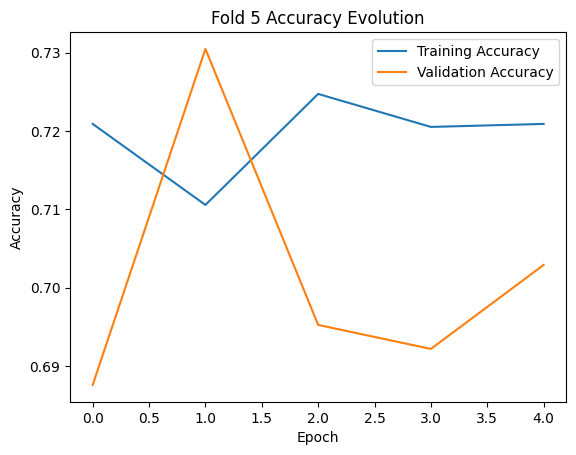

/tmp/ipykernel_12748/1229510081.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.3248    0.8476    0.4697       105
    glioma_tumor     0.5345    0.4189    0.4697        74
        no_tumor     0.3333    0.1043    0.1589       115
meningioma_tumor     0.4615    0.1200    0.1905       100

        accuracy                         0.3655       394
       macro avg     0.4135    0.3727    0.3222       394
    weighted avg     0.4014    0.3655    0.3081       394

Fold 5 completed.
train_precision: Mean = 0.6621, Std = 0.0715
train_recall: Mean = 0.6665, Std = 0.0736
train_f1: Mean = 0.6610, Std = 0.0744
train_accuracy: Mean = 0.6665, Std = 0.0736
val_precision: Mean = 0.6962, Std = 0.0441
val_recall: Mean = 0.6888, Std = 0.0497
val_f1: Mean = 0.6810, Std = 0.0498
val_accuracy: Mean = 0.6888, Std = 0.0497


In [11]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [12]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_12748/157420012.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.3248    0.8476    0.4697       105
    glioma_tumor     0.5345    0.4189    0.4697        74
        no_tumor     0.3333    0.1043    0.1589       115
meningioma_tumor     0.4615    0.1200    0.1905       100

        accuracy                         0.3655       394
       macro avg     0.4135    0.3727    0.3222       394
    weighted avg     0.4014    0.3655    0.3081       394



TASK 4

Fac totul pentru fold-ul nr 1, obtinand pentru acesta cele mai slabe rezultate

In [3]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [4]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.8673, train_recall: 0.8675, train_f1: 0.8669, train_accuracy: 0.8675
saved new best metric model
current epoch: 1 current AUC: 0.9899 current accuracy: 0.8867 best AUC: 0.9899 at epoch: 1
Epoch 1 fold 1 val_precision: 0.9150, val_recall: 0.8867, val_f1: 0.8865, val_accuracy: 0.8867
Epoch: 2
Epoch 2 fold 1 train_precision: 0.8872, train_recall: 0.8886, train_f1: 0.8877, train_accuracy: 0.8886
saved new best metric model
current epoch: 2 current AUC: 0.9912 current accuracy: 0.9250 best AUC: 0.9912 at epoch: 2
Epoch 2 fold 1 val_precision: 0.9283, val_recall: 0.9250, val_f1: 0.9249, val_accuracy: 0.9250
Epoch: 3
Epoch 3 fold 1 train_precision: 0.9044, train_recall: 0.9047, train_f1: 0.9045, train_accuracy: 0.9047
current epoch: 3 current AUC: 0.9887 current accuracy: 0.9173 best AUC: 0.9912 at epoch: 2
Epoch 3 fold 1 val_precision: 0.9173, val_recall: 0.9173, val_f1: 0.9154, val_accuracy: 0.9173
Epoch: 4
Epoch 4 fold 1 train_precision: 0

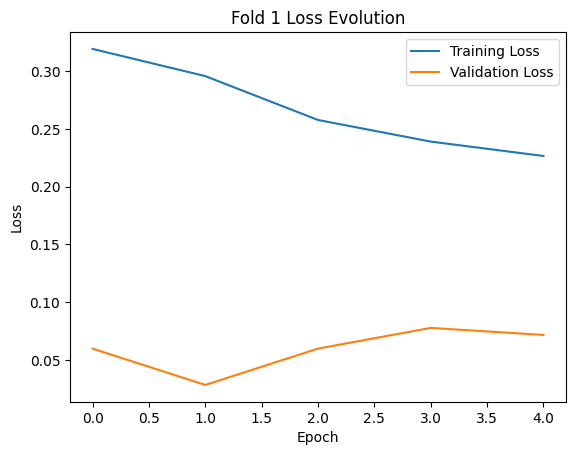

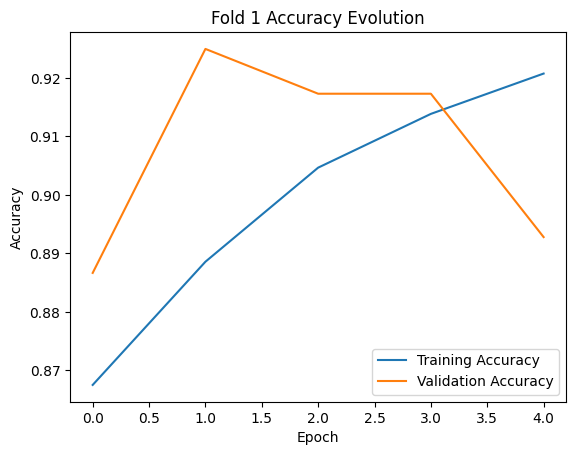

/tmp/ipykernel_8683/37912195.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.5882    0.9524    0.7273       105
meningioma_tumor     0.9362    0.5946    0.7273        74
 pituitary_tumor     0.6447    0.8522    0.7341       115
        no_tumor     0.6000    0.1500    0.2400       100

        accuracy                         0.6523       394
       macro avg     0.6923    0.6373    0.6072       394
    weighted avg     0.6731    0.6523    0.6056       394

Fold 1 completed.
train_precision: Mean = 0.8985, Std = 0.0191
train_recall: Mean = 0.8991, Std = 0.0191
train_f1: Mean = 0.8986, Std = 0.0192
train_accuracy: Mean = 0.8991, Std = 0.0191
val_precision: Mean = 0.9182, Std = 0.0057
val_recall: Mean = 0.9078, Std = 0.0151
val_f1: Mean = 0.9073, Std = 0.0144
val_accuracy: Mean = 0.9078, Std = 0.0151
Fold: 2
train_precision: Mean = 0.8985, Std = 0.0191
train_recall: Mean = 0.8991, Std = 0.0191
train_f1: Mean = 0.8986, Std = 0.0192
train_accuracy: Mean = 0.8991, Std = 0.0191
val_prec

In [12]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")
    if fold == 0:
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
        train_losses, val_losses, val_accuracies = [], [], []
        loss_train, acc_train = [], []
        loss_val, acc_val = [], []
        for epoch in range(5):
            print(f"Epoch: {epoch + 1}")
            model.train()
            epoch_loss = 0.0
            step = 0
            y_train, y_pred = [], []
            for i, (data, label) in enumerate(train_loader):
                step += 1
                data, label = data.to(Device), label.to(Device)
                optimizer.zero_grad()
                output = model(data)
                loss = loss_function(output, label)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                y_train.extend(label.cpu().numpy())
                y_pred.extend(output.argmax(dim=1).cpu().numpy())
                
            epoch_loss /= step
            loss_train.append(epoch_loss)
            
            train_precision = precision_score(y_train, y_pred, average="weighted")
            train_recall = recall_score(y_train, y_pred, average="weighted")
            train_f1 = f1_score(y_train, y_pred, average="weighted")
            train_accuracy = accuracy_score(y_train, y_pred)
            acc_train.append(train_accuracy)

            fold_metrics["train_precision"].append(train_precision)
            fold_metrics["train_recall"].append(train_recall)
            fold_metrics["train_f1"].append(train_f1)
            fold_metrics["train_accuracy"].append(train_accuracy)
            
            print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
            
            if (epoch + 1) % val_interval == 0:
                model.eval()
                val_loss, correct, total = 0.0, 0, 0
                y_pred = torch.tensor([], dtype=torch.float32, device=Device)
                y = torch.tensor([], dtype=torch.long, device=Device)
                y_true_measurements, y_pred_measurements = [], []
                with torch.no_grad():
                    for val_data, val_label in val_loader:
                        val_data, val_label = val_data.to(Device), val_label.to(Device)
                        val_output = model(val_data)
                        val_loss = loss_function(val_output, val_label).item()
                        pred = val_output.argmax(dim=1)
                        correct += torch.eq(pred, val_label).sum().item()
                        total += val_label.size(0)
                        y_pred = torch.cat([y_pred, val_output], 0)
                        y = torch.cat([y, val_label], 0)
                        y_true_measurements.extend(val_label.cpu().numpy())
                        y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                    auc_metric(y_pred_act, y_onehot)
                    result = auc_metric.aggregate()
                    
                    auc_metric.reset()    
                    del y_pred_act, y_onehot
                    metric_values.append(result)
                    acc_value = torch.eq(y_pred.argmax(dim=1), y)
                    acc_metric = acc_value.sum().item() / len(acc_value)
                    if result > best_metric:
                        best_metric = result
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                        f" current accuracy: {acc_metric:.4f}"
                        f" best AUC: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )

                val_loss /= len(val_loader)
                loss_val.append(val_loss)

                precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
                recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
                f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
                accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
        
                acc_val.append(accuracy)    
                fold_metrics["val_precision"].append(precision)
                fold_metrics["val_recall"].append(recall)
                fold_metrics["val_f1"].append(f1)
                fold_metrics["val_accuracy"].append(accuracy)

                print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")

                early_stopping(val_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
                
        plt.figure()
        plt.plot(loss_train, label='Training Loss')
        plt.plot(loss_val, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(acc_train, label='Training Accuracy')
        plt.plot(acc_val, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
        model.eval()
        y_true = []
        y_pred = []
        labelsforknown = {
                'no_tumor',
                'pituitary_tumor',
                'meningioma_tumor',
                'glioma_tumor'
            }
        with torch.no_grad():
            for test_data in test_loader:
                test_images, test_labels = (
                    test_data[0].to(Device),
                    test_data[1].to(Device),
                )
                pred = model(test_images).argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(test_labels[i].item())
                    y_pred.append(pred[i].item())
        print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
                
        print(f"Fold {fold + 1} completed.")

    for key in fold_metrics:
        mean_value = np.mean(fold_metrics[key])
        std_value = np.std(fold_metrics[key])
        print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [13]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_8683/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

    glioma_tumor     0.5882    0.9524    0.7273       105
meningioma_tumor     0.9362    0.5946    0.7273        74
 pituitary_tumor     0.6447    0.8522    0.7341       115
        no_tumor     0.6000    0.1500    0.2400       100

        accuracy                         0.6523       394
       macro avg     0.6923    0.6373    0.6072       394
    weighted avg     0.6731    0.6523    0.6056       394



Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.8846, train_recall: 0.8859, train_f1: 0.8846, train_accuracy: 0.8859
saved new best metric model
current epoch: 1 current AUC: 0.9910 current accuracy: 0.9096 best AUC: 0.9910 at epoch: 1
Epoch 1 fold 1 val_precision: 0.9231, val_recall: 0.9096, val_f1: 0.9111, val_accuracy: 0.9096
Epoch: 2
Epoch 2 fold 1 train_precision: 0.9034, train_recall: 0.9035, train_f1: 0.9035, train_accuracy: 0.9035
current epoch: 2 current AUC: 0.9895 current accuracy: 0.9250 best AUC: 0.9910 at epoch: 1
Epoch 2 fold 1 val_precision: 0.9252, val_recall: 0.9250, val_f1: 0.9242, val_accuracy: 0.9250
Epoch: 3
Epoch 3 fold 1 train_precision: 0.9107, train_recall: 0.9112, train_f1: 0.9106, train_accuracy: 0.9112
current epoch: 3 current AUC: 0.9910 current accuracy: 0.9357 best AUC: 0.9910 at epoch: 1
Epoch 3 fold 1 val_precision: 0.9372, val_recall: 0.9357, val_f1: 0.9362, val_accuracy: 0.9357
Epoch: 4
Epoch 4 fold 1 train_precision: 0.9031, train_recall: 0.9039,

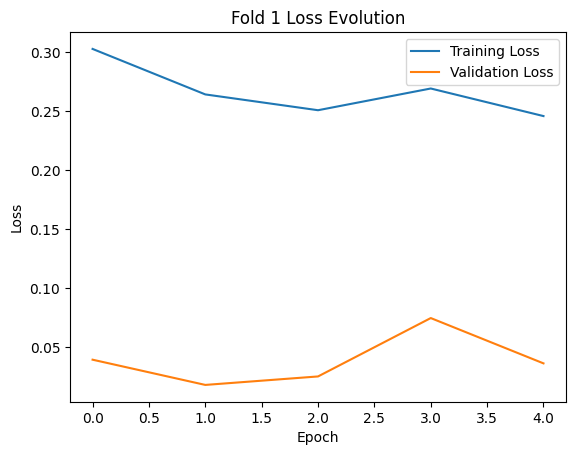

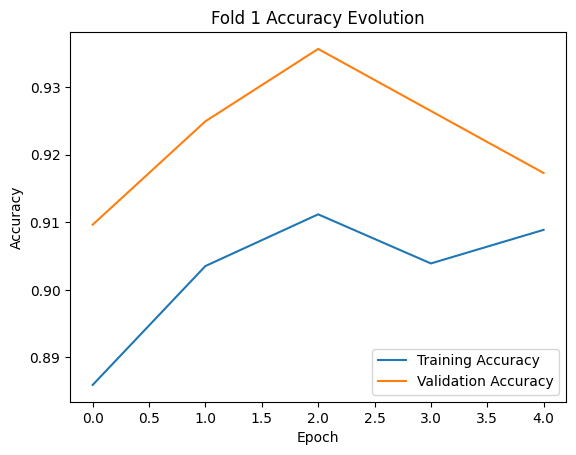

/tmp/ipykernel_11481/4205736048.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5930    0.9714    0.7365       105
    glioma_tumor     0.8462    0.4459    0.5841        74
        no_tumor     0.6108    0.8870    0.7234       115
 pituitary_tumor     0.8125    0.1300    0.2241       100

        accuracy                         0.6345       394
       macro avg     0.7156    0.6086    0.5670       394
    weighted avg     0.7015    0.6345    0.5740       394

Fold 1 completed.
train_precision: Mean = 0.9021, Std = 0.0092
train_recall: Mean = 0.9027, Std = 0.0089
train_f1: Mean = 0.9021, Std = 0.0092
train_accuracy: Mean = 0.9027, Std = 0.0089
val_precision: Mean = 0.9269, Std = 0.0056
val_recall: Mean = 0.9228, Std = 0.0088
val_f1: Mean = 0.9231, Std = 0.0084
val_accuracy: Mean = 0.9228, Std = 0.0088
Fold: 2
train_precision: Mean = 0.9021, Std = 0.0092
train_recall: Mean = 0.9027, Std = 0.0089
train_f1: Mean = 0.9021, Std = 0.0092
train_accuracy: Mean = 0.9027, Std = 0.0089
val_prec

In [11]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")
    if fold == 0:
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
        train_losses, val_losses, val_accuracies = [], [], []
        loss_train, acc_train = [], []
        loss_val, acc_val = [], []
        for epoch in range(5):
            print(f"Epoch: {epoch + 1}")
            model.train()
            epoch_loss = 0.0
            step = 0
            y_train, y_pred = [], []
            for i, (data, label) in enumerate(train_loader):
                step += 1
                data, label = data.to(Device), label.to(Device)
                optimizer.zero_grad()
                output = model(data)
                loss = loss_function(output, label)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                y_train.extend(label.cpu().numpy())
                y_pred.extend(output.argmax(dim=1).cpu().numpy())
                
            epoch_loss /= step
            loss_train.append(epoch_loss)
            
            train_precision = precision_score(y_train, y_pred, average="weighted")
            train_recall = recall_score(y_train, y_pred, average="weighted")
            train_f1 = f1_score(y_train, y_pred, average="weighted")
            train_accuracy = accuracy_score(y_train, y_pred)
            acc_train.append(train_accuracy)

            fold_metrics["train_precision"].append(train_precision)
            fold_metrics["train_recall"].append(train_recall)
            fold_metrics["train_f1"].append(train_f1)
            fold_metrics["train_accuracy"].append(train_accuracy)
            
            print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")

            scheduler.step()
            
            if (epoch + 1) % val_interval == 0:
                model.eval()
                val_loss, correct, total = 0.0, 0, 0
                y_pred = torch.tensor([], dtype=torch.float32, device=Device)
                y = torch.tensor([], dtype=torch.long, device=Device)
                y_true_measurements, y_pred_measurements = [], []
                with torch.no_grad():
                    for val_data, val_label in val_loader:
                        val_data, val_label = val_data.to(Device), val_label.to(Device)
                        val_output = model(val_data)
                        val_loss = loss_function(val_output, val_label).item()
                        pred = val_output.argmax(dim=1)
                        correct += torch.eq(pred, val_label).sum().item()
                        total += val_label.size(0)
                        y_pred = torch.cat([y_pred, val_output], 0)
                        y = torch.cat([y, val_label], 0)
                        y_true_measurements.extend(val_label.cpu().numpy())
                        y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                    auc_metric(y_pred_act, y_onehot)
                    result = auc_metric.aggregate()
                    
                    auc_metric.reset()    
                    del y_pred_act, y_onehot
                    metric_values.append(result)
                    acc_value = torch.eq(y_pred.argmax(dim=1), y)
                    acc_metric = acc_value.sum().item() / len(acc_value)
                    if result > best_metric:
                        best_metric = result
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                        f" current accuracy: {acc_metric:.4f}"
                        f" best AUC: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )

                val_loss /= len(val_loader)
                loss_val.append(val_loss)

                precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
                recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
                f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
                accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
        
                acc_val.append(accuracy)    
                fold_metrics["val_precision"].append(precision)
                fold_metrics["val_recall"].append(recall)
                fold_metrics["val_f1"].append(f1)
                fold_metrics["val_accuracy"].append(accuracy)

                print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
                
        plt.figure()
        plt.plot(loss_train, label='Training Loss')
        plt.plot(loss_val, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(acc_train, label='Training Accuracy')
        plt.plot(acc_val, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
        model.eval()
        y_true = []
        y_pred = []
        labelsforknown = {
                'no_tumor',
                'pituitary_tumor',
                'meningioma_tumor',
                'glioma_tumor'
            }
        with torch.no_grad():
            for test_data in test_loader:
                test_images, test_labels = (
                    test_data[0].to(Device),
                    test_data[1].to(Device),
                )
                pred = model(test_images).argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(test_labels[i].item())
                    y_pred.append(pred[i].item())
        print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
                
        print(f"Fold {fold + 1} completed.")

    for key in fold_metrics:
        mean_value = np.mean(fold_metrics[key])
        std_value = np.std(fold_metrics[key])
        print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [12]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_11481/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5930    0.9714    0.7365       105
    glioma_tumor     0.8462    0.4459    0.5841        74
        no_tumor     0.6108    0.8870    0.7234       115
 pituitary_tumor     0.8125    0.1300    0.2241       100

        accuracy                         0.6345       394
       macro avg     0.7156    0.6086    0.5670       394
    weighted avg     0.7015    0.6345    0.5740       394



Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.8622, train_recall: 0.8633, train_f1: 0.8619, train_accuracy: 0.8633
saved new best metric model
current epoch: 1 current AUC: 0.9828 current accuracy: 0.8606 best AUC: 0.9828 at epoch: 1
Epoch 1 fold 1 val_precision: 0.8795, val_recall: 0.8606, val_f1: 0.8599, val_accuracy: 0.8606
Epoch: 2
Epoch 2 fold 1 train_precision: 0.8792, train_recall: 0.8802, train_f1: 0.8793, train_accuracy: 0.8802
saved new best metric model
current epoch: 2 current AUC: 0.9857 current accuracy: 0.9005 best AUC: 0.9857 at epoch: 2
Epoch 2 fold 1 val_precision: 0.9000, val_recall: 0.9005, val_f1: 0.8975, val_accuracy: 0.9005
Epoch: 3
Epoch 3 fold 1 train_precision: 0.8937, train_recall: 0.8947, train_f1: 0.8940, train_accuracy: 0.8947
saved new best metric model
current epoch: 3 current AUC: 0.9859 current accuracy: 0.9142 best AUC: 0.9859 at epoch: 3
Epoch 3 fold 1 val_precision: 0.9134, val_recall: 0.9142, val_f1: 0.9133, val_accuracy: 0.9142
Epoch: 4
Epoch

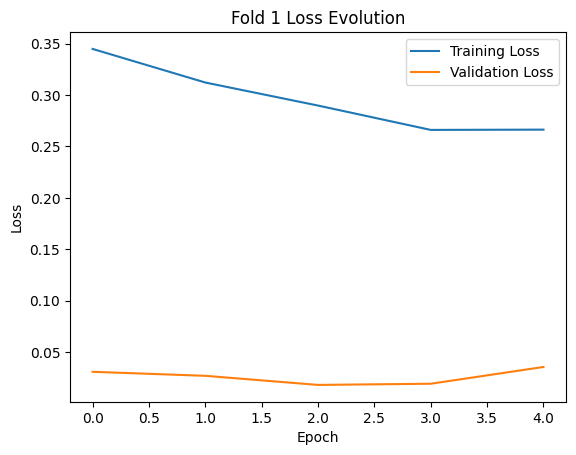

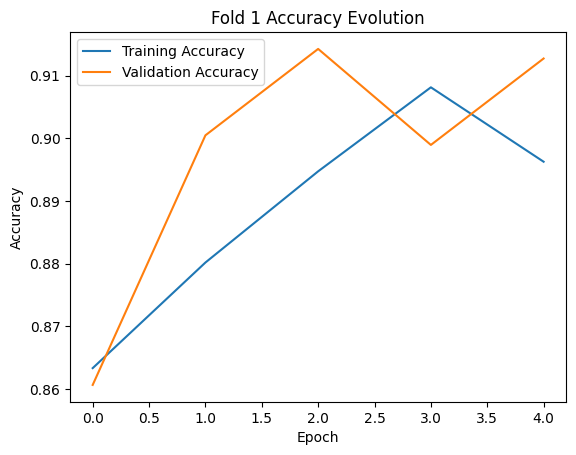

/tmp/ipykernel_6120/854136037.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5622    0.9905    0.7172       105
 pituitary_tumor     0.8824    0.6081    0.7200        74
    glioma_tumor     0.6667    0.8000    0.7273       115
        no_tumor     0.7500    0.1500    0.2500       100

        accuracy                         0.6497       394
       macro avg     0.7153    0.6371    0.6036       394
    weighted avg     0.7005    0.6497    0.6021       394

Fold 1 completed.
Fold: 2
Fold: 3
Fold: 4
Fold: 5
train_precision: Mean = 0.8876, Std = 0.0156
train_recall: Mean = 0.8885, Std = 0.0154
train_f1: Mean = 0.8877, Std = 0.0157
train_accuracy: Mean = 0.8885, Std = 0.0154
val_precision: Mean = 0.9013, Std = 0.0122
val_recall: Mean = 0.8974, Std = 0.0194
val_f1: Mean = 0.8959, Std = 0.0193
val_accuracy: Mean = 0.8974, Std = 0.0194


In [13]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 128
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")
    if fold == 0:

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
        train_losses, val_losses, val_accuracies = [], [], []
        loss_train, acc_train = [], []
        loss_val, acc_val = [], []
        for epoch in range(5):
            print(f"Epoch: {epoch + 1}")
            model.train()
            epoch_loss = 0.0
            step = 0
            y_train, y_pred = [], []
            for i, (data, label) in enumerate(train_loader):
                step += 1
                data, label = data.to(Device), label.to(Device)
                optimizer.zero_grad()
                output = model(data)
                loss = loss_function(output, label)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                y_train.extend(label.cpu().numpy())
                y_pred.extend(output.argmax(dim=1).cpu().numpy())
                
            epoch_loss /= step
            loss_train.append(epoch_loss)
            
            train_precision = precision_score(y_train, y_pred, average="weighted")
            train_recall = recall_score(y_train, y_pred, average="weighted")
            train_f1 = f1_score(y_train, y_pred, average="weighted")
            train_accuracy = accuracy_score(y_train, y_pred)
            acc_train.append(train_accuracy)

            fold_metrics["train_precision"].append(train_precision)
            fold_metrics["train_recall"].append(train_recall)
            fold_metrics["train_f1"].append(train_f1)
            fold_metrics["train_accuracy"].append(train_accuracy)
            
            print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
            
            scheduler.step(val_loss)

            if (epoch + 1) % val_interval == 0:
                model.eval()
                val_loss, correct, total = 0.0, 0, 0
                y_pred = torch.tensor([], dtype=torch.float32, device=Device)
                y = torch.tensor([], dtype=torch.long, device=Device)
                y_true_measurements, y_pred_measurements = [], []
                with torch.no_grad():
                    for val_data, val_label in val_loader:
                        val_data, val_label = val_data.to(Device), val_label.to(Device)
                        val_output = model(val_data)
                        val_loss = loss_function(val_output, val_label).item()
                        pred = val_output.argmax(dim=1)
                        correct += torch.eq(pred, val_label).sum().item()
                        total += val_label.size(0)
                        y_pred = torch.cat([y_pred, val_output], 0)
                        y = torch.cat([y, val_label], 0)
                        y_true_measurements.extend(val_label.cpu().numpy())
                        y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                    auc_metric(y_pred_act, y_onehot)
                    result = auc_metric.aggregate()
                    
                    auc_metric.reset()    
                    del y_pred_act, y_onehot
                    metric_values.append(result)
                    acc_value = torch.eq(y_pred.argmax(dim=1), y)
                    acc_metric = acc_value.sum().item() / len(acc_value)
                    if result > best_metric:
                        best_metric = result
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                        f" current accuracy: {acc_metric:.4f}"
                        f" best AUC: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )

                val_loss /= len(val_loader)
                loss_val.append(val_loss)

                precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
                recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
                f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
                accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
        
                acc_val.append(accuracy)    
                fold_metrics["val_precision"].append(precision)
                fold_metrics["val_recall"].append(recall)
                fold_metrics["val_f1"].append(f1)
                fold_metrics["val_accuracy"].append(accuracy)

                print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
                
        plt.figure()
        plt.plot(loss_train, label='Training Loss')
        plt.plot(loss_val, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(acc_train, label='Training Accuracy')
        plt.plot(acc_val, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy Evolution')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
        model.eval()
        y_true = []
        y_pred = []
        labelsforknown = {
                'no_tumor',
                'pituitary_tumor',
                'meningioma_tumor',
                'glioma_tumor'
            }
        with torch.no_grad():
            for test_data in test_loader:
                test_images, test_labels = (
                    test_data[0].to(Device),
                    test_data[1].to(Device),
                )
                pred = model(test_images).argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(test_labels[i].item())
                    y_pred.append(pred[i].item())
        print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
                
        print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [14]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_6120/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

meningioma_tumor     0.5622    0.9905    0.7172       105
 pituitary_tumor     0.8824    0.6081    0.7200        74
    glioma_tumor     0.6667    0.8000    0.7273       115
        no_tumor     0.7500    0.1500    0.2500       100

        accuracy                         0.6497       394
       macro avg     0.7153    0.6371    0.6036       394
    weighted avg     0.7005    0.6497    0.6021       394



TASK 5

Fold-ul cu cele mai slabe rezultate a fost Fold ul 0 in majoritatea experimentelor efectuate.

Cea mai buna acuratete a modelului am obtinut-o cand am eliminat augmentarile imaginilor (adica doar le am scalat si normalizat, nu am mai aplicat alte efecte asupra lor), in combinatie cu suplimentarea clasei care are foarte putine imagini (no tumor).

Acum, pentru evaluarea modelului, vom modifica diverse aspecte si studia rezultatele

Mai intai, acuratetea a fost de 62%, iar dupa ce am adaugat ReduceLROnPlateau, acuratetea a sarit la 65%.

Schimbarea nr 1: batch size: incerc si alte valori: 256, 512, 64, 32

Pentru batch_size egal 256: 

        precision    recall  f1-score   support

        no_tumor     0.3333    0.6952    0.4506       105
        pituitary_tumor     0.5135    0.2568    0.3423        74
        meningioma_tumor     0.4592    0.3913    0.4225       115
        glioma_tumor     0.3000    0.1200    0.1714       100

        accuracy                         0.3782       394
       macro avg     0.4015    0.3658    0.3467       394
    weighted avg     0.3954    0.3782    0.3512       394

Pentru batch_size egal 512:

        precision    recall  f1-score   support

        no_tumor     0.2989    0.5238    0.3806       105
        pituitary_tumor     0.2766    0.1757    0.2149        74
        meningioma_tumor     0.3680    0.4000    0.3833       115
        glioma_tumor     0.3158    0.1200    0.1739       100

        accuracy                         0.3198       394
       macro avg     0.3148    0.3049    0.2882       394
    weighted avg     0.3192    0.3198    0.2978       394


O valoare prea mare a batch size ului ofera rezultate proaste pe toata acuratetea modelului

Pentru batch_size egal 64:

                  precision    recall  f1-score   support

        no_tumor     0.4973    0.8762    0.6345       105
        pituitary_tumor     0.7179    0.3784    0.4956        74
        meningioma_tumor     0.5127    0.7043    0.5934       115
        glioma_tumor     0.5000    0.0600    0.1071       100

        accuracy                         0.5254       394
       macro avg     0.5570    0.5047    0.4577       394
    weighted avg     0.5439    0.5254    0.4626       394

Valoarea 64 a obtinut rezultate formidabile pentru model, cu o acuratete finala de 64%

Pentru batch_size egal cu 32:

        precision    recall  f1-score   support

        no_tumor     0.4900    0.9333    0.6426       105
        pituitary_tumor     0.8333    0.3378    0.4808        74
        meningioma_tumor     0.5563    0.6870    0.6148       115
        glioma_tumor     0.6364    0.1400    0.2295       100

        accuracy                         0.5482       394
       macro avg     0.6290    0.5245    0.4919       394
    weighted avg     0.6110    0.5482    0.4992       394

Acuratetea finala a modelului a fost de 67%

In [35]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import sklearn

In [36]:
def load_images(path, labels):
  image_files = []
  labels_return = []
  for label in labels:
    for file in os.listdir(os.path.join(path, label)):
      image_files.append(os.path.join(path) + "/" + label + "/" + file)
      labels_return.append(label)
  return image_files, labels_return

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [37]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, 4, kernel_size=4, stride=2, padding=1, dilation=1)
        self.relu1 = nn.ReLU()
        self.avg = nn.MaxPool2d(kernel_size=4, stride=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1, dilation=1)
        self.drop = nn.Dropout(p=0.3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3528, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def name(self):
        return "LeNet"

In [38]:
use_cuda = torch.cuda.is_available()
Device = "cuda"
model = LeNet(1, 4).to(Device)

In [39]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [40]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


In [41]:
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [42]:
from monai.transforms import Activations
from monai.transforms import AsDiscrete

y_pred_trans = transforms.Compose([Activations(softmax=True)])
y_trans = transforms.Compose([AsDiscrete(to_onehot=4)])

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.5609, train_recall: 0.5586, train_f1: 0.5549, train_accuracy: 0.5586
saved new best metric model
current epoch: 1 current AUC: 0.8874 current accuracy: 0.6600 best AUC: 0.8874 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6720, val_recall: 0.6600, val_f1: 0.6396, val_accuracy: 0.6600
Epoch: 2
Epoch 2 fold 1 train_precision: 0.7398, train_recall: 0.7366, train_f1: 0.7327, train_accuracy: 0.7366
saved new best metric model
current epoch: 2 current AUC: 0.9064 current accuracy: 0.7550 best AUC: 0.9064 at epoch: 2
Epoch 2 fold 1 val_precision: 0.7567, val_recall: 0.7550, val_f1: 0.7444, val_accuracy: 0.7550
Epoch: 3
Epoch 3 fold 1 train_precision: 0.7941, train_recall: 0.7929, train_f1: 0.7905, train_accuracy: 0.7929
saved new best metric model
current epoch: 3 current AUC: 0.9280 current accuracy: 0.7703 best AUC: 0.9280 at epoch: 3
Epoch 3 fold 1 val_precision: 0.7746, val_recall: 0.7703, val_f1: 0.7668, val_accuracy: 0.7703
Epoch: 4
Epoch

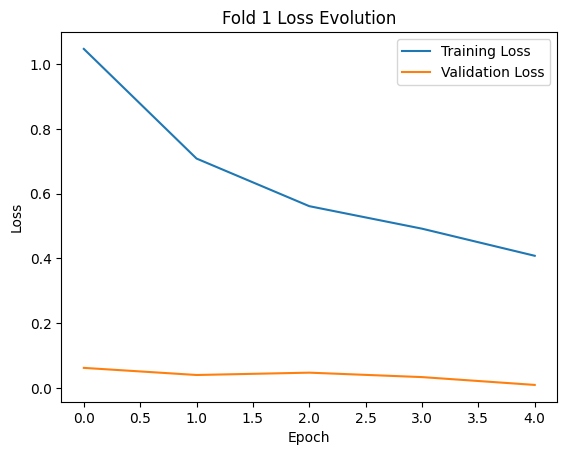

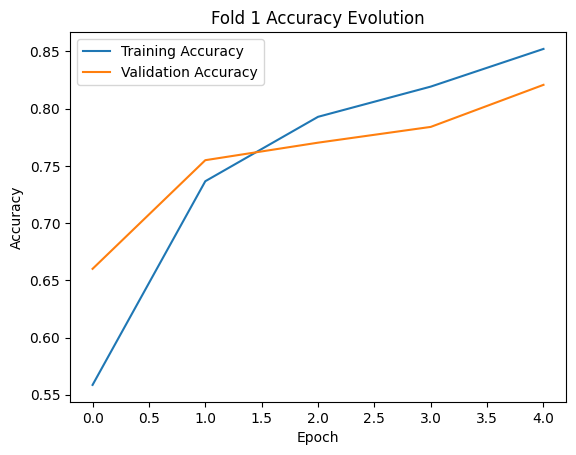

/tmp/ipykernel_1015/423507001.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4900    0.9333    0.6426       105
 pituitary_tumor     0.8333    0.3378    0.4808        74
meningioma_tumor     0.5563    0.6870    0.6148       115
    glioma_tumor     0.6364    0.1400    0.2295       100

        accuracy                         0.5482       394
       macro avg     0.6290    0.5245    0.4919       394
    weighted avg     0.6110    0.5482    0.4992       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.8497, train_recall: 0.8507, train_f1: 0.8496, train_accuracy: 0.8507
saved new best metric model
current epoch: 1 current AUC: 0.9846 current accuracy: 0.8515 best AUC: 0.9846 at epoch: 1
Epoch 1 fold 2 val_precision: 0.8786, val_recall: 0.8515, val_f1: 0.8467, val_accuracy: 0.8515
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8712, train_recall: 0.8714, train_f1: 0.8705, train_accuracy: 0.8714
current epoch: 2 current AUC: 0.9809 current accuracy: 0.8775 best AU

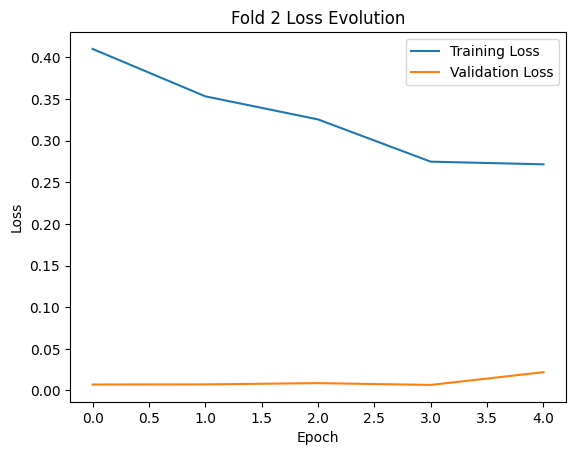

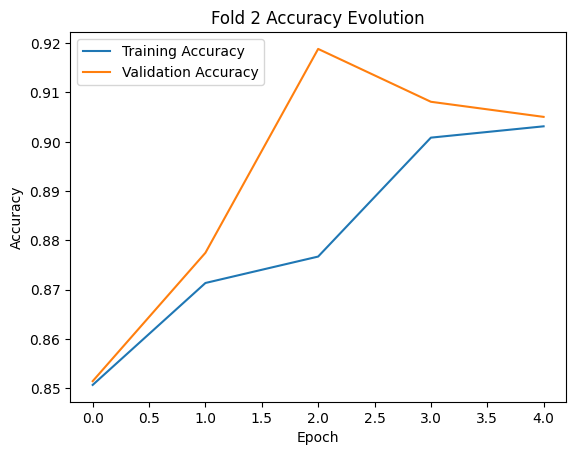

/tmp/ipykernel_1015/423507001.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5829    0.9714    0.7286       105
 pituitary_tumor     0.8824    0.4054    0.5556        74
meningioma_tumor     0.5926    0.8348    0.6931       115
    glioma_tumor     0.7391    0.1700    0.2764       100

        accuracy                         0.6218       394
       macro avg     0.6992    0.5954    0.5634       394
    weighted avg     0.6816    0.6218    0.5710       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8906, train_recall: 0.8909, train_f1: 0.8905, train_accuracy: 0.8909
saved new best metric model
current epoch: 1 current AUC: 0.9941 current accuracy: 0.9464 best AUC: 0.9941 at epoch: 1
Epoch 1 fold 3 val_precision: 0.9475, val_recall: 0.9464, val_f1: 0.9458, val_accuracy: 0.9464
Epoch: 2
Epoch 2 fold 3 train_precision: 0.9047, train_recall: 0.9047, train_f1: 0.9045, train_accuracy: 0.9047
current epoch: 2 current AUC: 0.9910 current accuracy: 0.9403 best AU

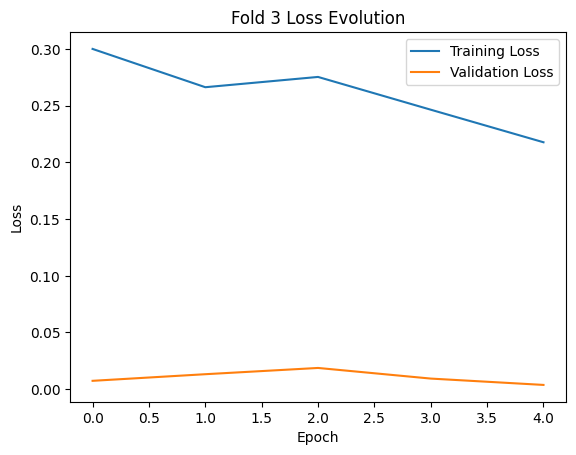

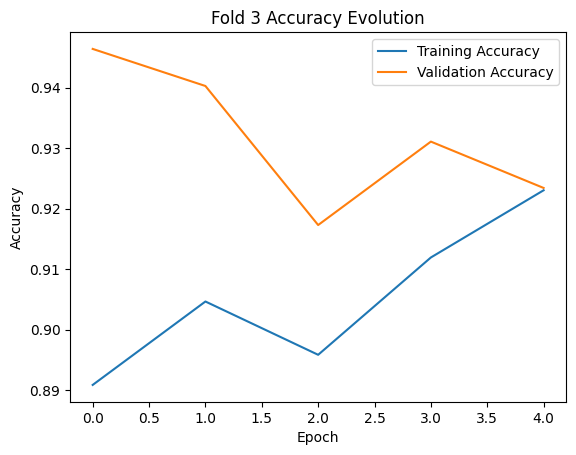

/tmp/ipykernel_1015/423507001.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6173    0.9524    0.7491       105
 pituitary_tumor     0.8511    0.5405    0.6612        74
meningioma_tumor     0.6541    0.9043    0.7591       115
    glioma_tumor     0.7308    0.1900    0.3016       100

        accuracy                         0.6675       394
       macro avg     0.7133    0.6468    0.6177       394
    weighted avg     0.7007    0.6675    0.6219       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8907, train_recall: 0.8909, train_f1: 0.8906, train_accuracy: 0.8909
saved new best metric model
current epoch: 1 current AUC: 0.9948 current accuracy: 0.9433 best AUC: 0.9948 at epoch: 1
Epoch 1 fold 4 val_precision: 0.9441, val_recall: 0.9433, val_f1: 0.9428, val_accuracy: 0.9433
Epoch: 2
Epoch 2 fold 4 train_precision: 0.9047, train_recall: 0.9047, train_f1: 0.9045, train_accuracy: 0.9047
current epoch: 2 current AUC: 0.9935 current accuracy: 0.9464 best AU

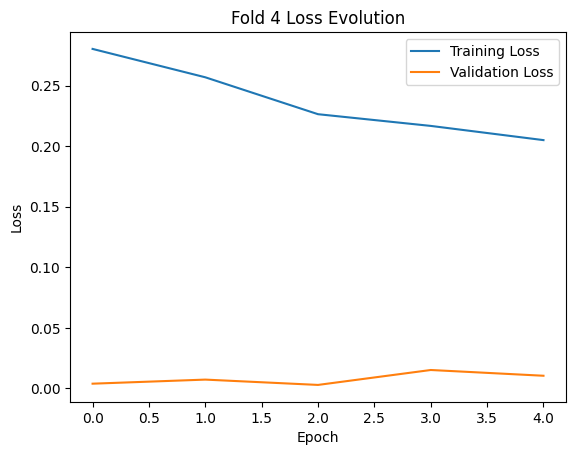

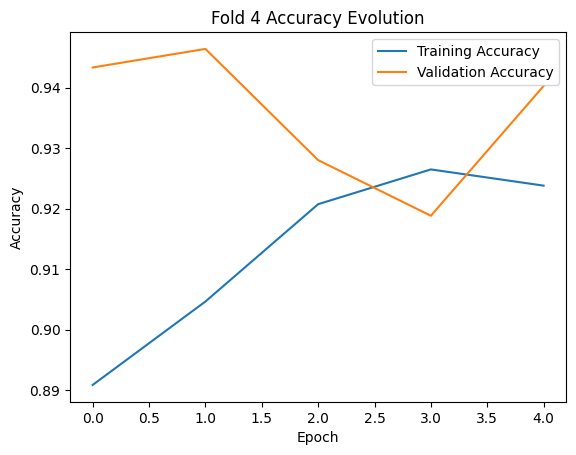

/tmp/ipykernel_1015/423507001.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6061    0.9524    0.7407       105
 pituitary_tumor     0.8200    0.5541    0.6613        74
meningioma_tumor     0.6561    0.8957    0.7574       115
    glioma_tumor     0.8182    0.1800    0.2951       100

        accuracy                         0.6650       394
       macro avg     0.7251    0.6455    0.6136       394
    weighted avg     0.7147    0.6650    0.6176       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.9086, train_recall: 0.9089, train_f1: 0.9086, train_accuracy: 0.9089
current epoch: 1 current AUC: 0.9947 current accuracy: 0.9418 best AUC: 0.9948 at epoch: 1
Epoch 1 fold 5 val_precision: 0.9429, val_recall: 0.9418, val_f1: 0.9416, val_accuracy: 0.9418
Epoch: 2
Epoch 2 fold 5 train_precision: 0.9335, train_recall: 0.9338, train_f1: 0.9335, train_accuracy: 0.9338
saved new best metric model
current epoch: 2 current AUC: 0.9958 current accuracy: 0.9464 best AU

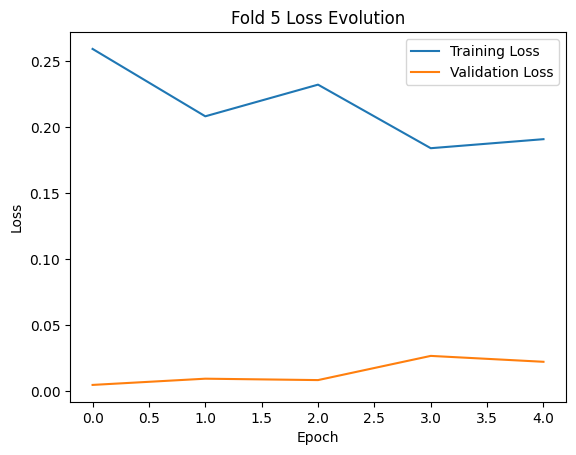

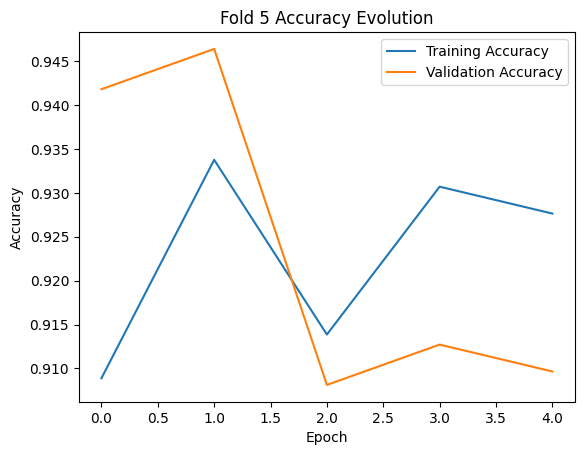

/tmp/ipykernel_1015/423507001.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5941    0.9619    0.7345       105
 pituitary_tumor     0.9524    0.5405    0.6897        74
meningioma_tumor     0.6485    0.9304    0.7643       115
    glioma_tumor     0.9412    0.1600    0.2735       100

        accuracy                         0.6701       394
       macro avg     0.7840    0.6482    0.6155       394
    weighted avg     0.7654    0.6701    0.6178       394

Fold 5 completed.
train_precision: Mean = 0.8749, Std = 0.0786
train_recall: Mean = 0.8748, Std = 0.0793
train_f1: Mean = 0.8740, Std = 0.0802
train_accuracy: Mean = 0.8748, Std = 0.0793
val_precision: Mean = 0.8918, Std = 0.0708
val_recall: Mean = 0.8882, Std = 0.0725
val_f1: Mean = 0.8861, Std = 0.0762
val_accuracy: Mean = 0.8882, Std = 0.0725


In [43]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 32
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [44]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_1015/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5941    0.9619    0.7345       105
 pituitary_tumor     0.9524    0.5405    0.6897        74
meningioma_tumor     0.6485    0.9304    0.7643       115
    glioma_tumor     0.9412    0.1600    0.2735       100

        accuracy                         0.6701       394
       macro avg     0.7840    0.6482    0.6155       394
    weighted avg     0.7654    0.6701    0.6178       394



Urmatorul lucru este sa modificam optimizerul: Adam, SGD, RMSprop

Mai intai, inmultim cu 10 rata de invatare la Adam

Obtinem urmatoarele rezultate:

        precision    recall  f1-score   support

        no_tumor     0.4836    0.9810    0.6478       105
        pituitary_tumor     0.9111    0.5541    0.6891        74
        meningioma_tumor     0.6087    0.6087    0.6087       115
        glioma_tumor     0.8571    0.1800    0.2975       100

        accuracy                         0.5888       394
       macro avg     0.7151    0.5809    0.5608       394
    weighted avg     0.6952    0.5888    0.5552       394


In [47]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import sklearn

In [48]:
def load_images(path, labels):
  image_files = []
  labels_return = []
  for label in labels:
    for file in os.listdir(os.path.join(path, label)):
      image_files.append(os.path.join(path) + "/" + label + "/" + file)
      labels_return.append(label)
  return image_files, labels_return

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [49]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, 4, kernel_size=4, stride=2, padding=1, dilation=1)
        self.relu1 = nn.ReLU()
        self.avg = nn.MaxPool2d(kernel_size=4, stride=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1, dilation=1)
        self.drop = nn.Dropout(p=0.3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3528, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def name(self):
        return "LeNet"

In [50]:
use_cuda = torch.cuda.is_available()
Device = "cuda"
model = LeNet(1, 4).to(Device)

In [51]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [52]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


In [53]:
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [54]:
from monai.transforms import Activations
from monai.transforms import AsDiscrete

y_pred_trans = transforms.Compose([Activations(softmax=True)])
y_trans = transforms.Compose([AsDiscrete(to_onehot=4)])

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.5823, train_recall: 0.5842, train_f1: 0.5799, train_accuracy: 0.5842
saved new best metric model
current epoch: 1 current AUC: 0.9146 current accuracy: 0.7366 best AUC: 0.9146 at epoch: 1
Epoch 1 fold 1 val_precision: 0.7311, val_recall: 0.7366, val_f1: 0.7256, val_accuracy: 0.7366
Epoch: 2
Epoch 2 fold 1 train_precision: 0.7499, train_recall: 0.7523, train_f1: 0.7495, train_accuracy: 0.7523
saved new best metric model
current epoch: 2 current AUC: 0.9348 current accuracy: 0.7825 best AUC: 0.9348 at epoch: 2
Epoch 2 fold 1 val_precision: 0.7832, val_recall: 0.7825, val_f1: 0.7813, val_accuracy: 0.7825
Epoch: 3
Epoch 3 fold 1 train_precision: 0.8070, train_recall: 0.8078, train_f1: 0.8067, train_accuracy: 0.8078
saved new best metric model
current epoch: 3 current AUC: 0.9390 current accuracy: 0.8070 best AUC: 0.9390 at epoch: 3
Epoch 3 fold 1 val_precision: 0.8032, val_recall: 0.8070, val_f1: 0.7986, val_accuracy: 0.8070
Epoch: 4
Epoch

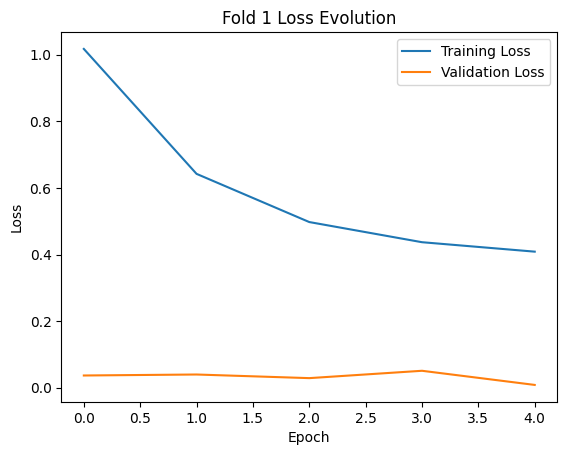

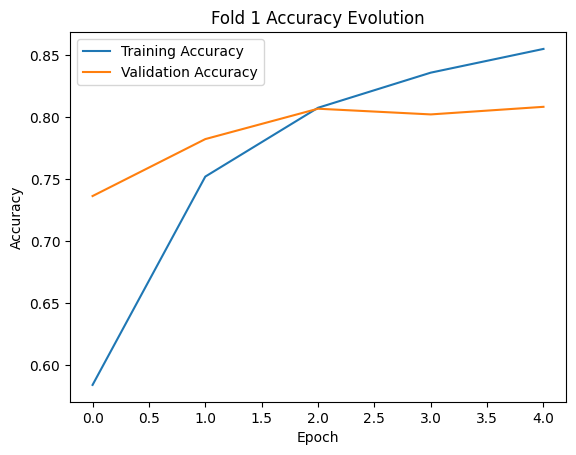

/tmp/ipykernel_1015/187611357.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4836    0.9810    0.6478       105
 pituitary_tumor     0.9111    0.5541    0.6891        74
meningioma_tumor     0.6087    0.6087    0.6087       115
    glioma_tumor     0.8571    0.1800    0.2975       100

        accuracy                         0.5888       394
       macro avg     0.7151    0.5809    0.5608       394
    weighted avg     0.6952    0.5888    0.5552       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.8298, train_recall: 0.8308, train_f1: 0.8301, train_accuracy: 0.8308
saved new best metric model
current epoch: 1 current AUC: 0.9860 current accuracy: 0.9112 best AUC: 0.9860 at epoch: 1
Epoch 1 fold 2 val_precision: 0.9107, val_recall: 0.9112, val_f1: 0.9101, val_accuracy: 0.9112
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8565, train_recall: 0.8572, train_f1: 0.8566, train_accuracy: 0.8572
current epoch: 2 current AUC: 0.9845 current accuracy: 0.9005 best AU

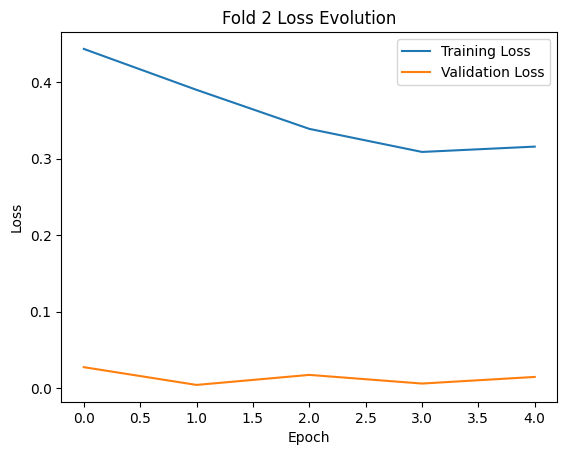

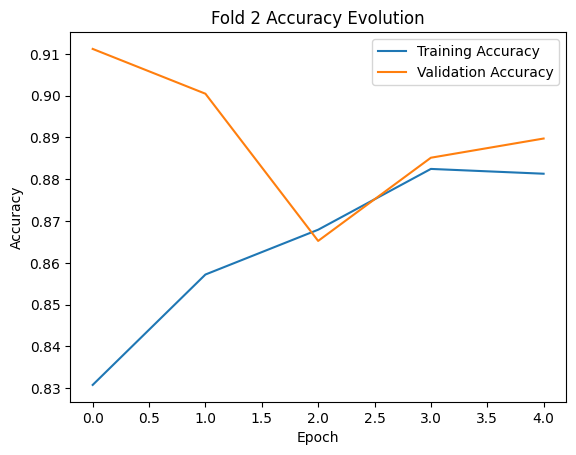

/tmp/ipykernel_1015/187611357.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5503    0.9905    0.7075       105
 pituitary_tumor     0.7419    0.6216    0.6765        74
meningioma_tumor     0.7500    0.7304    0.7401       115
    glioma_tumor     0.6774    0.2100    0.3206       100

        accuracy                         0.6472       394
       macro avg     0.6799    0.6381    0.6112       394
    weighted avg     0.6768    0.6472    0.6130       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8692, train_recall: 0.8698, train_f1: 0.8694, train_accuracy: 0.8698
saved new best metric model
current epoch: 1 current AUC: 0.9943 current accuracy: 0.9495 best AUC: 0.9943 at epoch: 1
Epoch 1 fold 3 val_precision: 0.9514, val_recall: 0.9495, val_f1: 0.9492, val_accuracy: 0.9495
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8824, train_recall: 0.8832, train_f1: 0.8827, train_accuracy: 0.8832
current epoch: 2 current AUC: 0.9915 current accuracy: 0.9234 best AU

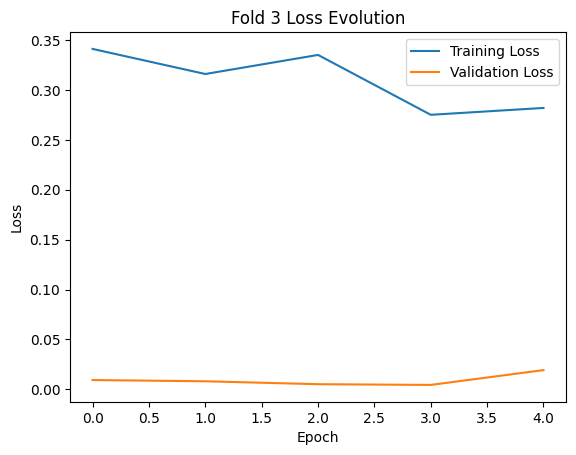

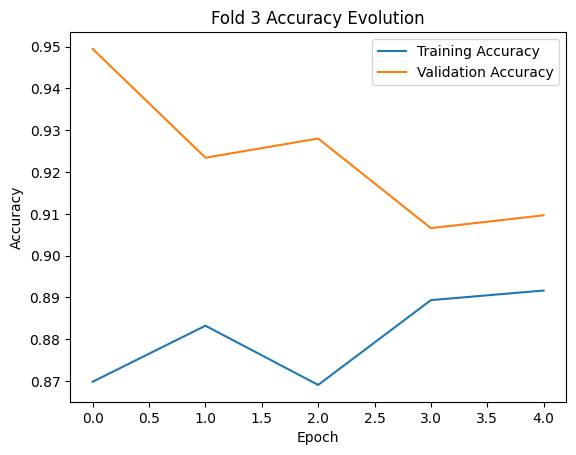

/tmp/ipykernel_1015/187611357.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5876    0.9905    0.7376       105
 pituitary_tumor     0.8966    0.7027    0.7879        74
meningioma_tumor     0.6783    0.8435    0.7519       115
    glioma_tumor     0.9375    0.1500    0.2586       100

        accuracy                         0.6802       394
       macro avg     0.7750    0.6717    0.6340       394
    weighted avg     0.7609    0.6802    0.6297       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8708, train_recall: 0.8717, train_f1: 0.8712, train_accuracy: 0.8717
current epoch: 1 current AUC: 0.9892 current accuracy: 0.9127 best AUC: 0.9943 at epoch: 1
Epoch 1 fold 4 val_precision: 0.9205, val_recall: 0.9127, val_f1: 0.9091, val_accuracy: 0.9127
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8908, train_recall: 0.8913, train_f1: 0.8909, train_accuracy: 0.8913
current epoch: 2 current AUC: 0.9895 current accuracy: 0.9112 best AUC: 0.9943 at epoch: 1
Epoch 

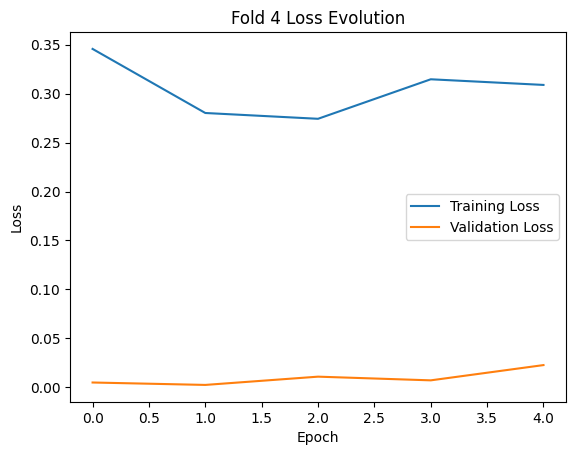

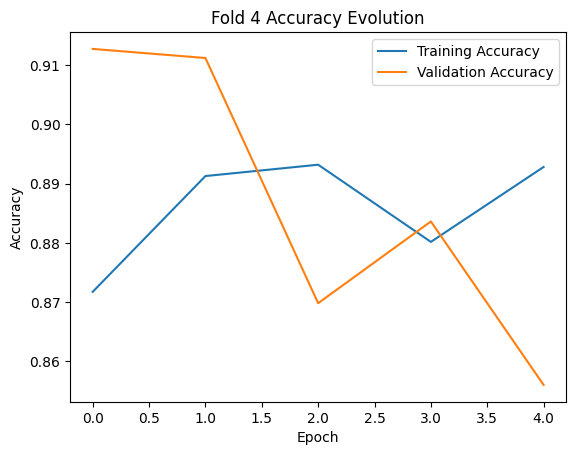

/tmp/ipykernel_1015/187611357.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5876    0.9905    0.7376       105
 pituitary_tumor     0.8966    0.7027    0.7879        74
meningioma_tumor     0.6783    0.8435    0.7519       115
    glioma_tumor     0.9375    0.1500    0.2586       100

        accuracy                         0.6802       394
       macro avg     0.7750    0.6717    0.6340       394
    weighted avg     0.7609    0.6802    0.6297       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8698, train_recall: 0.8706, train_f1: 0.8702, train_accuracy: 0.8706
current epoch: 1 current AUC: 0.9895 current accuracy: 0.9066 best AUC: 0.9943 at epoch: 1
Epoch 1 fold 5 val_precision: 0.9067, val_recall: 0.9066, val_f1: 0.9062, val_accuracy: 0.9066
Epoch: 2
Epoch 2 fold 5 train_precision: 0.8833, train_recall: 0.8840, train_f1: 0.8834, train_accuracy: 0.8840
current epoch: 2 current AUC: 0.9852 current accuracy: 0.9112 best AUC: 0.9943 at epoch: 1
Epoch 

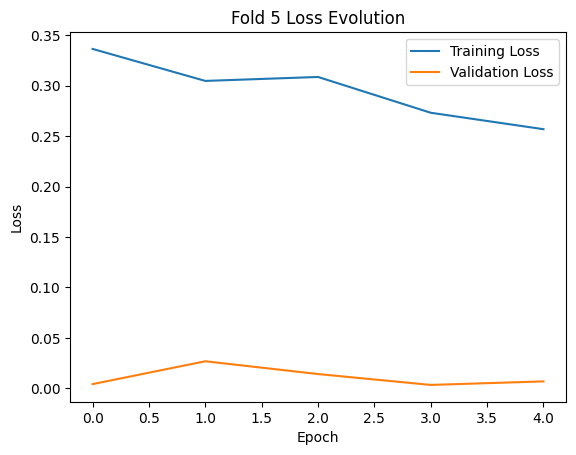

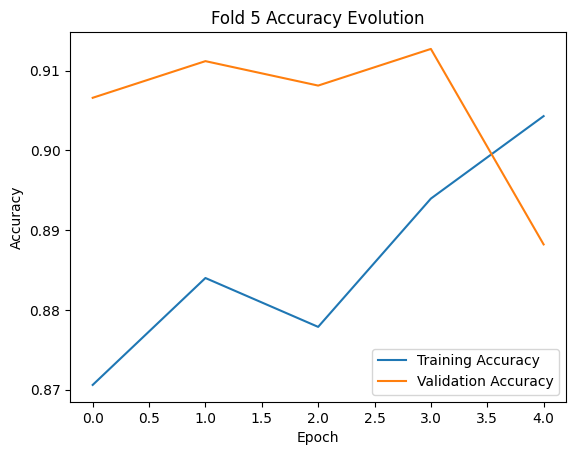

/tmp/ipykernel_1015/187611357.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5876    0.9905    0.7376       105
 pituitary_tumor     0.8966    0.7027    0.7879        74
meningioma_tumor     0.6783    0.8435    0.7519       115
    glioma_tumor     0.9375    0.1500    0.2586       100

        accuracy                         0.6802       394
       macro avg     0.7750    0.6717    0.6340       394
    weighted avg     0.7609    0.6802    0.6297       394

Fold 5 completed.
train_precision: Mean = 0.8560, Std = 0.0646
train_recall: Mean = 0.8567, Std = 0.0642
train_f1: Mean = 0.8560, Std = 0.0651
train_accuracy: Mean = 0.8567, Std = 0.0642
val_precision: Mean = 0.8811, Std = 0.0526
val_recall: Mean = 0.8787, Std = 0.0510
val_f1: Mean = 0.8761, Std = 0.0533
val_accuracy: Mean = 0.8787, Std = 0.0510


In [55]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 32
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [56]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_1015/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5876    0.9905    0.7376       105
 pituitary_tumor     0.8966    0.7027    0.7879        74
meningioma_tumor     0.6783    0.8435    0.7519       115
    glioma_tumor     0.9375    0.1500    0.2586       100

        accuracy                         0.6802       394
       macro avg     0.7750    0.6717    0.6340       394
    weighted avg     0.7609    0.6802    0.6297       394



Incercam sa modificam cu SGD ul

Cu LR=0.01, avem rezultatele:

        precision    recall  f1-score   support

        no_tumor     0.3593    0.5714    0.4412       105
        pituitary_tumor     0.2540    0.2162    0.2336        74
        meningioma_tumor     0.4504    0.5130    0.4797       115
        glioma_tumor     0.3030    0.1000    0.1504       100

        accuracy                         0.3680       394
       macro avg     0.3417    0.3502    0.3262       394
    weighted avg     0.3518    0.3680    0.3396       394

In [67]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import sklearn

In [68]:
def load_images(path, labels):
  image_files = []
  labels_return = []
  for label in labels:
    for file in os.listdir(os.path.join(path, label)):
      image_files.append(os.path.join(path) + "/" + label + "/" + file)
      labels_return.append(label)
  return image_files, labels_return

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [69]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, 4, kernel_size=4, stride=2, padding=1, dilation=1)
        self.relu1 = nn.ReLU()
        self.avg = nn.MaxPool2d(kernel_size=4, stride=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1, dilation=1)
        self.drop = nn.Dropout(p=0.3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3528, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def name(self):
        return "LeNet"

In [70]:
use_cuda = torch.cuda.is_available()
Device = "cuda"
model = LeNet(1, 4).to(Device)

In [71]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [72]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


In [73]:
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [74]:
from monai.transforms import Activations
from monai.transforms import AsDiscrete

y_pred_trans = transforms.Compose([Activations(softmax=True)])
y_trans = transforms.Compose([AsDiscrete(to_onehot=4)])

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.5598, train_recall: 0.5651, train_f1: 0.5612, train_accuracy: 0.5651
saved new best metric model
current epoch: 1 current AUC: 0.8621 current accuracy: 0.6478 best AUC: 0.8621 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6494, val_recall: 0.6478, val_f1: 0.6290, val_accuracy: 0.6478
Epoch: 2
Epoch 2 fold 1 train_precision: 0.6180, train_recall: 0.6198, train_f1: 0.6163, train_accuracy: 0.6198
saved new best metric model
current epoch: 2 current AUC: 0.8960 current accuracy: 0.6708 best AUC: 0.8960 at epoch: 2
Epoch 2 fold 1 val_precision: 0.6914, val_recall: 0.6708, val_f1: 0.6616, val_accuracy: 0.6708
Epoch: 3
Epoch 3 fold 1 train_precision: 0.7032, train_recall: 0.7079, train_f1: 0.7046, train_accuracy: 0.7079
saved new best metric model
current epoch: 3 current AUC: 0.9212 current accuracy: 0.7152 best AUC: 0.9212 at epoch: 3
Epoch 3 fold 1 val_precision: 0.7107, val_recall: 0.7152, val_f1: 0.7082, val_accuracy: 0.7152
Epoch: 4
Epoch

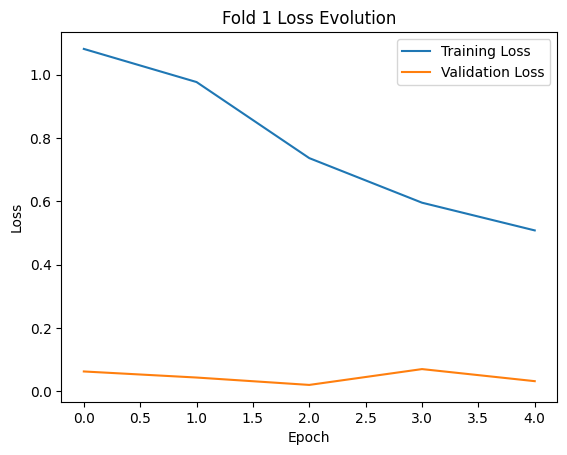

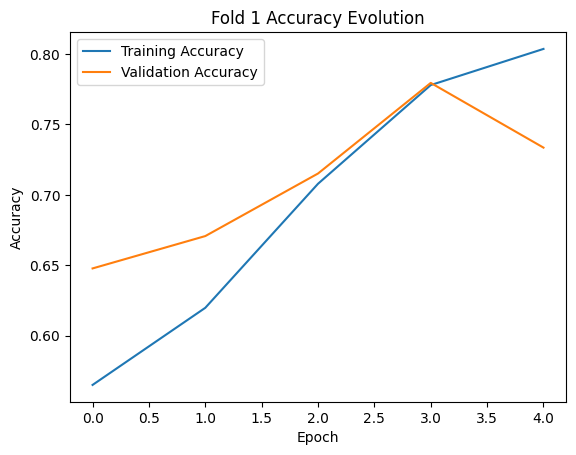

/tmp/ipykernel_1015/3355811739.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6000    0.8286    0.6960       105
 pituitary_tumor     0.8077    0.5676    0.6667        74
meningioma_tumor     0.5787    0.8957    0.7031       115
    glioma_tumor     0.4737    0.0900    0.1513       100

        accuracy                         0.6117       394
       macro avg     0.6150    0.5954    0.5542       394
    weighted avg     0.6007    0.6117    0.5543       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.8139, train_recall: 0.8147, train_f1: 0.8140, train_accuracy: 0.8147
saved new best metric model
current epoch: 1 current AUC: 0.9801 current accuracy: 0.8867 best AUC: 0.9801 at epoch: 1
Epoch 1 fold 2 val_precision: 0.8879, val_recall: 0.8867, val_f1: 0.8853, val_accuracy: 0.8867
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8446, train_recall: 0.8457, train_f1: 0.8449, train_accuracy: 0.8457
saved new best metric model
current epoch: 2 current AUC: 0.9808 curr

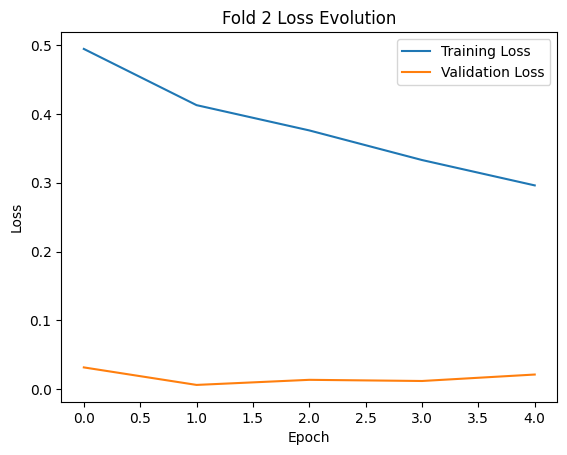

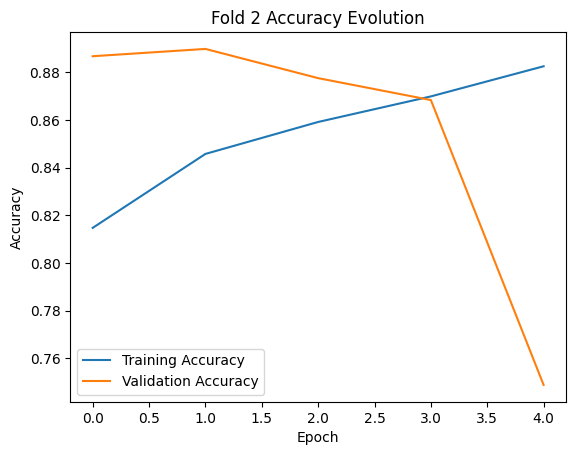

/tmp/ipykernel_1015/3355811739.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5604    0.9714    0.7108       105
 pituitary_tumor     0.7959    0.5270    0.6341        74
meningioma_tumor     0.6861    0.8174    0.7460       115
    glioma_tumor     0.5385    0.1400    0.2222       100

        accuracy                         0.6320       394
       macro avg     0.6452    0.6140    0.5783       394
    weighted avg     0.6358    0.6320    0.5827       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8504, train_recall: 0.8511, train_f1: 0.8506, train_accuracy: 0.8511
saved new best metric model
current epoch: 1 current AUC: 0.9834 current accuracy: 0.9005 best AUC: 0.9834 at epoch: 1
Epoch 1 fold 3 val_precision: 0.9014, val_recall: 0.9005, val_f1: 0.8981, val_accuracy: 0.9005
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8689, train_recall: 0.8691, train_f1: 0.8689, train_accuracy: 0.8691
saved new best metric model
current epoch: 2 current AUC: 0.9863 curr

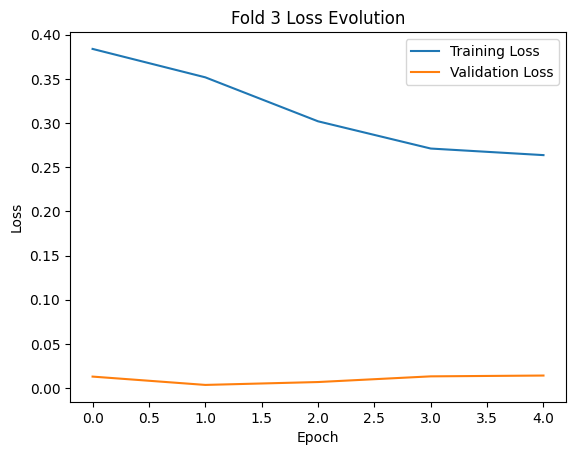

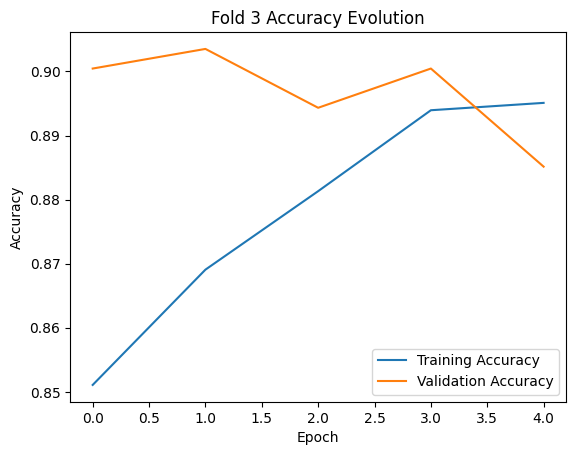

/tmp/ipykernel_1015/3355811739.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6420    0.9905    0.7790       105
 pituitary_tumor     0.8209    0.7432    0.7801        74
meningioma_tumor     0.7000    0.8522    0.7686       115
    glioma_tumor     0.6800    0.1700    0.2720       100

        accuracy                         0.6954       394
       macro avg     0.7107    0.6890    0.6499       394
    weighted avg     0.7022    0.6954    0.6475       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8727, train_recall: 0.8733, train_f1: 0.8729, train_accuracy: 0.8733
current epoch: 1 current AUC: 0.9813 current accuracy: 0.8882 best AUC: 0.9863 at epoch: 2
Epoch 1 fold 4 val_precision: 0.8920, val_recall: 0.8882, val_f1: 0.8876, val_accuracy: 0.8882
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8865, train_recall: 0.8871, train_f1: 0.8866, train_accuracy: 0.8871
current epoch: 2 current AUC: 0.9857 current accuracy: 0.9234 best AUC: 0.9863 at epoch: 2
Epoch 

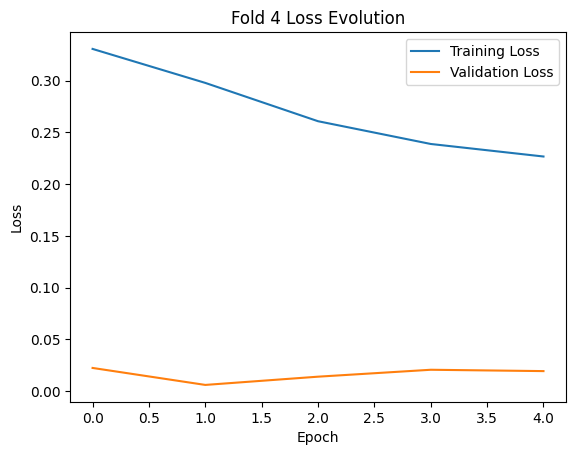

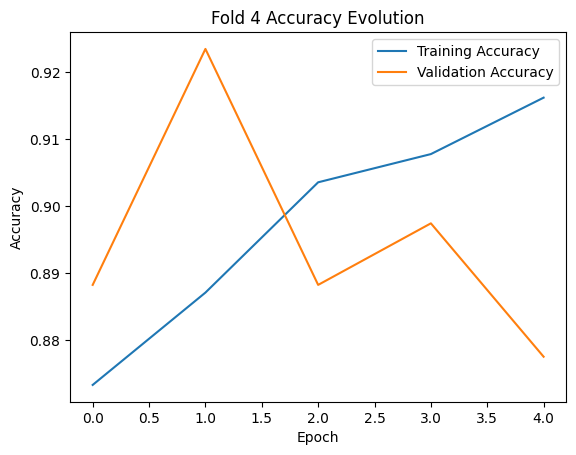

/tmp/ipykernel_1015/3355811739.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6420    0.9905    0.7790       105
 pituitary_tumor     0.8209    0.7432    0.7801        74
meningioma_tumor     0.7000    0.8522    0.7686       115
    glioma_tumor     0.6800    0.1700    0.2720       100

        accuracy                         0.6954       394
       macro avg     0.7107    0.6890    0.6499       394
    weighted avg     0.7022    0.6954    0.6475       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8772, train_recall: 0.8775, train_f1: 0.8773, train_accuracy: 0.8775
saved new best metric model
current epoch: 1 current AUC: 0.9875 current accuracy: 0.9173 best AUC: 0.9875 at epoch: 1
Epoch 1 fold 5 val_precision: 0.9164, val_recall: 0.9173, val_f1: 0.9167, val_accuracy: 0.9173
Epoch: 2
Epoch 2 fold 5 train_precision: 0.8880, train_recall: 0.8882, train_f1: 0.8881, train_accuracy: 0.8882
current epoch: 2 current AUC: 0.9867 current accuracy: 0.9173 best AU

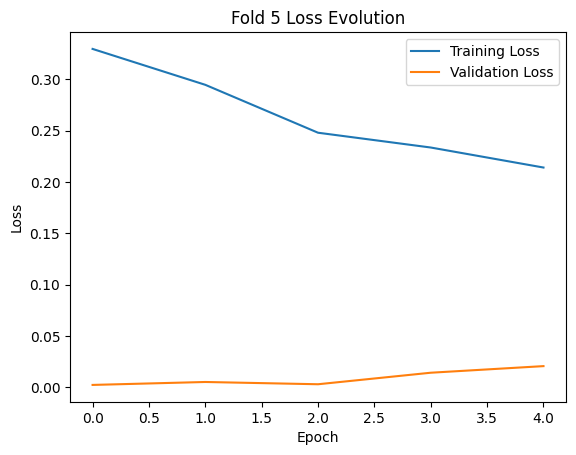

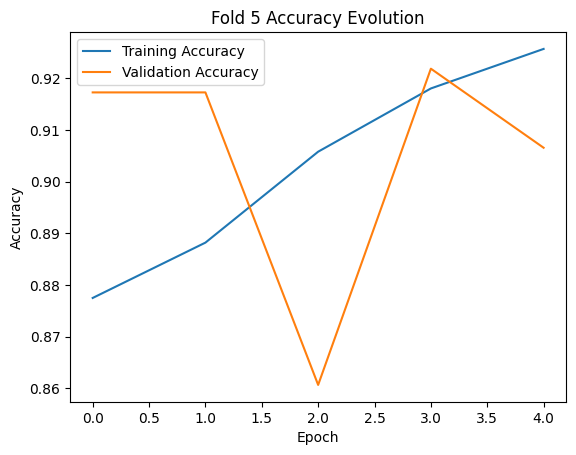

/tmp/ipykernel_1015/3355811739.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6108    0.9714    0.7500       105
 pituitary_tumor     0.8033    0.6622    0.7259        74
meningioma_tumor     0.6993    0.8696    0.7752       115
    glioma_tumor     0.6522    0.1500    0.2439       100

        accuracy                         0.6751       394
       macro avg     0.6914    0.6633    0.6238       394
    weighted avg     0.6833    0.6751    0.6244       394

Fold 5 completed.
train_precision: Mean = 0.8446, Std = 0.0901
train_recall: Mean = 0.8456, Std = 0.0889
train_f1: Mean = 0.8448, Std = 0.0899
train_accuracy: Mean = 0.8456, Std = 0.0889
val_precision: Mean = 0.8595, Std = 0.0750
val_recall: Mean = 0.8520, Std = 0.0810
val_f1: Mean = 0.8489, Std = 0.0847
val_accuracy: Mean = 0.8520, Std = 0.0810


In [75]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 32
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [76]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_1015/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6108    0.9714    0.7500       105
 pituitary_tumor     0.8033    0.6622    0.7259        74
meningioma_tumor     0.6993    0.8696    0.7752       115
    glioma_tumor     0.6522    0.1500    0.2439       100

        accuracy                         0.6751       394
       macro avg     0.6914    0.6633    0.6238       394
    weighted avg     0.6833    0.6751    0.6244       394



Acum incercam cu RMSprop

Pentru learning rate= 0.001, rezultatele sunt: 

        precision    recall  f1-score   support

        no_tumor     0.5232    0.7524    0.6172       105
        pituitary_tumor     0.7143    0.5405    0.6154        74
        meningioma_tumor     0.5793    0.8261    0.6810       115
        glioma_tumor     0.6522    0.1500    0.2439       100

        accuracy                         0.5812       394
       macro avg     0.6172    0.5673    0.5394       394
    weighted avg     0.6082    0.5812    0.5407       394

Este cea mai buna acuratete, modelul avand acuratetea finala de 66%. 

Pentru learning rate de 0.1, acuratetea finala a modelului a fost de 29%, iar pentru 0.01, acuratetea a fost de 60%

In [97]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import sklearn

In [98]:
def load_images(path, labels):
  image_files = []
  labels_return = []
  for label in labels:
    for file in os.listdir(os.path.join(path, label)):
      image_files.append(os.path.join(path) + "/" + label + "/" + file)
      labels_return.append(label)
  return image_files, labels_return

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [99]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, 4, kernel_size=4, stride=2, padding=1, dilation=1)
        self.relu1 = nn.ReLU()
        self.avg = nn.MaxPool2d(kernel_size=4, stride=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1, dilation=1)
        self.drop = nn.Dropout(p=0.3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3528, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def name(self):
        return "LeNet"

In [100]:
use_cuda = torch.cuda.is_available()
Device = "cuda"
model = LeNet(1, 4).to(Device)

In [101]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [102]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transform_PIL_to_cv2,
        transform_cv2_to_PIL,
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ]
)


In [103]:
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [104]:
from monai.transforms import Activations
from monai.transforms import AsDiscrete

y_pred_trans = transforms.Compose([Activations(softmax=True)])
y_trans = transforms.Compose([AsDiscrete(to_onehot=4)])

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.6510, train_recall: 0.6547, train_f1: 0.6503, train_accuracy: 0.6547
saved new best metric model
current epoch: 1 current AUC: 0.9102 current accuracy: 0.6524 best AUC: 0.9102 at epoch: 1
Epoch 1 fold 1 val_precision: 0.7390, val_recall: 0.6524, val_f1: 0.6176, val_accuracy: 0.6524
Epoch: 2
Epoch 2 fold 1 train_precision: 0.7737, train_recall: 0.7760, train_f1: 0.7736, train_accuracy: 0.7760
saved new best metric model
current epoch: 2 current AUC: 0.9350 current accuracy: 0.7657 best AUC: 0.9350 at epoch: 2
Epoch 2 fold 1 val_precision: 0.7612, val_recall: 0.7657, val_f1: 0.7538, val_accuracy: 0.7657
Epoch: 3
Epoch 3 fold 1 train_precision: 0.8129, train_recall: 0.8151, train_f1: 0.8131, train_accuracy: 0.8151
saved new best metric model
current epoch: 3 current AUC: 0.9433 current accuracy: 0.8025 best AUC: 0.9433 at epoch: 3
Epoch 3 fold 1 val_precision: 0.8008, val_recall: 0.8025, val_f1: 0.8010, val_accuracy: 0.8025
Epoch: 4
Epoch

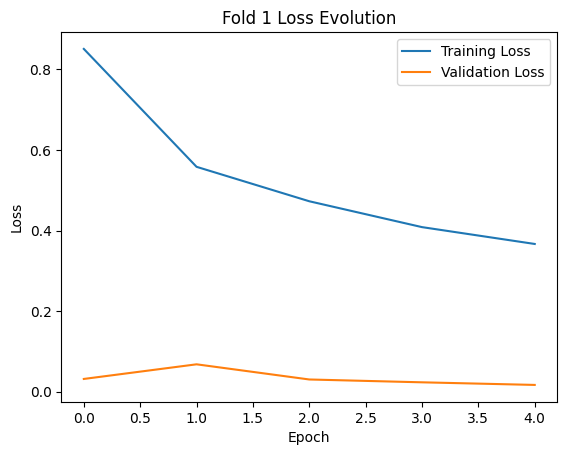

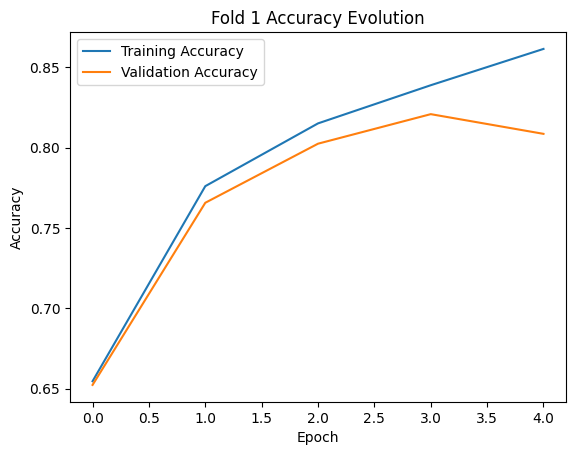

/tmp/ipykernel_1015/3361543270.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5232    0.7524    0.6172       105
 pituitary_tumor     0.7143    0.5405    0.6154        74
meningioma_tumor     0.5793    0.8261    0.6810       115
    glioma_tumor     0.6522    0.1500    0.2439       100

        accuracy                         0.5812       394
       macro avg     0.6172    0.5673    0.5394       394
    weighted avg     0.6082    0.5812    0.5407       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.8566, train_recall: 0.8576, train_f1: 0.8567, train_accuracy: 0.8576
saved new best metric model
current epoch: 1 current AUC: 0.9872 current accuracy: 0.8453 best AUC: 0.9872 at epoch: 1
Epoch 1 fold 2 val_precision: 0.8876, val_recall: 0.8453, val_f1: 0.8442, val_accuracy: 0.8453
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8742, train_recall: 0.8744, train_f1: 0.8741, train_accuracy: 0.8744
current epoch: 2 current AUC: 0.9867 current accuracy: 0.8591 best AU

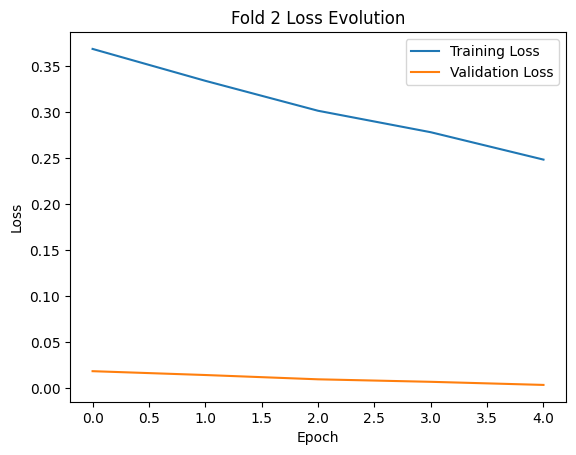

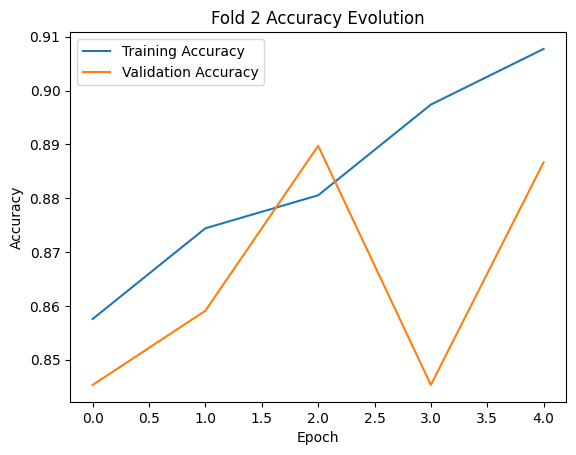

/tmp/ipykernel_1015/3361543270.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4851    0.9333    0.6384       105
 pituitary_tumor     0.8636    0.5135    0.6441        74
meningioma_tumor     0.7523    0.7130    0.7321       115
    glioma_tumor     0.4103    0.1600    0.2302       100

        accuracy                         0.5939       394
       macro avg     0.6278    0.5800    0.5612       394
    weighted avg     0.6152    0.5939    0.5632       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8721, train_recall: 0.8725, train_f1: 0.8717, train_accuracy: 0.8725
saved new best metric model
current epoch: 1 current AUC: 0.9909 current accuracy: 0.9127 best AUC: 0.9909 at epoch: 1
Epoch 1 fold 3 val_precision: 0.9214, val_recall: 0.9127, val_f1: 0.9125, val_accuracy: 0.9127
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8886, train_recall: 0.8894, train_f1: 0.8888, train_accuracy: 0.8894
current epoch: 2 current AUC: 0.9908 current accuracy: 0.8928 best AU

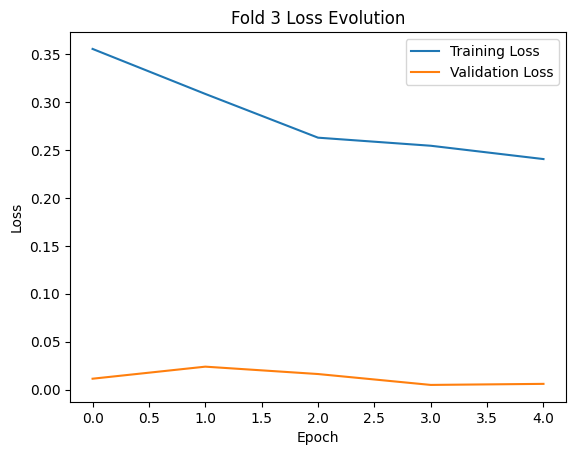

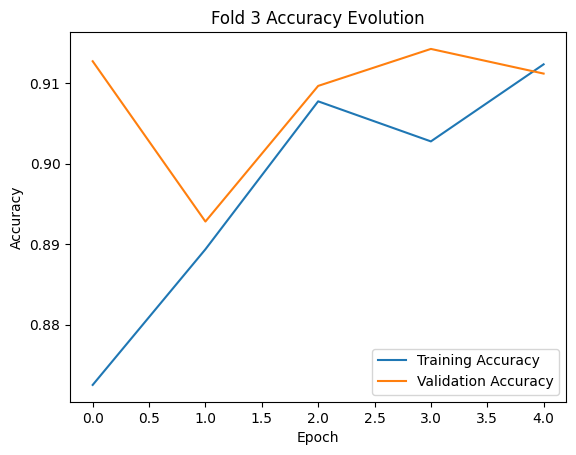

/tmp/ipykernel_1015/3361543270.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5435    0.9524    0.6920       105
 pituitary_tumor     0.9189    0.4595    0.6126        74
meningioma_tumor     0.6460    0.9043    0.7536       115
    glioma_tumor     0.8333    0.1000    0.1786       100

        accuracy                         0.6294       394
       macro avg     0.7354    0.6040    0.5592       394
    weighted avg     0.7175    0.6294    0.5648       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8819, train_recall: 0.8825, train_f1: 0.8821, train_accuracy: 0.8825
current epoch: 1 current AUC: 0.9903 current accuracy: 0.9250 best AUC: 0.9909 at epoch: 1
Epoch 1 fold 4 val_precision: 0.9237, val_recall: 0.9250, val_f1: 0.9237, val_accuracy: 0.9250
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8955, train_recall: 0.8959, train_f1: 0.8956, train_accuracy: 0.8959
current epoch: 2 current AUC: 0.9906 current accuracy: 0.9096 best AUC: 0.9909 at epoch: 1
Epoch 

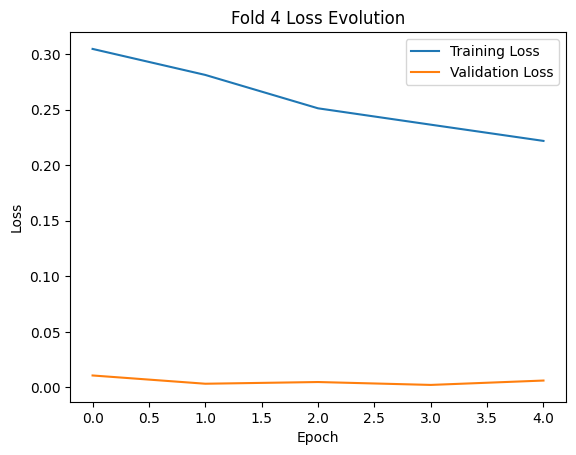

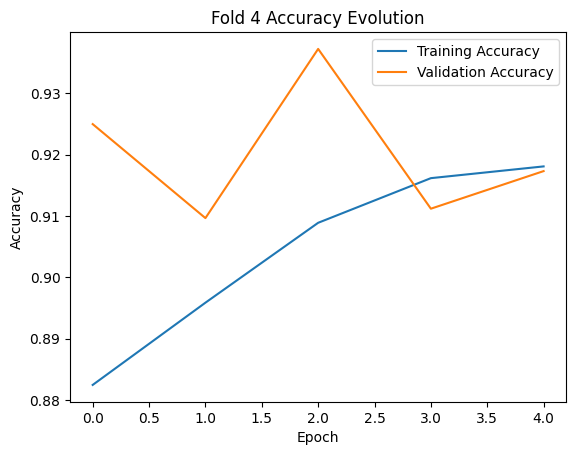

/tmp/ipykernel_1015/3361543270.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6624    0.9905    0.7939       105
 pituitary_tumor     0.9574    0.6081    0.7438        74
meningioma_tumor     0.6453    0.9652    0.7735       115
    glioma_tumor     0.8889    0.1600    0.2712       100

        accuracy                         0.7005       394
       macro avg     0.7885    0.6810    0.6456       394
    weighted avg     0.7703    0.7005    0.6459       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.9057, train_recall: 0.9062, train_f1: 0.9059, train_accuracy: 0.9062
saved new best metric model
current epoch: 1 current AUC: 0.9930 current accuracy: 0.9096 best AUC: 0.9930 at epoch: 1
Epoch 1 fold 5 val_precision: 0.9247, val_recall: 0.9096, val_f1: 0.9091, val_accuracy: 0.9096
Epoch: 2
Epoch 2 fold 5 train_precision: 0.9137, train_recall: 0.9139, train_f1: 0.9137, train_accuracy: 0.9139
current epoch: 2 current AUC: 0.9924 current accuracy: 0.8637 best AU

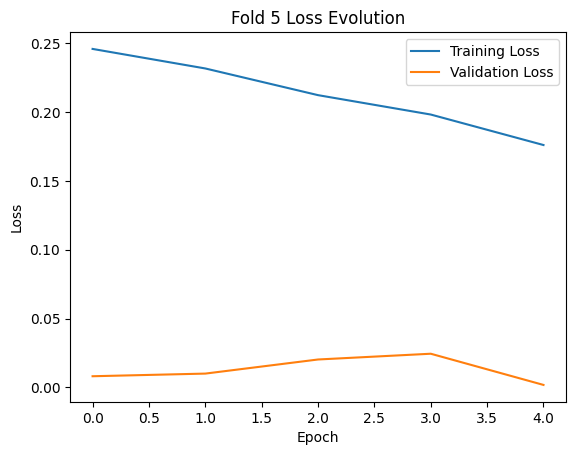

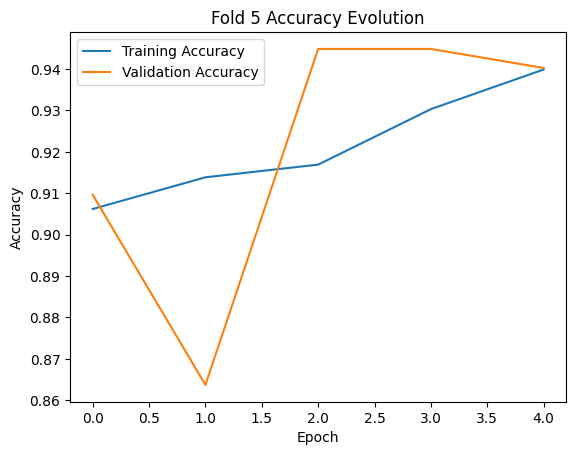

/tmp/ipykernel_1015/3361543270.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6623    0.9524    0.7812       105
 pituitary_tumor     0.8936    0.5676    0.6942        74
meningioma_tumor     0.5968    0.9652    0.7375       115
    glioma_tumor     0.9000    0.0900    0.1636       100

        accuracy                         0.6650       394
       macro avg     0.7632    0.6438    0.5942       394
    weighted avg     0.7469    0.6650    0.5954       394

Fold 5 completed.
train_precision: Mean = 0.8783, Std = 0.0591
train_recall: Mean = 0.8791, Std = 0.0583
train_f1: Mean = 0.8783, Std = 0.0592
train_accuracy: Mean = 0.8791, Std = 0.0583
val_precision: Mean = 0.8897, Std = 0.0547
val_recall: Mean = 0.8768, Std = 0.0658
val_f1: Mean = 0.8736, Std = 0.0714
val_accuracy: Mean = 0.8768, Std = 0.0658


In [105]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
folds, batch_size = 5, 32
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [106]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_1015/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6623    0.9524    0.7812       105
 pituitary_tumor     0.8936    0.5676    0.6942        74
meningioma_tumor     0.5968    0.9652    0.7375       115
    glioma_tumor     0.9000    0.0900    0.1636       100

        accuracy                         0.6650       394
       macro avg     0.7632    0.6438    0.5942       394
    weighted avg     0.7469    0.6650    0.5954       394



BONUS 2

In [11]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import sklearn

In [12]:
def load_images(path, labels):
  image_files = []
  labels_return = []
  for label in labels:
    for file in os.listdir(os.path.join(path, label)):
      image_files.append(os.path.join(path) + "/" + label + "/" + file)
      labels_return.append(label)
  return image_files, labels_return

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [3]:
from torchvision import models

model = models.efficientnet_b7(pretrained=True)

model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2560, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 4)
)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

use_cuda = torch.cuda.is_available()
Device = "cuda"
model = model.to(Device)

/home/melidia/curse/is/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features.0.0.weight: requires_grad=False
features.0.1.weight: requires_grad=False
features.0.1.bias: requires_grad=False
features.1.0.block.0.0.weight: requires_grad=False
features.1.0.block.0.1.weight: requires_grad=False
features.1.0.block.0.1.bias: requires_grad=False
features.1.0.block.1.fc1.weight: requires_grad=False
features.1.0.block.1.fc1.bias: requires_grad=False
features.1.0.block.1.fc2.weight: requires_grad=False
features.1.0.block.1.fc2.bias: requires_grad=False
features.1.0.block.2.0.weight: requires_grad=False
features.1.0.block.2.1.weight: requires_grad=False
features.1.0.block.2.1.bias: requires_grad=False
features.1.1.block.0.0.weight: requires_grad=False
features.1.1.block.0.1.weight: requires_grad=False
features.1.1.block.0.1.bias: requires_grad=False
features.1.1.block.1.fc1.weight: requires_grad=False
features.1.1.block.1.fc1.bias: requires_grad=False
features.1.1.block.1.fc2.weight: requires_grad=False
features.1.1.block.1.fc2.bias: requires_grad=False
features.1

In [13]:
from torchvision import models

model = models.efficientnet_b7(pretrained=True)

model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2560, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 4)
)

for param in model.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

use_cuda = torch.cuda.is_available()
Device = "cuda"
model = model.to(Device)

/home/melidia/curse/is/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features.0.0.weight: requires_grad=True
features.0.1.weight: requires_grad=True
features.0.1.bias: requires_grad=True
features.1.0.block.0.0.weight: requires_grad=True
features.1.0.block.0.1.weight: requires_grad=True
features.1.0.block.0.1.bias: requires_grad=True
features.1.0.block.1.fc1.weight: requires_grad=True
features.1.0.block.1.fc1.bias: requires_grad=True
features.1.0.block.1.fc2.weight: requires_grad=True
features.1.0.block.1.fc2.bias: requires_grad=True
features.1.0.block.2.0.weight: requires_grad=True
features.1.0.block.2.1.weight: requires_grad=True
features.1.0.block.2.1.bias: requires_grad=True
features.1.1.block.0.0.weight: requires_grad=True
features.1.1.block.0.1.weight: requires_grad=True
features.1.1.block.0.1.bias: requires_grad=True
features.1.1.block.1.fc1.weight: requires_grad=True
features.1.1.block.1.fc1.bias: requires_grad=True
features.1.1.block.1.fc2.weight: requires_grad=True
features.1.1.block.1.fc2.bias: requires_grad=True
features.1.1.block.2.0.weight:

In [14]:
import random

path = "/home/melidia/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
list_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

images_train_sec, label_train_sec = load_images(path + "/Training", list_labels)
images_test_sec, label_test_sec = load_images(path + "/Testing", list_labels)

label_to_index = {
        'no_tumor': 0,
        'pituitary_tumor': 1,
        'meningioma_tumor': 2,
        'glioma_tumor': 3
    }
label_train_sec = [label_to_index[label] for label in label_train_sec]
label_test_sec = [label_to_index[label] for label in label_test_sec]

no_tumor_images = [image for image, label in zip(images_train_sec, label_train_sec) if label == 0]
random.shuffle(no_tumor_images)
images_train_sec.extend(no_tumor_images)
label_train_sec.extend([0] * len(no_tumor_images))

In [22]:
from PIL import Image, ImageFilter
import albumentations as A
import cv2
from torchvision import transforms

def open_image(path):
    image = PIL.Image.open(path)
    return image

def gaussian_blur(image, radius=0.1):
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

def autocontrast(image):
    return PIL.ImageOps.autocontrast(image)

def sharpeness(image):
    return image.filter(PIL.ImageFilter.SHARPEN)

def transform_PIL_to_cv2(image):
    np_image = np.array(image)
    imagev2 = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    return imagev2

def apply_clahe(image, clip_limit=1.0, tile_grid_size=(32, 32)):
    clahe_transform = A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=True)
    transformed = clahe_transform(image=image)
    clahe_image = transformed['image']

    return clahe_image

def transform_cv2_to_PIL(image):
    return PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def rotate(image):
    return transforms.functional.rotate(image, angle=10)

transforms_img = transforms.Compose(
    [
        open_image,
        transforms.Resize(size=(50, 50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

transforms_test = transforms.Compose(
    [
        open_image,
        transforms.Resize(size=(50, 50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)


In [23]:
test_dataset = Dataset(images_test_sec, label_test_sec, transforms_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [17]:
from monai.transforms import Activations
from monai.transforms import AsDiscrete

y_pred_trans = transforms.Compose([Activations(softmax=True)])
y_trans = transforms.Compose([AsDiscrete(to_onehot=4)])

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.7065, train_recall: 0.7087, train_f1: 0.7032, train_accuracy: 0.7087
saved new best metric model
current epoch: 1 current AUC: 0.8748 current accuracy: 0.6478 best AUC: 0.8748 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6791, val_recall: 0.6478, val_f1: 0.6387, val_accuracy: 0.6478
Epoch: 2
Epoch 2 fold 1 train_precision: 0.8423, train_recall: 0.8419, train_f1: 0.8408, train_accuracy: 0.8419
saved new best metric model
current epoch: 2 current AUC: 0.9299 current accuracy: 0.7427 best AUC: 0.9299 at epoch: 2
Epoch 2 fold 1 val_precision: 0.7695, val_recall: 0.7427, val_f1: 0.7233, val_accuracy: 0.7427
Epoch: 3
Epoch 3 fold 1 train_precision: 0.8520, train_recall: 0.8503, train_f1: 0.8492, train_accuracy: 0.8503
current epoch: 3 current AUC: 0.9284 current accuracy: 0.7427 best AUC: 0.9299 at epoch: 2
Epoch 3 fold 1 val_precision: 0.7765, val_recall: 0.7427, val_f1: 0.7269, val_accuracy: 0.7427
Epoch: 4
Epoch 4 fold 1 train_precision: 0

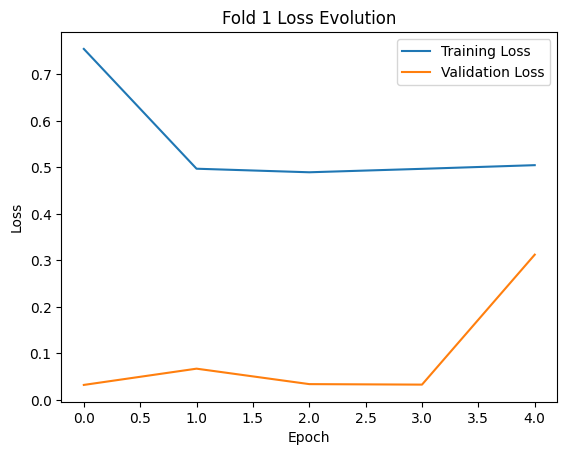

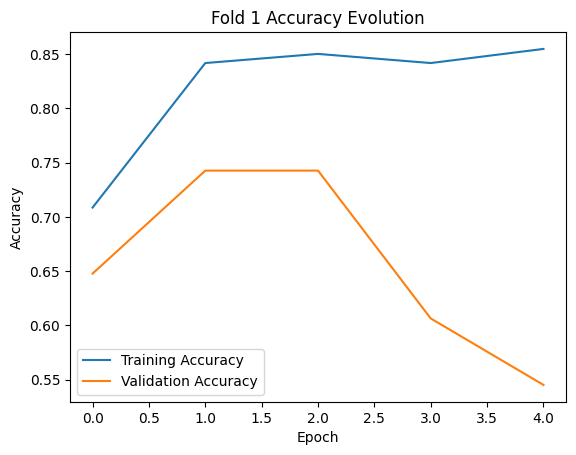

/tmp/ipykernel_30822/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.4321    1.0000    0.6034       105
meningioma_tumor     0.6618    0.6081    0.6338        74
 pituitary_tumor     0.4444    0.1739    0.2500       115
    glioma_tumor     0.6053    0.2300    0.3333       100

        accuracy                         0.4898       394
       macro avg     0.5359    0.5030    0.4551       394
    weighted avg     0.5228    0.4898    0.4374       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.8651, train_recall: 0.8595, train_f1: 0.8596, train_accuracy: 0.8595
saved new best metric model
current epoch: 1 current AUC: 0.9321 current accuracy: 0.7688 best AUC: 0.9321 at epoch: 1
Epoch 1 fold 2 val_precision: 0.7793, val_recall: 0.7688, val_f1: 0.7694, val_accuracy: 0.7688
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8850, train_recall: 0.8851, train_f1: 0.8845, train_accuracy: 0.8851
current epoch: 2 current AUC: 0.8600 current accuracy: 0.6447 best AU

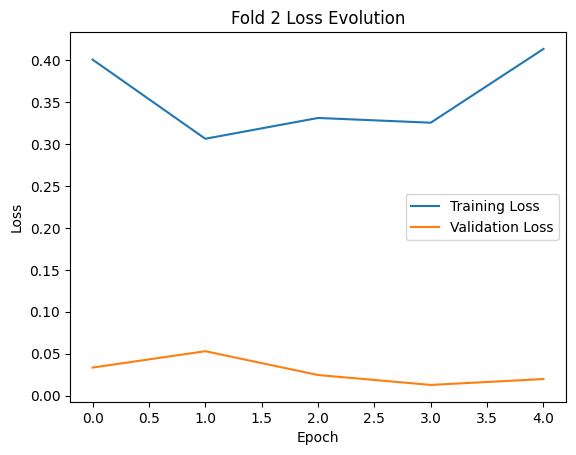

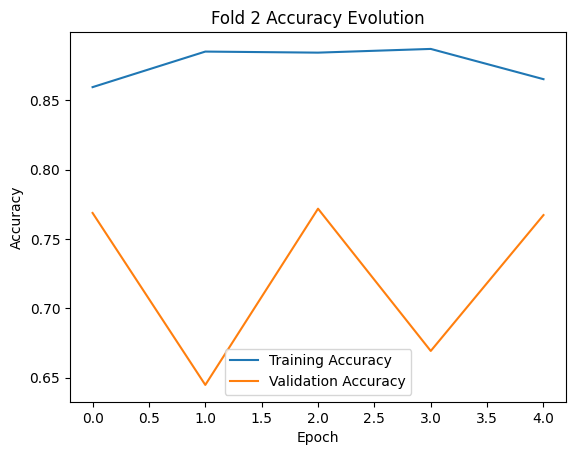

/tmp/ipykernel_30822/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.5224    1.0000    0.6863       105
meningioma_tumor     0.7600    0.2568    0.3838        74
 pituitary_tumor     0.4768    0.6261    0.5414       115
    glioma_tumor     0.8235    0.1400    0.2393       100

        accuracy                         0.5330       394
       macro avg     0.6457    0.5057    0.4627       394
    weighted avg     0.6301    0.5330    0.4737       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.9100, train_recall: 0.9074, train_f1: 0.9082, train_accuracy: 0.9074
current epoch: 1 current AUC: 0.9440 current accuracy: 0.7979 best AUC: 0.9451 at epoch: 5
Epoch 1 fold 3 val_precision: 0.8181, val_recall: 0.7979, val_f1: 0.7956, val_accuracy: 0.7979
Epoch: 2
Epoch 2 fold 3 train_precision: 0.8650, train_recall: 0.8538, train_f1: 0.8569, train_accuracy: 0.8538
saved new best metric model
current epoch: 2 current AUC: 0.9755 current accuracy: 0.8836 best AU

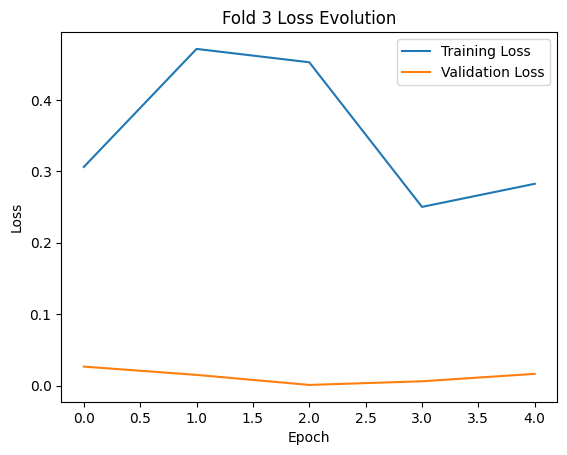

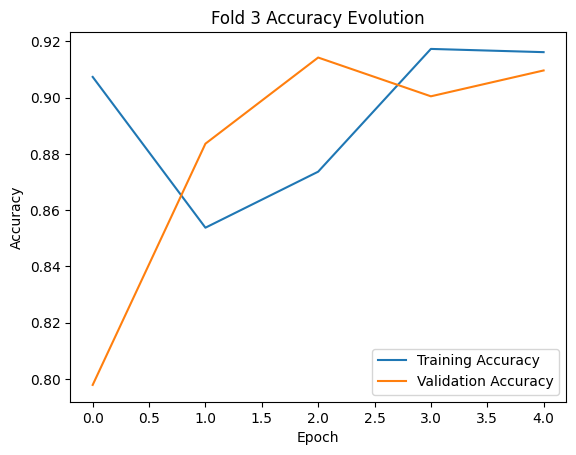

/tmp/ipykernel_30822/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6863    1.0000    0.8140       105
meningioma_tumor     0.8491    0.6081    0.7087        74
 pituitary_tumor     0.5740    0.8435    0.6831       115
    glioma_tumor     0.9474    0.1800    0.3025       100

        accuracy                         0.6726       394
       macro avg     0.7642    0.6579    0.6271       394
    weighted avg     0.7503    0.6726    0.6262       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.9256, train_recall: 0.9227, train_f1: 0.9234, train_accuracy: 0.9227
saved new best metric model
current epoch: 1 current AUC: 0.9974 current accuracy: 0.9571 best AUC: 0.9974 at epoch: 1
Epoch 1 fold 4 val_precision: 0.9577, val_recall: 0.9571, val_f1: 0.9572, val_accuracy: 0.9571
Epoch: 2
Epoch 2 fold 4 train_precision: 0.8983, train_recall: 0.8913, train_f1: 0.8930, train_accuracy: 0.8913
current epoch: 2 current AUC: 0.9956 current accuracy: 0.9495 best AU

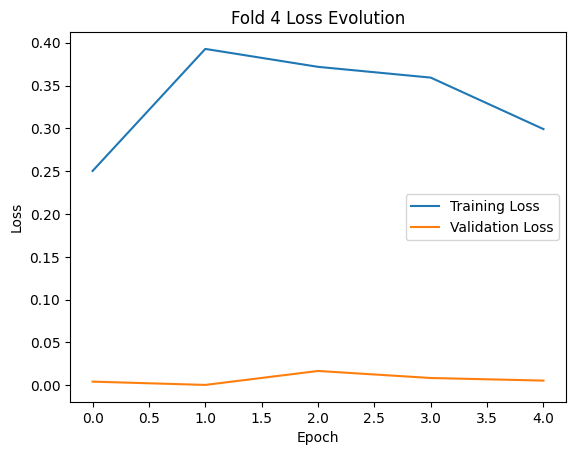

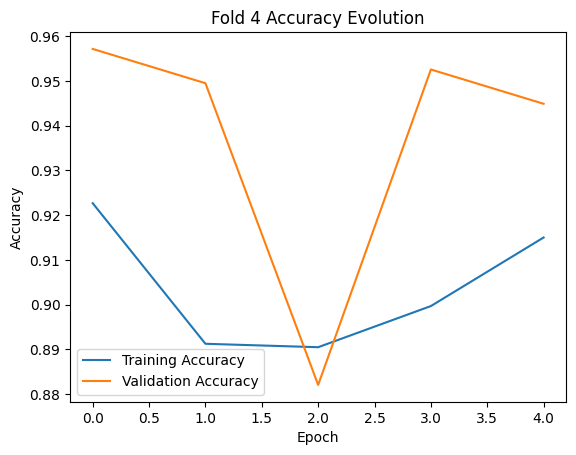

/tmp/ipykernel_30822/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.6402    1.0000    0.7807       105
meningioma_tumor     0.8519    0.6216    0.7188        74
 pituitary_tumor     0.5949    0.8174    0.6886       115
    glioma_tumor     1.0000    0.1800    0.3051       100

        accuracy                         0.6675       394
       macro avg     0.7718    0.6548    0.6233       394
    weighted avg     0.7581    0.6675    0.6215       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.9261, train_recall: 0.9208, train_f1: 0.9220, train_accuracy: 0.9208
current epoch: 1 current AUC: 0.9969 current accuracy: 0.9663 best AUC: 0.9974 at epoch: 1
Epoch 1 fold 5 val_precision: 0.9680, val_recall: 0.9663, val_f1: 0.9663, val_accuracy: 0.9663
Epoch: 2
Epoch 2 fold 5 train_precision: 0.9058, train_recall: 0.8989, train_f1: 0.9007, train_accuracy: 0.8989
saved new best metric model
current epoch: 2 current AUC: 0.9985 current accuracy: 0.9709 best AU

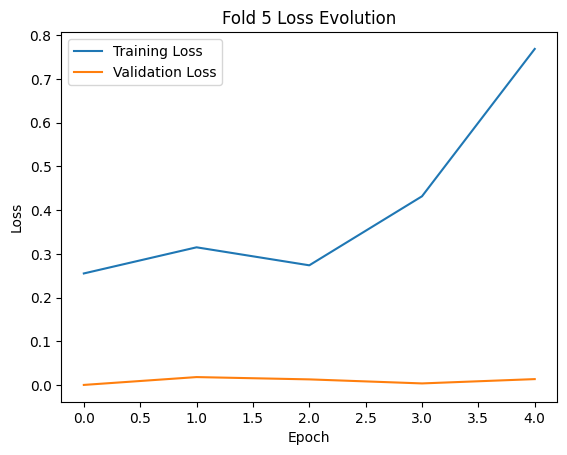

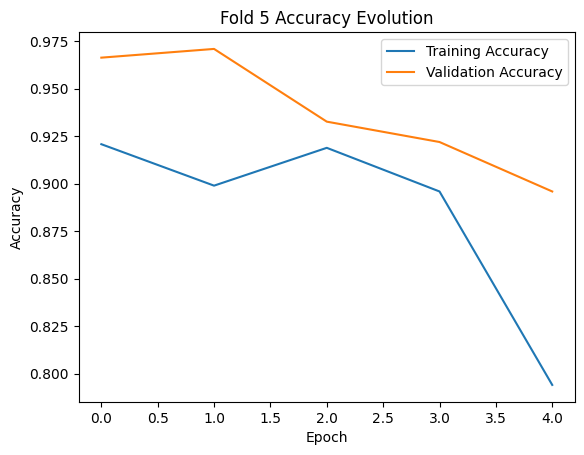

/tmp/ipykernel_30822/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

        no_tumor     0.7394    1.0000    0.8502       105
meningioma_tumor     0.8800    0.5946    0.7097        74
 pituitary_tumor     0.6158    0.9478    0.7466       115
    glioma_tumor     1.0000    0.2500    0.4000       100

        accuracy                         0.7183       394
       macro avg     0.8088    0.6981    0.6766       394
    weighted avg     0.7959    0.7183    0.6793       394

Fold 5 completed.
train_precision: Mean = 0.8819, Std = 0.0452
train_recall: Mean = 0.8758, Std = 0.0461
train_f1: Mean = 0.8768, Std = 0.0467
train_accuracy: Mean = 0.8758, Std = 0.0461
val_precision: Mean = 0.8551, Std = 0.0943
val_recall: Mean = 0.8274, Std = 0.1259
val_f1: Mean = 0.8244, Std = 0.1294
val_accuracy: Mean = 0.8274, Std = 0.1259


In [23]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

folds, batch_size = 5, 32
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [ ]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

In [ ]:
torch.cuda.empty_cache()

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.7104, train_recall: 0.7148, train_f1: 0.7116, train_accuracy: 0.7148
saved new best metric model
current epoch: 1 current AUC: 0.8707 current accuracy: 0.6233 best AUC: 0.8707 at epoch: 1
Epoch 1 fold 1 val_precision: 0.6793, val_recall: 0.6233, val_f1: 0.5964, val_accuracy: 0.6233
Epoch: 2
Epoch 2 fold 1 train_precision: 0.8346, train_recall: 0.8365, train_f1: 0.8348, train_accuracy: 0.8365
saved new best metric model
current epoch: 2 current AUC: 0.9109 current accuracy: 0.7182 best AUC: 0.9109 at epoch: 2
Epoch 2 fold 1 val_precision: 0.7364, val_recall: 0.7182, val_f1: 0.7020, val_accuracy: 0.7182
Epoch: 3
Epoch 3 fold 1 train_precision: 0.8578, train_recall: 0.8541, train_f1: 0.8545, train_accuracy: 0.8541
current epoch: 3 current AUC: 0.8955 current accuracy: 0.6616 best AUC: 0.9109 at epoch: 2
Epoch 3 fold 1 val_precision: 0.7363, val_recall: 0.6616, val_f1: 0.6645, val_accuracy: 0.6616
Epoch: 4
Epoch 4 fold 1 train_precision: 0

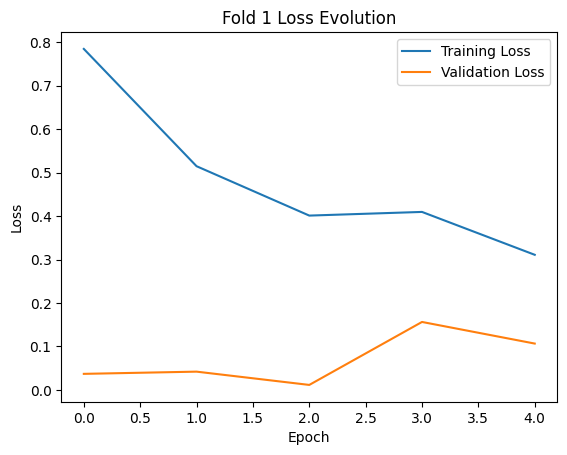

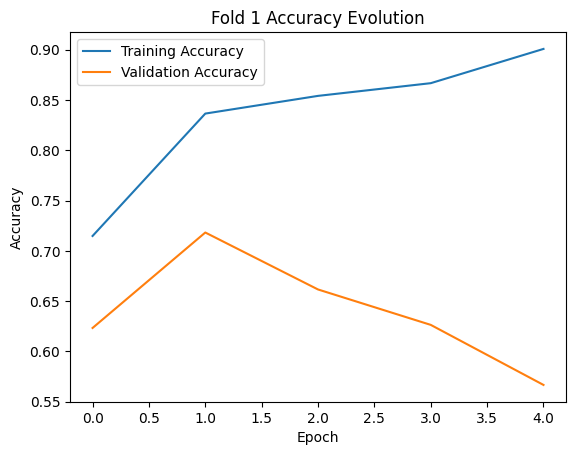

/tmp/ipykernel_55372/631471802.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.4950    0.9524    0.6515       105
    glioma_tumor     0.7742    0.3243    0.4571        74
        no_tumor     0.4675    0.3130    0.3750       115
meningioma_tumor     0.3929    0.3300    0.3587       100

        accuracy                         0.4898       394
       macro avg     0.5324    0.4799    0.4606       394
    weighted avg     0.5135    0.4898    0.4600       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.8602, train_recall: 0.8591, train_f1: 0.8584, train_accuracy: 0.8591
current epoch: 1 current AUC: 0.8739 current accuracy: 0.6692 best AUC: 0.9109 at epoch: 2
Epoch 1 fold 2 val_precision: 0.7264, val_recall: 0.6692, val_f1: 0.6532, val_accuracy: 0.6692
Epoch: 2
Epoch 2 fold 2 train_precision: 0.8610, train_recall: 0.8553, train_f1: 0.8563, train_accuracy: 0.8553
saved new best metric model
current epoch: 2 current AUC: 0.9178 current accuracy: 0.7259 best AU

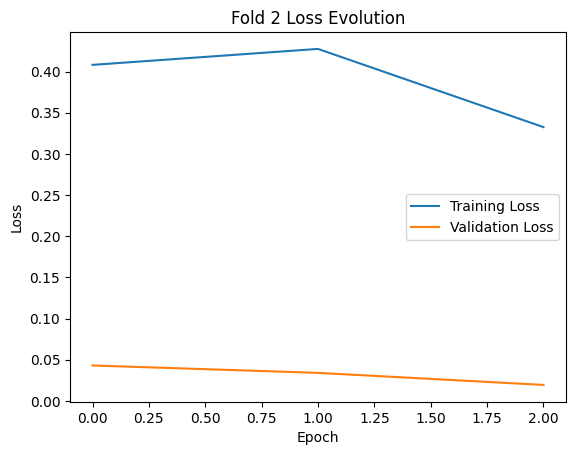

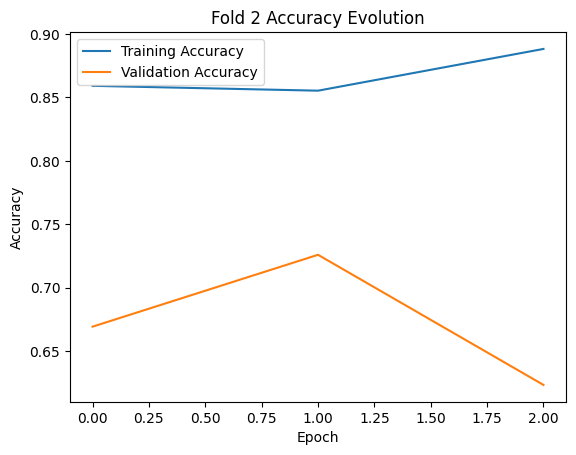

/tmp/ipykernel_55372/631471802.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.4886    0.8190    0.6121       105
    glioma_tumor     0.8182    0.1216    0.2118        74
        no_tumor     0.4623    0.8000    0.5860       115
meningioma_tumor     1.0000    0.0800    0.1481       100

        accuracy                         0.4949       394
       macro avg     0.6923    0.4552    0.3895       394
    weighted avg     0.6726    0.4949    0.4115       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.8765, train_recall: 0.8775, train_f1: 0.8768, train_accuracy: 0.8775
current epoch: 1 current AUC: 0.8959 current accuracy: 0.6799 best AUC: 0.9178 at epoch: 2
Epoch 1 fold 3 val_precision: 0.7405, val_recall: 0.6799, val_f1: 0.6736, val_accuracy: 0.6799
Early stopping


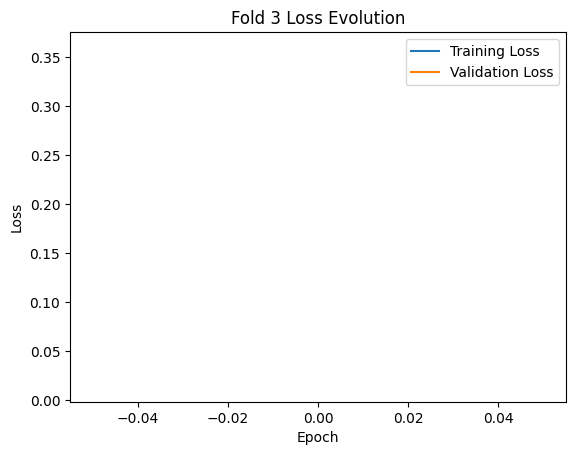

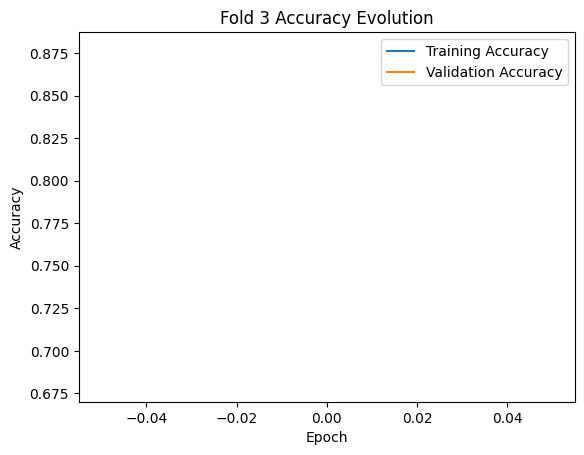

/tmp/ipykernel_55372/631471802.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.4886    0.8190    0.6121       105
    glioma_tumor     0.8182    0.1216    0.2118        74
        no_tumor     0.4623    0.8000    0.5860       115
meningioma_tumor     1.0000    0.0800    0.1481       100

        accuracy                         0.4949       394
       macro avg     0.6923    0.4552    0.3895       394
    weighted avg     0.6726    0.4949    0.4115       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.8762, train_recall: 0.8740, train_f1: 0.8743, train_accuracy: 0.8740
current epoch: 1 current AUC: 0.8233 current accuracy: 0.4809 best AUC: 0.9178 at epoch: 2
Epoch 1 fold 4 val_precision: 0.7915, val_recall: 0.4809, val_f1: 0.4860, val_accuracy: 0.4809
Early stopping


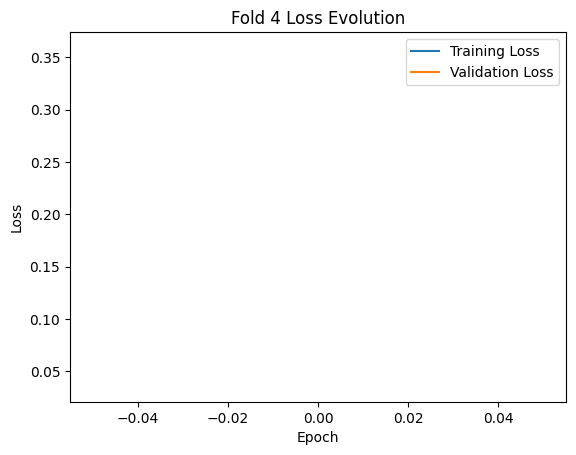

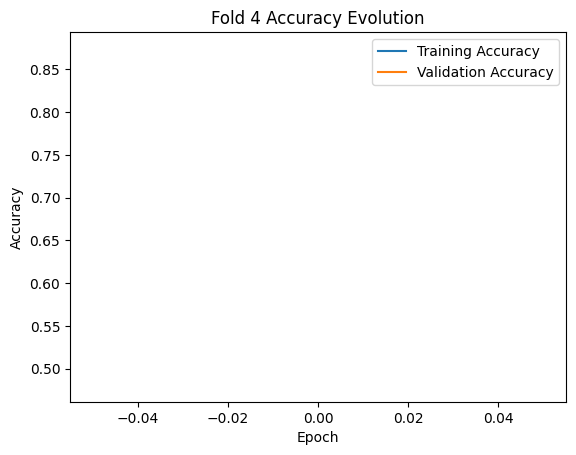

/tmp/ipykernel_55372/631471802.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.4886    0.8190    0.6121       105
    glioma_tumor     0.8182    0.1216    0.2118        74
        no_tumor     0.4623    0.8000    0.5860       115
meningioma_tumor     1.0000    0.0800    0.1481       100

        accuracy                         0.4949       394
       macro avg     0.6923    0.4552    0.3895       394
    weighted avg     0.6726    0.4949    0.4115       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.8937, train_recall: 0.8890, train_f1: 0.8896, train_accuracy: 0.8890
current epoch: 1 current AUC: 0.8422 current accuracy: 0.5773 best AUC: 0.9178 at epoch: 2
Epoch 1 fold 5 val_precision: 0.7465, val_recall: 0.5773, val_f1: 0.5400, val_accuracy: 0.5773
Early stopping


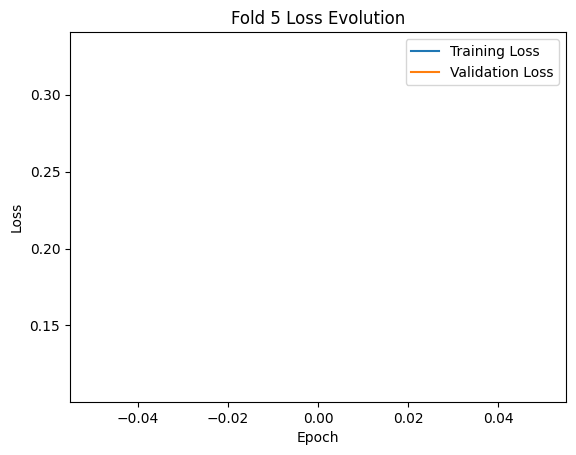

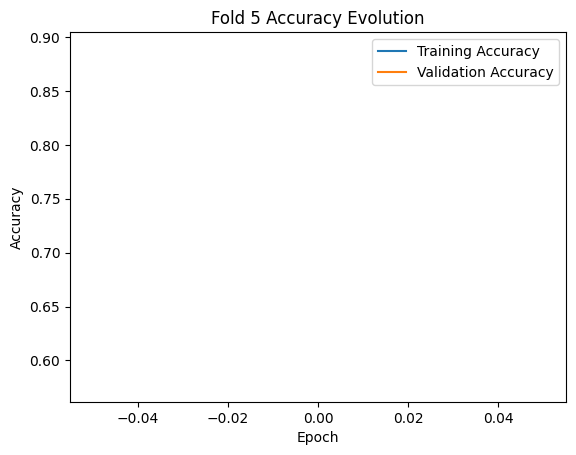

/tmp/ipykernel_55372/631471802.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.4886    0.8190    0.6121       105
    glioma_tumor     0.8182    0.1216    0.2118        74
        no_tumor     0.4623    0.8000    0.5860       115
meningioma_tumor     1.0000    0.0800    0.1481       100

        accuracy                         0.4949       394
       macro avg     0.6923    0.4552    0.3895       394
    weighted avg     0.6726    0.4949    0.4115       394

Fold 5 completed.
train_precision: Mean = 0.8577, Std = 0.0502
train_recall: Mean = 0.8560, Std = 0.0480
train_f1: Mean = 0.8558, Std = 0.0491
train_accuracy: Mean = 0.8560, Std = 0.0480
val_precision: Mean = 0.7413, Std = 0.0315
val_recall: Mean = 0.6320, Std = 0.0682
val_f1: Mean = 0.6180, Std = 0.0694
val_accuracy: Mean = 0.6320, Std = 0.0682


In [9]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, delta=0)
folds, batch_size = 5, 32
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")


In [10]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
labelsforknown = {
        'no_tumor',
        'pituitary_tumor',
        'meningioma_tumor',
        'glioma_tumor'
    }
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(Device),
            test_data[1].to(Device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))

/tmp/ipykernel_55372/1472524629.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.4886    0.8190    0.6121       105
    glioma_tumor     0.8182    0.1216    0.2118        74
        no_tumor     0.4623    0.8000    0.5860       115
meningioma_tumor     1.0000    0.0800    0.1481       100

        accuracy                         0.4949       394
       macro avg     0.6923    0.4552    0.3895       394
    weighted avg     0.6726    0.4949    0.4115       394



Fold: 1
Epoch: 1
Epoch 1 fold 1 train_precision: 0.2515, train_recall: 0.2554, train_f1: 0.2475, train_accuracy: 0.2554
saved new best metric model
current epoch: 1 current AUC: 0.5000 current accuracy: 0.2282 best AUC: 0.5000 at epoch: 1
Epoch 1 fold 1 val_precision: 0.0521, val_recall: 0.2282, val_f1: 0.0848, val_accuracy: 0.2282
Epoch: 2


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 fold 1 train_precision: 0.3718, train_recall: 0.2871, train_f1: 0.2805, train_accuracy: 0.2871
saved new best metric model
current epoch: 2 current AUC: 0.6517 current accuracy: 0.2297 best AUC: 0.6517 at epoch: 2
Epoch 2 fold 1 val_precision: 0.2845, val_recall: 0.2297, val_f1: 0.0894, val_accuracy: 0.2297
Epoch: 3


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 fold 1 train_precision: 0.2521, train_recall: 0.2707, train_f1: 0.2276, train_accuracy: 0.2707
current epoch: 3 current AUC: 0.4373 current accuracy: 0.3185 best AUC: 0.6517 at epoch: 2
Epoch 3 fold 1 val_precision: 0.2947, val_recall: 0.3185, val_f1: 0.1800, val_accuracy: 0.3185
Epoch: 4


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 fold 1 train_precision: 0.2670, train_recall: 0.2688, train_f1: 0.2576, train_accuracy: 0.2688
current epoch: 4 current AUC: 0.5000 current accuracy: 0.2312 best AUC: 0.6517 at epoch: 2
Epoch 4 fold 1 val_precision: 0.0535, val_recall: 0.2312, val_f1: 0.0869, val_accuracy: 0.2312
Epoch: 5


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 fold 1 train_precision: 0.0670, train_recall: 0.2588, train_f1: 0.1064, train_accuracy: 0.2588
current epoch: 5 current AUC: 0.5000 current accuracy: 0.2312 best AUC: 0.6517 at epoch: 2
Epoch 5 fold 1 val_precision: 0.0535, val_recall: 0.2312, val_f1: 0.0869, val_accuracy: 0.2312


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


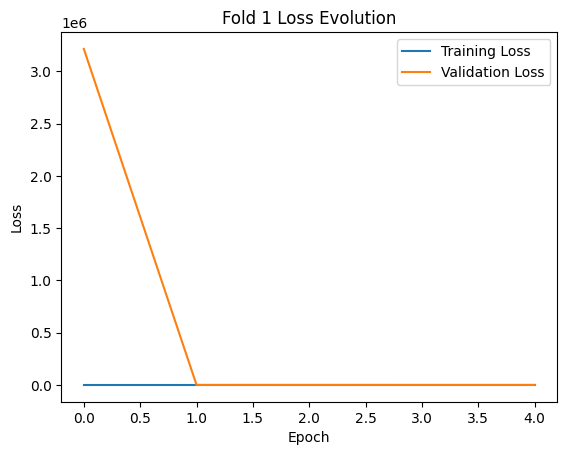

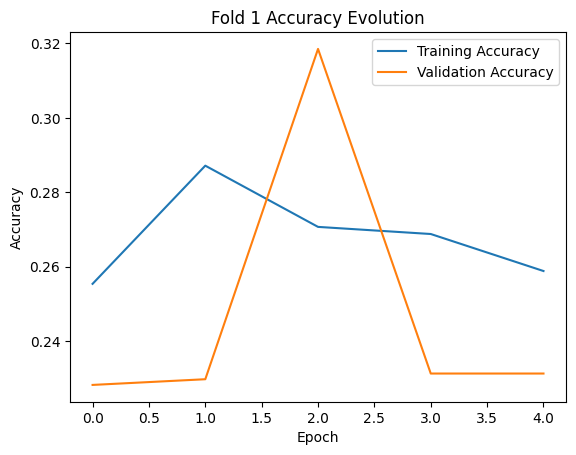

/tmp/ipykernel_55372/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
/home

                  precision    recall  f1-score   support

 pituitary_tumor     0.2665    1.0000    0.4208       105
    glioma_tumor     0.0000    0.0000    0.0000        74
        no_tumor     0.0000    0.0000    0.0000       115
meningioma_tumor     0.0000    0.0000    0.0000       100

        accuracy                         0.2665       394
       macro avg     0.0666    0.2500    0.1052       394
    weighted avg     0.0710    0.2665    0.1122       394

Fold 1 completed.
Fold: 2
Epoch: 1
Epoch 1 fold 2 train_precision: 0.3615, train_recall: 0.2979, train_f1: 0.2368, train_accuracy: 0.2979
current epoch: 1 current AUC: 0.5000 current accuracy: 0.2450 best AUC: 0.6517 at epoch: 2
Epoch 1 fold 2 val_precision: 0.0600, val_recall: 0.2450, val_f1: 0.0964, val_accuracy: 0.2450
Epoch: 2


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 fold 2 train_precision: 0.2529, train_recall: 0.2600, train_f1: 0.2228, train_accuracy: 0.2600
current epoch: 2 current AUC: 0.5000 current accuracy: 0.2297 best AUC: 0.6517 at epoch: 2
Epoch 2 fold 2 val_precision: 0.0528, val_recall: 0.2297, val_f1: 0.0858, val_accuracy: 0.2297
Epoch: 3


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 fold 2 train_precision: 0.1305, train_recall: 0.2580, train_f1: 0.1546, train_accuracy: 0.2580
current epoch: 3 current AUC: 0.5000 current accuracy: 0.2481 best AUC: 0.6517 at epoch: 2
Epoch 3 fold 2 val_precision: 0.0615, val_recall: 0.2481, val_f1: 0.0986, val_accuracy: 0.2481
Epoch: 4


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 fold 2 train_precision: 0.1349, train_recall: 0.2600, train_f1: 0.1570, train_accuracy: 0.2600
current epoch: 4 current AUC: 0.5000 current accuracy: 0.2297 best AUC: 0.6517 at epoch: 2
Epoch 4 fold 2 val_precision: 0.0528, val_recall: 0.2297, val_f1: 0.0858, val_accuracy: 0.2297
Epoch: 5


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 fold 2 train_precision: 0.1536, train_recall: 0.2515, train_f1: 0.1382, train_accuracy: 0.2515
current epoch: 5 current AUC: 0.5000 current accuracy: 0.2297 best AUC: 0.6517 at epoch: 2
Epoch 5 fold 2 val_precision: 0.0528, val_recall: 0.2297, val_f1: 0.0858, val_accuracy: 0.2297


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


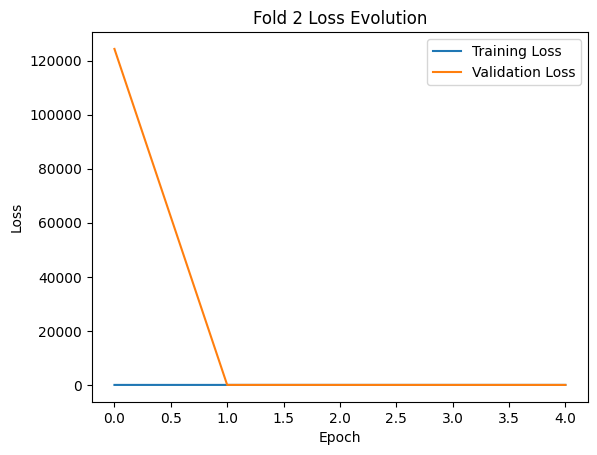

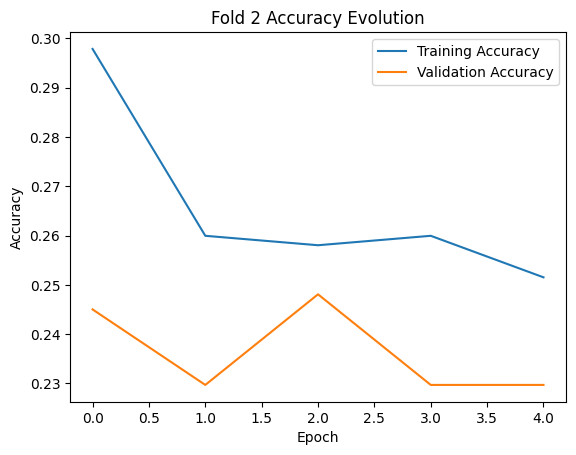

/tmp/ipykernel_55372/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
/home

                  precision    recall  f1-score   support

 pituitary_tumor     0.2665    1.0000    0.4208       105
    glioma_tumor     0.0000    0.0000    0.0000        74
        no_tumor     0.0000    0.0000    0.0000       115
meningioma_tumor     0.0000    0.0000    0.0000       100

        accuracy                         0.2665       394
       macro avg     0.0666    0.2500    0.1052       394
    weighted avg     0.0710    0.2665    0.1122       394

Fold 2 completed.
Fold: 3
Epoch: 1
Epoch 1 fold 3 train_precision: 0.3493, train_recall: 0.2925, train_f1: 0.2640, train_accuracy: 0.2925
current epoch: 1 current AUC: 0.6286 current accuracy: 0.2511 best AUC: 0.6517 at epoch: 2
Epoch 1 fold 3 val_precision: 0.0653, val_recall: 0.2511, val_f1: 0.1037, val_accuracy: 0.2511
Epoch: 2


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 fold 3 train_precision: 0.3615, train_recall: 0.3480, train_f1: 0.3312, train_accuracy: 0.3480
current epoch: 2 current AUC: 0.5005 current accuracy: 0.2466 best AUC: 0.6517 at epoch: 2
Epoch 2 fold 3 val_precision: 0.1881, val_recall: 0.2466, val_f1: 0.0997, val_accuracy: 0.2466
Epoch: 3


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 fold 3 train_precision: 0.1968, train_recall: 0.2431, train_f1: 0.1322, train_accuracy: 0.2431
current epoch: 3 current AUC: 0.5000 current accuracy: 0.2557 best AUC: 0.6517 at epoch: 2
Epoch 3 fold 3 val_precision: 0.0654, val_recall: 0.2557, val_f1: 0.1042, val_accuracy: 0.2557
Epoch: 4


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 fold 3 train_precision: 0.1805, train_recall: 0.2431, train_f1: 0.1720, train_accuracy: 0.2431
current epoch: 4 current AUC: 0.5000 current accuracy: 0.2450 best AUC: 0.6517 at epoch: 2
Epoch 4 fold 3 val_precision: 0.0600, val_recall: 0.2450, val_f1: 0.0964, val_accuracy: 0.2450
Epoch: 5


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 fold 3 train_precision: 0.1756, train_recall: 0.2328, train_f1: 0.1972, train_accuracy: 0.2328
current epoch: 5 current AUC: 0.5000 current accuracy: 0.2450 best AUC: 0.6517 at epoch: 2
Epoch 5 fold 3 val_precision: 0.0600, val_recall: 0.2450, val_f1: 0.0964, val_accuracy: 0.2450


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


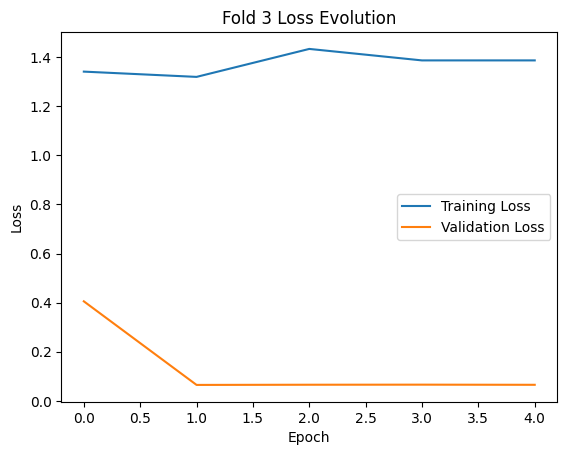

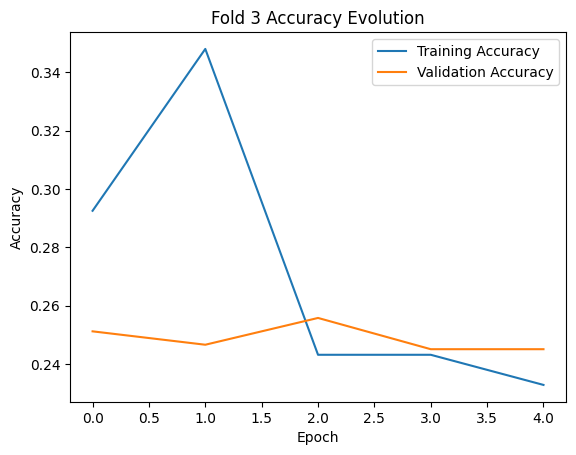

/tmp/ipykernel_55372/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
/home

                  precision    recall  f1-score   support

 pituitary_tumor     0.2665    1.0000    0.4208       105
    glioma_tumor     0.0000    0.0000    0.0000        74
        no_tumor     0.0000    0.0000    0.0000       115
meningioma_tumor     0.0000    0.0000    0.0000       100

        accuracy                         0.2665       394
       macro avg     0.0666    0.2500    0.1052       394
    weighted avg     0.0710    0.2665    0.1122       394

Fold 3 completed.
Fold: 4
Epoch: 1
Epoch 1 fold 4 train_precision: 0.2699, train_recall: 0.2592, train_f1: 0.2508, train_accuracy: 0.2592
current epoch: 1 current AUC: 0.5000 current accuracy: 0.2282 best AUC: 0.6517 at epoch: 2
Epoch 1 fold 4 val_precision: 0.0521, val_recall: 0.2282, val_f1: 0.0848, val_accuracy: 0.2282
Epoch: 2


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 fold 4 train_precision: 0.1780, train_recall: 0.2423, train_f1: 0.1916, train_accuracy: 0.2423
current epoch: 2 current AUC: 0.5000 current accuracy: 0.2282 best AUC: 0.6517 at epoch: 2
Epoch 2 fold 4 val_precision: 0.0521, val_recall: 0.2282, val_f1: 0.0848, val_accuracy: 0.2282
Epoch: 3


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 fold 4 train_precision: 0.2388, train_recall: 0.2423, train_f1: 0.2283, train_accuracy: 0.2423
current epoch: 3 current AUC: 0.5000 current accuracy: 0.2282 best AUC: 0.6517 at epoch: 2
Epoch 3 fold 4 val_precision: 0.0521, val_recall: 0.2282, val_f1: 0.0848, val_accuracy: 0.2282
Epoch: 4


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 fold 4 train_precision: 0.2199, train_recall: 0.2404, train_f1: 0.1906, train_accuracy: 0.2404
current epoch: 4 current AUC: 0.5000 current accuracy: 0.2282 best AUC: 0.6517 at epoch: 2
Epoch 4 fold 4 val_precision: 0.0521, val_recall: 0.2282, val_f1: 0.0848, val_accuracy: 0.2282
Epoch: 5


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 fold 4 train_precision: 0.0664, train_recall: 0.2577, train_f1: 0.1056, train_accuracy: 0.2577
current epoch: 5 current AUC: 0.5000 current accuracy: 0.2282 best AUC: 0.6517 at epoch: 2
Epoch 5 fold 4 val_precision: 0.0521, val_recall: 0.2282, val_f1: 0.0848, val_accuracy: 0.2282


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


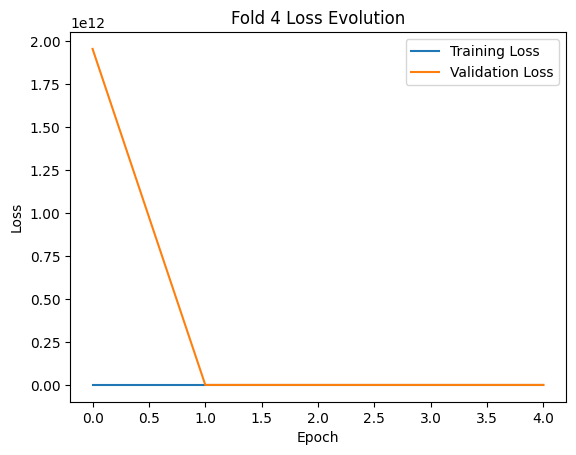

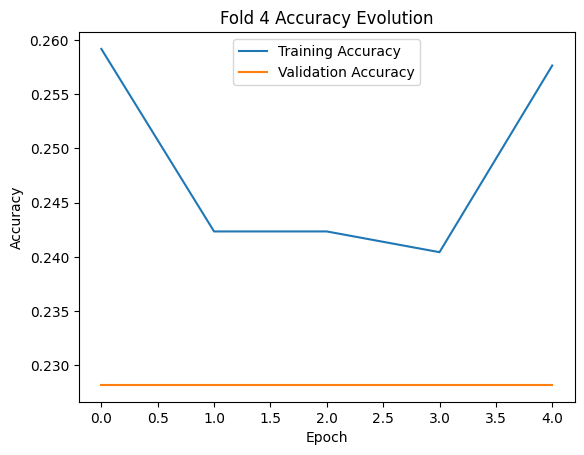

/tmp/ipykernel_55372/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
/home

                  precision    recall  f1-score   support

 pituitary_tumor     0.2665    1.0000    0.4208       105
    glioma_tumor     0.0000    0.0000    0.0000        74
        no_tumor     0.0000    0.0000    0.0000       115
meningioma_tumor     0.0000    0.0000    0.0000       100

        accuracy                         0.2665       394
       macro avg     0.0666    0.2500    0.1052       394
    weighted avg     0.0710    0.2665    0.1122       394

Fold 4 completed.
Fold: 5
Epoch: 1
Epoch 1 fold 5 train_precision: 0.3425, train_recall: 0.3013, train_f1: 0.2744, train_accuracy: 0.3013
current epoch: 1 current AUC: 0.5000 current accuracy: 0.2557 best AUC: 0.6517 at epoch: 2
Epoch 1 fold 5 val_precision: 0.0654, val_recall: 0.2557, val_f1: 0.1042, val_accuracy: 0.2557
Epoch: 2


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 fold 5 train_precision: 0.3081, train_recall: 0.2810, train_f1: 0.2443, train_accuracy: 0.2810
current epoch: 2 current AUC: 0.5000 current accuracy: 0.2557 best AUC: 0.6517 at epoch: 2
Epoch 2 fold 5 val_precision: 0.0654, val_recall: 0.2557, val_f1: 0.1042, val_accuracy: 0.2557
Epoch: 3


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 fold 5 train_precision: 0.3715, train_recall: 0.2887, train_f1: 0.2187, train_accuracy: 0.2887
current epoch: 3 current AUC: 0.5000 current accuracy: 0.2312 best AUC: 0.6517 at epoch: 2
Epoch 3 fold 5 val_precision: 0.0535, val_recall: 0.2312, val_f1: 0.0869, val_accuracy: 0.2312
Epoch: 4


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 fold 5 train_precision: 0.1393, train_recall: 0.2615, train_f1: 0.1386, train_accuracy: 0.2615
current epoch: 4 current AUC: 0.5000 current accuracy: 0.2312 best AUC: 0.6517 at epoch: 2
Epoch 4 fold 5 val_precision: 0.0535, val_recall: 0.2312, val_f1: 0.0869, val_accuracy: 0.2312
Epoch: 5


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 fold 5 train_precision: 0.0668, train_recall: 0.2584, train_f1: 0.1061, train_accuracy: 0.2584
current epoch: 5 current AUC: 0.5000 current accuracy: 0.2312 best AUC: 0.6517 at epoch: 2
Epoch 5 fold 5 val_precision: 0.0535, val_recall: 0.2312, val_f1: 0.0869, val_accuracy: 0.2312


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


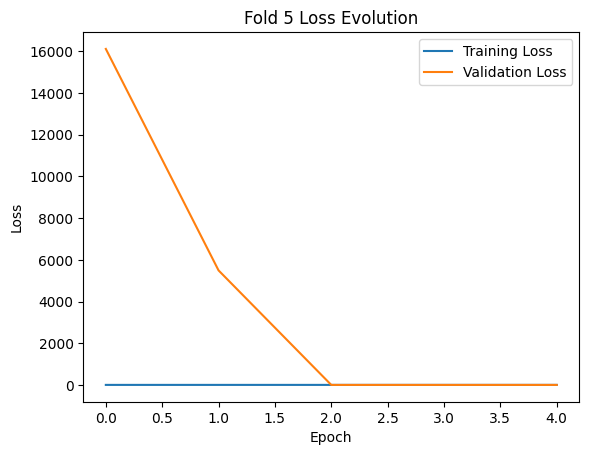

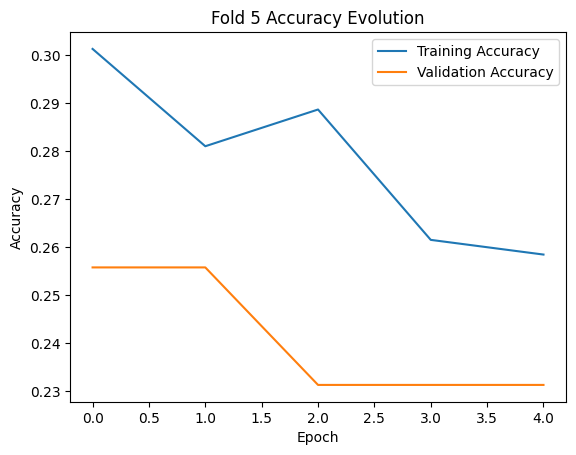

/tmp/ipykernel_55372/869593878.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


                  precision    recall  f1-score   support

 pituitary_tumor     0.2665    1.0000    0.4208       105
    glioma_tumor     0.0000    0.0000    0.0000        74
        no_tumor     0.0000    0.0000    0.0000       115
meningioma_tumor     0.0000    0.0000    0.0000       100

        accuracy                         0.2665       394
       macro avg     0.0666    0.2500    0.1052       394
    weighted avg     0.0710    0.2665    0.1122       394

Fold 5 completed.
train_precision: Mean = 0.2283, Std = 0.0968
train_recall: Mean = 0.2664, Std = 0.0249
train_f1: Mean = 0.2030, Std = 0.0602
train_accuracy: Mean = 0.2664, Std = 0.0249
val_precision: Mean = 0.0803, Std = 0.0671
val_recall: Mean = 0.2404, Std = 0.0188
val_f1: Mean = 0.0950, Std = 0.0188
val_accuracy: Mean = 0.2404, Std = 0.0188


/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/melidia/curse/is/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [24]:

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

folds, batch_size = 5, 32
auc_metric = ROCAUCMetric()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
root_dir = "/home/melidia/curse/is/"
val_interval = 1

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_dataset = Dataset(images_train_sec, label_train_sec, transforms_img)

fold_metrics = {
    "train_precision": [], "train_recall": [], "train_f1": [], "train_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": [], "val_accuracy": []
}

for (fold, (train_idx, val_idx)) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    train_losses, val_losses, val_accuracies = [], [], []
    loss_train, acc_train = [], []
    loss_val, acc_val = [], []
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        epoch_loss = 0.0
        step = 0
        y_train, y_pred = [], []
        for i, (data, label) in enumerate(train_loader):
            step += 1
            data, label = data.to(Device), label.to(Device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_train.extend(label.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())
            
        epoch_loss /= step
        loss_train.append(epoch_loss)
        
        train_precision = precision_score(y_train, y_pred, average="weighted")
        train_recall = recall_score(y_train, y_pred, average="weighted")
        train_f1 = f1_score(y_train, y_pred, average="weighted")
        train_accuracy = accuracy_score(y_train, y_pred)
        acc_train.append(train_accuracy)

        fold_metrics["train_precision"].append(train_precision)
        fold_metrics["train_recall"].append(train_recall)
        fold_metrics["train_f1"].append(train_f1)
        fold_metrics["train_accuracy"].append(train_accuracy)
        
        print(f"Epoch {epoch + 1} fold {fold + 1} train_precision: {train_precision:.4f}, train_recall: {train_recall:.4f}, train_f1: {train_f1:.4f}, train_accuracy: {train_accuracy:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            y_pred = torch.tensor([], dtype=torch.float32, device=Device)
            y = torch.tensor([], dtype=torch.long, device=Device)
            y_true_measurements, y_pred_measurements = [], []
            with torch.no_grad():
                for val_data, val_label in val_loader:
                    val_data, val_label = val_data.to(Device), val_label.to(Device)
                    val_output = model(val_data)
                    val_loss = loss_function(val_output, val_label).item()
                    pred = val_output.argmax(dim=1)
                    correct += torch.eq(pred, val_label).sum().item()
                    total += val_label.size(0)
                    y_pred = torch.cat([y_pred, val_output], 0)
                    y = torch.cat([y, val_label], 0)
                    y_true_measurements.extend(val_label.cpu().numpy())
                    y_pred_measurements.extend(val_output.argmax(dim=1).cpu().numpy())
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                
                auc_metric.reset()    
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

            val_loss /= len(val_loader)
            loss_val.append(val_loss)

            precision = precision_score(y_true_measurements, y_pred_measurements, average="weighted")
            recall = recall_score(y_true_measurements, y_pred_measurements, average="weighted")
            f1 = f1_score(y_true_measurements, y_pred_measurements, average="weighted")
            accuracy = accuracy_score(y_true_measurements, y_pred_measurements)
    
            acc_val.append(accuracy)    
            fold_metrics["val_precision"].append(precision)
            fold_metrics["val_recall"].append(recall)
            fold_metrics["val_f1"].append(f1)
            fold_metrics["val_accuracy"].append(accuracy)

            print(f"Epoch {epoch + 1} fold {fold + 1} val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}, val_accuracy: {accuracy:.4f}")
            
    plt.figure()
    plt.plot(loss_train, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(acc_train, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    labelsforknown = {
            'no_tumor',
            'pituitary_tumor',
            'meningioma_tumor',
            'glioma_tumor'
        }
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data[0].to(Device),
                test_data[1].to(Device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    print(classification_report(y_true, y_pred, target_names=labelsforknown, digits=4))
            
    print(f"Fold {fold + 1} completed.")

for key in fold_metrics:
    mean_value = np.mean(fold_metrics[key])
    std_value = np.std(fold_metrics[key])
    print(f"{key}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")
